# Classification Project of Blood Cancer

Sections in this Notebook:

- Import libraries
- Exploratory Data Analysis
- Data Processing
  - Creating Tensorflow Dataset
  - Data Augmentation
  - Image Preprocessing
  - Creating Tensorflow Dataset for AutoEncoders
- Data Modeling Architectures
  - Experimenting with CNN
  - Optimal CNN
  - ResNet
  - VGG
  - AutoEncoder / AutoClassifier
- Deep Analysis of VGG Architecture
- Model Comparison & Feature Extraction
- Using Attention
  - CNN
  - VGG
  - Final Comparison between Models
- Conclusion


In the `utils` module, the following files are provided to call the models:

- `cnn_experiments.py` and `cnn_performance_metrics.py` for CNN based iterative experiments.
- `models.py`, `training.py` and `metrics.py` for t

# Import libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install medmnist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=b00dc9681c4db6f95b21adc425124f8dabc0e9376189098bebe2a69a91744fc3
  Stored in directory: /root/.cache/pip/wheels/46/54/24/1624fd5b8674eb1188623f7e8e17cdf7c0f6c24b609dfb8a89
Successfully built fire


In [ ]:
cd '/content/drive/MyDrive/BloodCellClassification'

/content/drive/MyDrive/BloodCellClassification


In [ ]:
import numpy as np
import time
import random
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import f1_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE

In [ ]:
from medmnist import BloodMNIST
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
from utils.models import cnn, dilated, vgg, autoencoder, autoclassifier, resnet34, inception, vgg8, vgg12, vgg15, vgg18, SE_CNN, SA_CNN, CBAM_CNN, SE_VGG15, SA_VGG15, CBAM_VGG15
from utils.training import train_adam, train_sgd, train_autoencoder
from utils.metrics import training_time, memory_occupation, get_gradcam_heatmap, plot_gradcam
from utils.cnn_experiments import create_cnn
from utils.cnn_performance_metrics import evaluate_model, evaluate_test_data

In [ ]:
# Setting seed for Reproducibility
tf.random.set_seed(42)

# Exploratory Data Analysis

We will be working with 64 * 64 for starters. 128 * 128 and 224 * 224 are big to start with.

Data has already been split into train, validation and test sets (7:1:2) in the BloodMNIST library itself.

In [ ]:
# Load the dataset of the images using size 64
train_dataset = BloodMNIST(split='train', download=True, size=64)
val_dataset = BloodMNIST(split='val', download=True, size=64)
test_dataset = BloodMNIST(split='test', download=True, size=64)

100%|██████████| 156M/156M [00:02<00:00, 55.2MB/s]


Using downloaded and verified file: /root/.medmnist/bloodmnist_64.npz
Using downloaded and verified file: /root/.medmnist/bloodmnist_64.npz


In [ ]:
train_dataset # See the split between train, val and test split.

Dataset BloodMNIST of size 64 (bloodmnist_64)
    Number of datapoints: 11959
    Root location: /root/.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'basophil', '1': 'eosinophil', '2': 'erythroblast', '3': 'immature granulocytes(myelocytes, metamyelocytes and promyelocytes)', '4': 'lymphocyte', '5': 'monocyte', '6': 'neutrophil', '7': 'platelet'}
    Number of samples: {'train': 11959, 'val': 1712, 'test': 3421}
    Description: The BloodMNIST is based on a dataset of individual normal cells, captured from individuals without infection, hematologic or oncologic disease and free of any pharmacologic treatment at the moment of blood collection. It contains a total of 17,092 images and is organized into 8 classes. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images with resolution 3×360×363 pixels are center-cropped into 3×200×200, and then resized into 3×28×28.
    License: C

In [ ]:
# Define a function to get the label names
def label_name(label):
    label_dict = {
        0: 'Basophil',
        1: 'Eosinophil',
        2: 'Erythroblast',
        3: 'Granulocytes', # immature granulocytes(myelocytes, metamyelocytes and promyelocytes)
        4: 'Lymphocyte',
        5: 'Monocyte',
        6: 'Neutrophil',
        7: 'Platelet'
    }
    return label_dict.get(label, "Unknown Label")

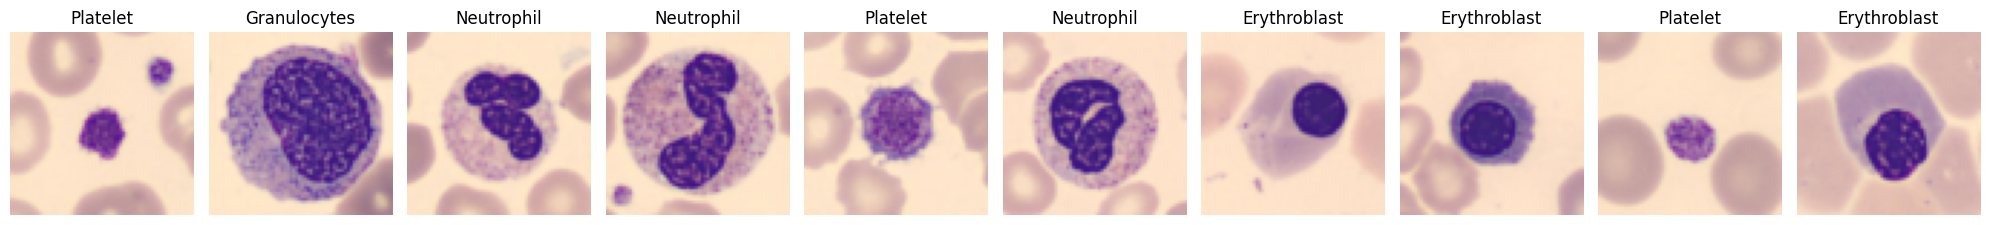

In [ ]:
# first 10 images
fig, axes = plt.subplots(1, 10, figsize=(20, 4))
for i in range(10):
    image, label = train_dataset[i]
    # Convert the PIL Image to a NumPy array
    image_np = np.array(image)
    axes[i].imshow(image_np.squeeze(), cmap='gray')  # Assuming images are grayscale

    # Get the label as an integer using .item()
    label_int = label.item()

    axes[i].set_title(label_name(label_int))  # Pass the integer label
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# See the split between classes in each set

def count_samples(dataset):
    # Extract labels
    labels = [data[1].item() for data in dataset]
    # Count occurrences of each label
    class_counts = Counter(labels)
    return class_counts

# Count samples in train, validation, and test datasets
train_counts = count_samples(train_dataset)
val_counts = count_samples(val_dataset)
test_counts = count_samples(test_dataset)

In [ ]:
print(train_counts)
print(val_counts)
print(test_counts)

Counter({6: 2330, 1: 2181, 3: 2026, 7: 1643, 2: 1085, 5: 993, 0: 852, 4: 849})
Counter({6: 333, 1: 312, 3: 290, 7: 235, 2: 155, 5: 143, 4: 122, 0: 122})
Counter({6: 666, 1: 624, 3: 579, 7: 470, 2: 311, 5: 284, 0: 244, 4: 243})


In [ ]:
max_count = max(train_counts.values())

print("Max count (useful to know for data augmentation / oversampling)", max_count)

Max count (useful to know for data augmentation / oversampling) 2330


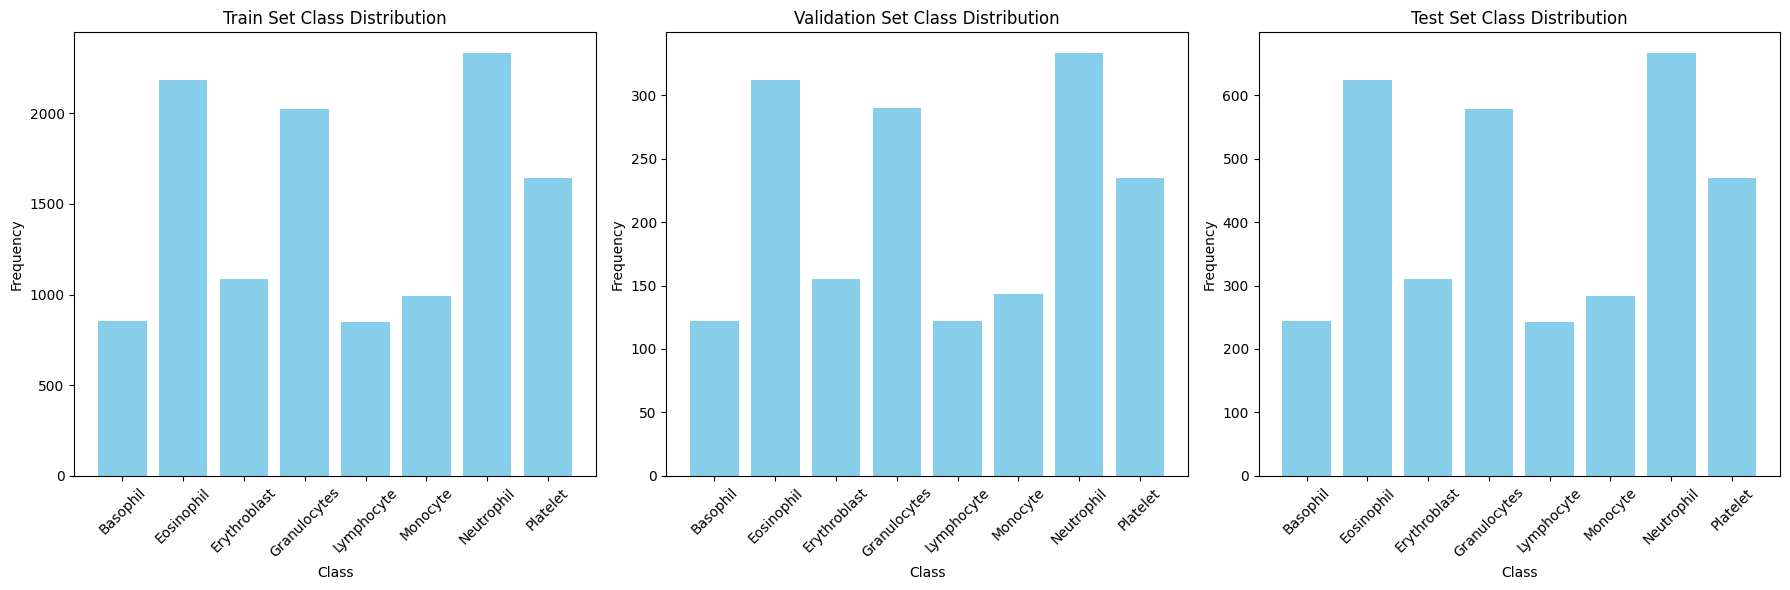

In [ ]:
# Function to sort counts and prepare data for plotting
def prepare_plot_data(counts):
    sorted_classes = sorted(counts.keys())  # Ensure indices are sorted
    frequencies = [counts[cls] for cls in sorted_classes]
    class_names = [label_name(cls) for cls in sorted_classes]
    return class_names, frequencies

# Plotting function with sorted class names
def plot_class_distribution(counts, title, ax):
    class_names, frequencies = prepare_plot_data(counts)
    ax.bar(class_names, frequencies, color='skyblue')
    ax.set_title(title)
    ax.set_xlabel("Class")
    ax.set_ylabel("Frequency")
    ax.tick_params(axis='x', rotation=45)  # Rotate class names for better readability

# Create subplots for train, val, and test
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
plot_class_distribution(train_counts, "Train Set Class Distribution", axes[0])
plot_class_distribution(val_counts, "Validation Set Class Distribution", axes[1])
plot_class_distribution(test_counts, "Test Set Class Distribution", axes[2])

plt.tight_layout()
plt.show()

This tells me that the data has been stratified across classes in the train validation and test set.

We can also notice that there is a stark difference between samples of different classes. This can lead to a bias in model performance to the dominant class, while neglecting minority classes.

In [ ]:
# Define a function to get the label names
def label_name(label):
    names = ['basophil', 'eosinophil', 'erythroblast', 'immature granulocytes', 'lymphocyte', 'monocyte', 'neutrophil', 'platelet']
    return names[label]

# Data Processing

Steps undertaken:

1. Create Tensorflow dataset, define batch size
2. Data Augmentation
3. Image Preprocessing (Normalization) \& batch dataset
4. Create separate tensorflow dataset for Autoencoders
5. Define performance metrics

## 1. Creating Tensorflow Dataset for Supervised Learning

(helps create scalable, efficient, parallelizable pipelines integrated with keras models)

In [ ]:
# Convert the datasets into tf.data.Dataset format
def create_tf_dataset(medmnist_dataset):
    images = []
    labels = []

    # Collect images and labels
    for img, label in medmnist_dataset:
        images.append(img)
        labels.append(label)

    # Convert to numpy arrays
    images = np.array(images)
    labels = np.array(labels)

    # Create TensorFlow dataset
    return tf.data.Dataset.from_tensor_slices((images, labels))

In [ ]:
# Convert MedMNIST datasets to TensorFlow datasets
train_tf_dataset = create_tf_dataset(train_dataset)
val_tf_dataset = create_tf_dataset(val_dataset)
test_tf_dataset = create_tf_dataset(test_dataset)

## 2. Data Augmentation \& Sampling Data

Data augmentation involves applying transformations like flipping, rotation, zooming, etc., to the images themselves. However, augmentation does not change the class distribution, as it does not affect the number of samples per class, just the images within those classes. Essentially, the augmented images will still belong to the same classes as the original images.

Note: Data Augmentation won't alter the number of instances in each class. It will generate new variations of images within each class, which can improve model generalization.

To reduce class imbalance, we can do the following:

- Oversampling: Duplicate samples from minority classes to balance the dataset using data augmentation techniques to generate new images; or synthetic data generation by using SMOTE algorithm (Synthetic Minority Oversampling Technique) i.e. adding noise.
- Undersampling: Reduce the number of samples in majority classes. However, without domain knowledge, we feel its not wise to undersample the dataset.

Using True statement to use Sampling and vice versa.

### Oversampling using Data Augmentation

In [ ]:
# Data augmentation function
def augment_image(image, seed=None):
    if seed is not None:
        tf.random.set_seed(seed)
    image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))  # Random rotation by 90°
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_flip_left_right(image)
    # image = tf.image.random_brightness(image, max_delta=0.1) # since cells are captured in lab conditions, the light should not make any change.
    # image = tf.image.random_contrast(image, lower=0.9, upper=1.1) # narrow contrast range

    return image

In [ ]:
def calculate_class_counts(dataset):
    class_counts = {}
    for _, label in dataset:
        label_int = label.numpy().item()
        class_counts[label_int] = class_counts.get(label_int, 0) + 1
    return class_counts

In [ ]:
def oversample_class(dataset, target_class, num_samples):
    # Filter dataset for the target class
    # Extract the scalar value from the label tensor using label[0]
    filtered_dataset = dataset.filter(lambda image, label: tf.equal(label[0], target_class))

    # Apply augmentation
    augmented_dataset = filtered_dataset.map(
        lambda image, label: (augment_image(image), label)
    )

    # Repeat and take the required number of samples
    oversampled_dataset = augmented_dataset.repeat().take(num_samples)
    return oversampled_dataset

In [ ]:
def augment_and_oversample(train_dataset):
    # Step 1: Calculate class distribution
    class_counts = calculate_class_counts(train_dataset)
    max_samples = max(class_counts.values())  # Target number of samples for each class

    # Step 2: Oversample minority classes
    oversampled_datasets = []
    for target_class, count in class_counts.items():
        if count < max_samples:
            num_samples_needed = max_samples - count
            oversampled_datasets.append(
                oversample_class(train_dataset, target_class, num_samples_needed)
            )

    # Step 3: Concatenate all datasets into a single dataset
    # Start with the original train_dataset and concatenate oversampled datasets
    balanced_dataset = train_dataset
    for oversampled_dataset in oversampled_datasets:
        balanced_dataset = balanced_dataset.concatenate(oversampled_dataset)

    # Shuffle and return
    return balanced_dataset.shuffle(buffer_size=1000)

In [ ]:
def plot_class_distribution(dataset):
    """
    Plots the class distribution of samples in a tf.data.Dataset.

    Args:
    - dataset (tf.data.Dataset): The input dataset containing (image, label) pairs.
    """
    # Count occurrences of each class
    class_counts = {}
    for _, label in dataset:
        label_int = label.numpy().item()
        class_counts[label_int] = class_counts.get(label_int, 0) + 1

    # Sort classes for a cleaner plot
    sorted_classes = sorted(class_counts.keys())
    sorted_counts = [class_counts[cls] for cls in sorted_classes]

    # Plot the distribution
    plt.figure(figsize=(10, 6))
    plt.bar(sorted_classes, sorted_counts, color="skyblue")
    plt.xlabel("Class Labels", fontsize=12)
    plt.ylabel("Number of Samples", fontsize=12)
    plt.title("Class Distribution in Dataset", fontsize=14)
    plt.xticks(sorted_classes)
    plt.grid(axis='y', linestyle="--", alpha=0.7)
    plt.show()

In [ ]:
def show_augmented_images(dataset, augment_fn, num_augments=4, batch_size=8):
    """
    Apply data augmentation to a batch of images and display the augmented results.

    Args:
        dataset: The TensorFlow dataset to take the batch from.
        augment_fn: The augmentation function to apply.
        num_augments: Number of augmentations to generate for each image.
        batch_size: Number of original images in the batch.
    """
    # Take one batch from the dataset
    for images, labels in dataset.take(1):
        images = images.numpy()
        labels = labels.numpy()

        # Plot the images with their augmentations
        plt.figure(figsize=(12, 12))
        for i in range(batch_size):
            original_image = images[i]
            # Show original image
            ax = plt.subplot(batch_size, num_augments + 1, i * (num_augments + 1) + 1)
            plt.imshow(original_image.astype("uint8"))
            plt.title(f"Label: {labels[i]}")
            plt.axis("off")

            # Show augmented images
            for j in range(num_augments):
                augmented_image = augment_fn(original_image)
                ax = plt.subplot(batch_size, num_augments + 1, i * (num_augments + 1) + j + 2)
                plt.imshow(augmented_image.numpy().astype("uint8"))
                plt.axis("off")

        plt.tight_layout()
        plt.show()
        break

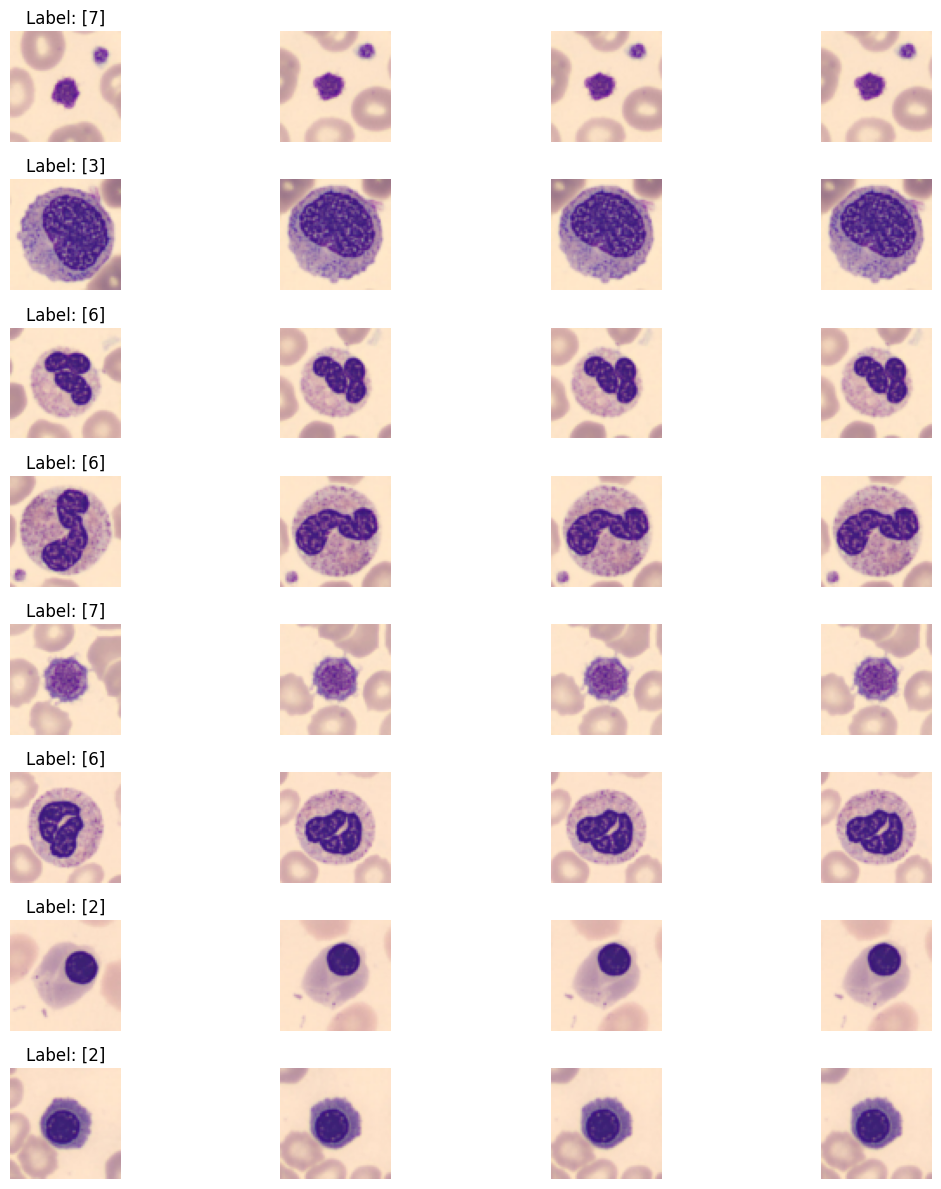

In [ ]:
show_augmented_images(
    train_tf_dataset.batch(8),  # Adjust batch size as needed
    lambda img: augment_image(tf.convert_to_tensor(img), seed=43),
    num_augments=3,  # Number of augmentations per image
    batch_size=8  # Number of images in a batch
)

### Resampling using SMOTE

(Experimental - Do Not Run)

In [ ]:
images = []
labels = []

# Collect images and labels
for img, label in train_dataset:
    images.append(img)
    labels.append(label)

# Convert to numpy arrays
images = np.array(images)
labels = np.array(labels)

images_reshaped = images.reshape(images.shape[0], -1)

# Apply SMOTE for balancing the dataset
# sampling_strategy = {
#     0: int(class_counts[0] * 0.5),  # Original count for Eosinophil
#     1: int(class_counts[1] * 0.5),  # Original count for Basophil
#     2: int(class_counts[2] * 0.5),  # Original count for Neutrophil
#     3: int(class_counts[3] * 0.5),  # Original count for Lymphocyte
#     4: int(class_counts[4] * 0.5),  # Original count for Monocyte
#     5: int(class_counts[5] * 0.5),  # Original count for Platelet
#     6: int(class_counts[6] * 0.5),  # Original count for RBC
#     7: int(class_counts[7] * 0.5)  # Original count for Background
# }
# smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
smote = SMOTE(random_state=42)
train_images_resampled, train_labels_resampled = smote.fit_resample(images_reshaped, labels)

train_images_resampled = train_images_resampled.reshape(train_images_resampled.shape[0], 64, 64, 3) # Reshape back to (num_samples, 64, 64, 3)

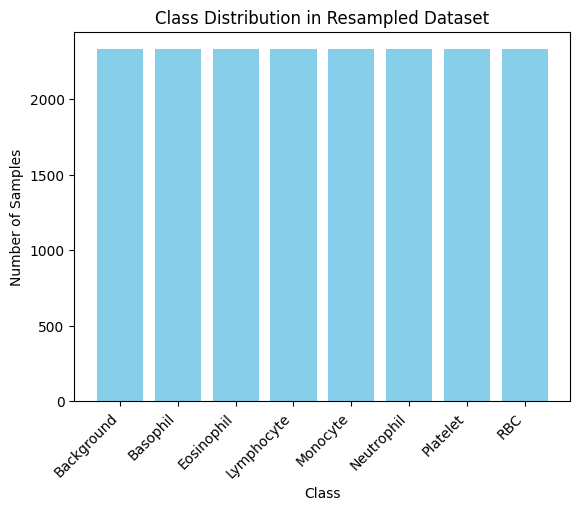

In [ ]:
all_labels_train_resampled = []
for label in train_labels_resampled:
  all_labels_train_resampled.append(label_name(label))

# Count occurrences of each label (class) in the resampled dataset
unique_labels, label_counts = np.unique(all_labels_train_resampled, return_counts=True)

# Plot class distribution of the resampled dataset
plt.bar(unique_labels, label_counts, color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in Resampled Dataset')
plt.xticks(unique_labels)  # Label x-axis with class names if needed
plt.show()

In [ ]:
# Create a TensorFlow dataset from the resampled images and labels
train_dataset = tf.data.Dataset.from_tensor_slices((train_images_resampled, train_labels_resampled))
train_tf_dataset = create_tf_dataset(train_dataset)
train_tf_dataset = train_tf_dataset.map(preprocess_image)
train_tf_dataset = train_tf_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
# Count instances per class
class_counts = Counter(train_labels_resampled)
print("Class Counts train dataset:", class_counts)

# Calculate proportions
classes, counts = zip(*sorted(class_counts.items()))
total_samples = sum(counts)
class_proportions = {cls: count / total_samples for cls, count in class_counts.items()}
print("Class Proportions:", class_proportions)

# Class ratio
largest_class = max(counts)
smallest_class = min(counts)
class_ratio = largest_class / smallest_class
print(f"Class Ratio (Largest:Smallest) = {class_ratio:.2f}")

Class Counts train dataset: Counter({7: 2330, 3: 2330, 6: 2330, 2: 2330, 1: 2330, 5: 2330, 0: 2330, 4: 2330})
Class Proportions: {7: 0.125, 3: 0.125, 6: 0.125, 2: 0.125, 1: 0.125, 5: 0.125, 0: 0.125, 4: 0.125}
Class Ratio (Largest:Smallest) = 1.00


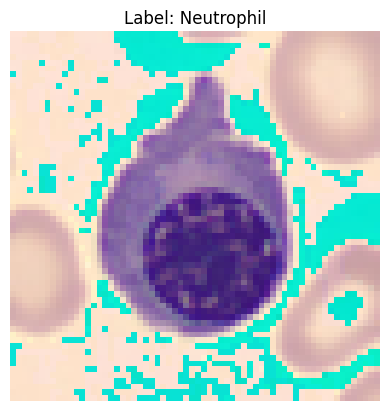

In [ ]:
# Pick an index of a generated image
index = 14000

# Extract the image and label
generated_image = train_images_resampled[index]
generated_label = train_labels_resampled[index]

# Plot the image
plt.imshow(generated_image.astype('uint8'))  # Convert to uint8 if pixel values are not in range [0, 255]
plt.title(f"Label: {label_name(generated_label)}")
plt.axis('off')  # Hide axes for better visualization
plt.show()

## 3. Image Preprocessing \& Batching

In [ ]:
# Function to preprocess images
def preprocess_image(image, label):
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1]
    return image, label

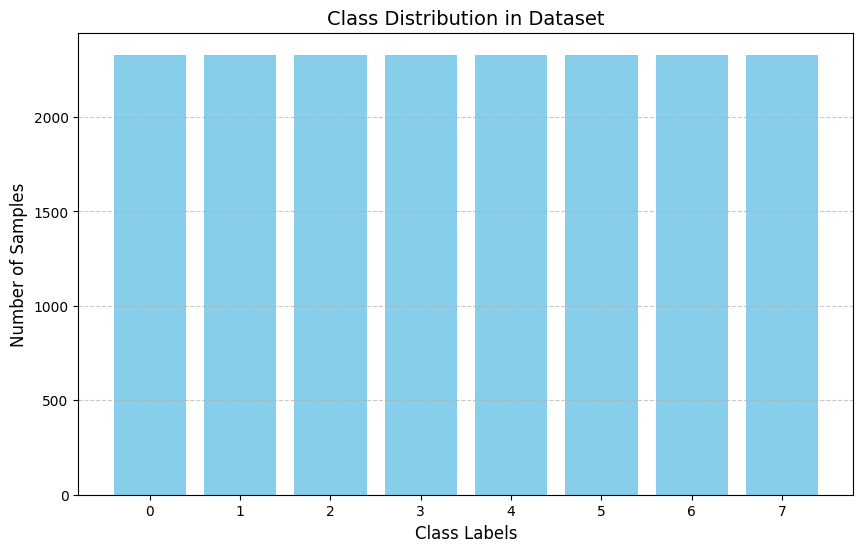

In [ ]:
# Apply preprocessing to the datasets

augment = False

if augment:
  train_tf_dataset = augment_and_oversample(train_tf_dataset)
  plot_class_distribution(train_tf_dataset)

train_tf_dataset = train_tf_dataset.map(lambda image, label: preprocess_image(image, label))
val_tf_dataset = val_tf_dataset.map(lambda image, label: preprocess_image(image, label))
test_tf_dataset = test_tf_dataset.map(lambda image, label: preprocess_image(image, label))

In [ ]:
# Batch the datasets
batch_size = 64
train_tf_dataset = train_tf_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
val_tf_dataset = val_tf_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
test_tf_dataset = test_tf_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

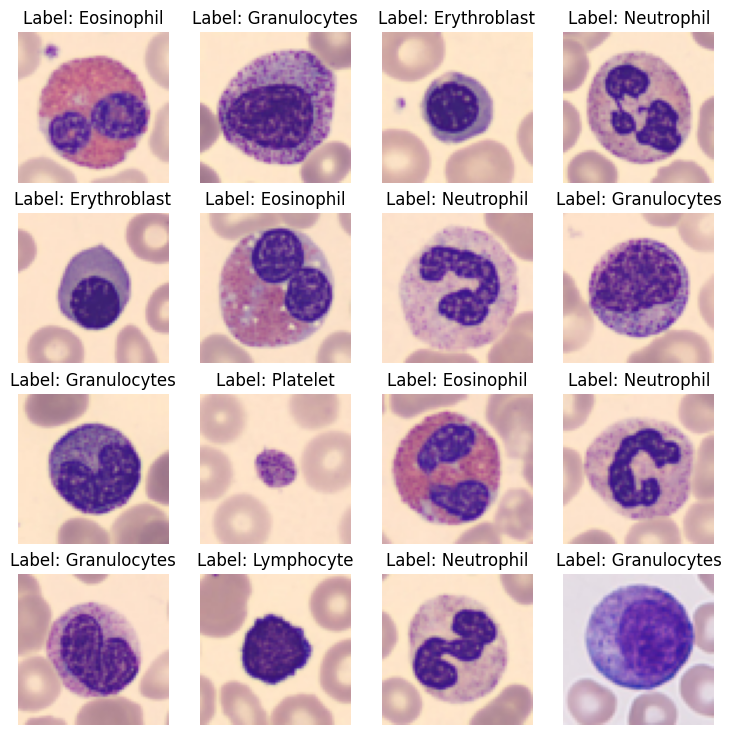

In [ ]:
# Visualize a batch of training data
# for images, labels in train_tf_dataset.take(1): # takes it randomly
#     # Plot images (display first 16 images in the batch)
#     plt.figure(figsize=(9, 9))
#     for i in range(16):
#         plt.subplot(4, 4, i+1)
#         plt.imshow(images[i].numpy())  # Convert tensor to numpy for plotting
#         plt.title(f"Label: {label_name(labels[i].numpy()[0])}")
#         plt.axis('off')
#     plt.show()

## 4. Creating Tensorflow dataset for AutoEncoders

In [ ]:
def preprocess_dataset_autoencoders(dataset):
    # Adjust this based on dataset structure
    try:
        images = dataset.images
    except AttributeError:
        images = [dataset[i][0] for i in range(len(dataset))]

    # Normalize images to [0, 1]
    images = np.array(images) / 255.0
    images = tf.convert_to_tensor(images, dtype=tf.float32)

    # Create (input, target) pairs
    dataset = tf.data.Dataset.from_tensor_slices((images, images))
    return dataset

# Preprocess datasets
train_autoencoder_dataset = preprocess_dataset_autoencoders(train_dataset)
val_autoencoder_dataset = preprocess_dataset_autoencoders(val_dataset)
test_autoencoder_dataset = preprocess_dataset_autoencoders(test_dataset)

# Batch the datasets
batch_size = 64  # Define your batch size
train_autoencoder_dataset = train_autoencoder_dataset.batch(batch_size, drop_remainder=True)
val_autoencoder_dataset = val_autoencoder_dataset.batch(batch_size, drop_remainder=True)
test_autoencoder_dataset = test_autoencoder_dataset.batch(batch_size, drop_remainder=True)

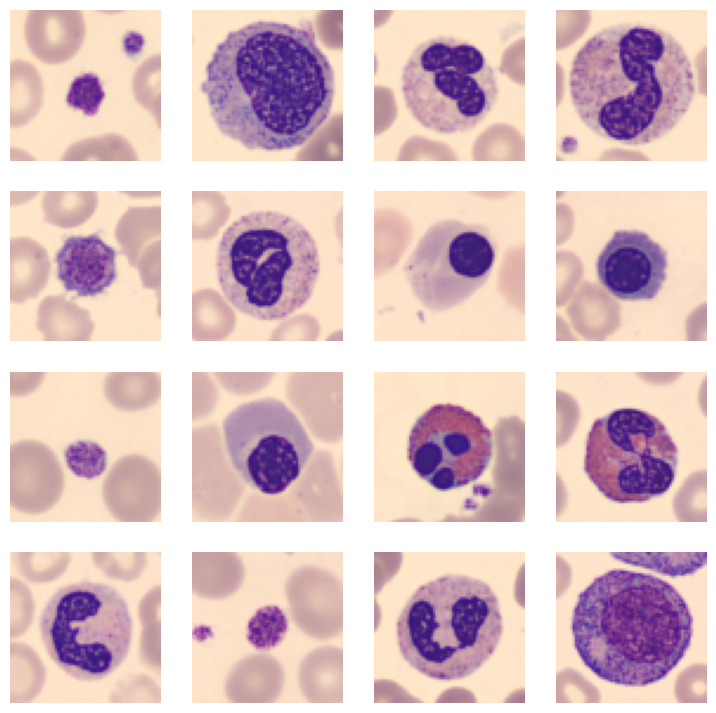

In [ ]:
# Visualize a batch of training data
for images_1, images_2 in train_autoencoder_dataset.take(1):
    # Plot images (display first 16 images in the batch)
    plt.figure(figsize=(9, 9))
    for i in range(16):
        plt.subplot(4, 4, i+1)
        plt.imshow(images_1[i].numpy())
        plt.axis('off')
    plt.show()

# Modeling

This Section involves iterating through different models to find the best CNN models, which help us build understanding of the different features of the architecture.

Next we improve upon the CNN architecture with other hyperparameters.

Next we look at various other models derived from the CNN architecture, such as VGG, Inception, ResNet. And also other models such as Autoclassifiers. And combinations such as CNN with Attention.

# Experimenting a CNN model


Simple models implies standard hyperparameters like
- default filters, kernel, strides, padding
- activation function ReLu used
- maxpooling layer after conv2d layer
- optimizer: adam
- number of epochs: 10

Things being changed:
- Number of Conv2D layers
- Whether to use Maxpooling layer after the last Conv layer
- To use dense layer or not
- if dense layer used, how many neurons in the dense layer.


Performance Metrics measured for each model:

- Total Parameters
- Training Time
- Test Accuracy, Weighted F1 Score


Note: The entire RAM crashed when using dense layer with 512 units.

Note: This is done without using Data Augmentation.


In [ ]:
model_collection = {} # collect data about all the models

## 1. CNN without dense layers

### CNN 3 convolutional layers without Max Pool




In [ ]:
model_name = 'CNN_3_LAYERS_WO_MAXPOOL_IN_FINAL_LAYER_NO_DENSE_ADAM'

# define the model
model = create_cnn(model_name)

# compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # sparse_categorical_crossentropy is used if labels are integers
    metrics=['accuracy']
)

model.summary()

Model: "CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)          │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_43 (Conv2D)                   │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_36 (MaxPooling2D)      │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_44 (Conv2D)                   │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_37 (MaxPooling2D)      │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_45 (Conv2D)                   │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_12 (Flatten)                 │ (None, 524288)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 8)                   │       4,194,312 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,287,560 (16.36 MB)

 Trainable params: 4,287,560 (16.36 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 14s 63ms/step - accuracy: 0.4955 - loss: 1.9877 - val_accuracy: 0.8271 - val_loss: 0.4899
Epoch 2/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.8371 - loss: 0.4743 - val_accuracy: 0.9019 - val_loss: 0.3099
Epoch 3/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.8849 - loss: 0.3210 - val_accuracy: 0.9182 - val_loss: 0.2520
Epoch 4/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9069 - loss: 0.2573 - val_accuracy: 0.9229 - val_loss: 0.2478
Epoch 5/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.9328 - loss: 0.1972 - val_accuracy: 0.9311 - val_loss: 0.2155
Epoch 6/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9369 - loss: 0.1791 - val_accuracy: 0.9357 - val_loss: 0.2262
Epoch 7/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.9363 - loss: 0.1792 - val_accuracy: 0.9001 - val_loss: 0.3241
Epoch 8/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9454 - loss: 0.1522 - val

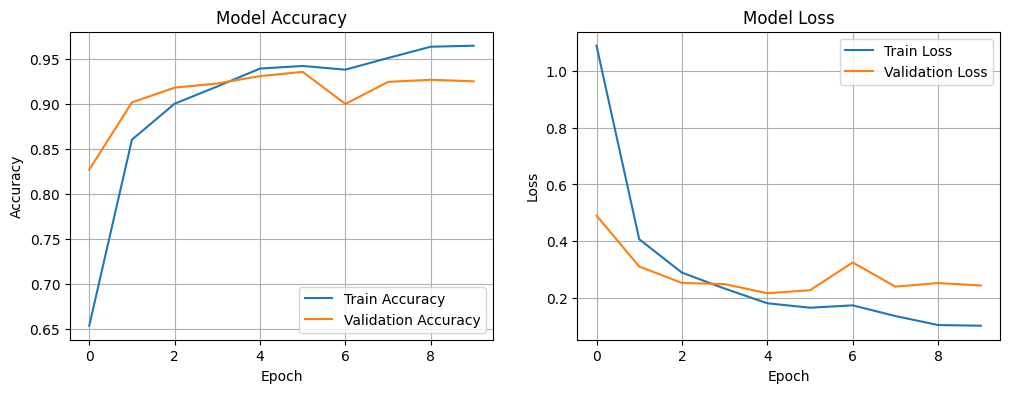

{'Model': 'CNN_3_LAYERS_WO_MAXPOOL_IN_FINAL_LAYER_NO_DENSE_ADAM', 'Total Parameters': 4287560, 'Training Time': 99.88587236404419, 'GPU Memory Before Training (MB)': 14097, 'GPU Memory Total (MB)': 15360, 'Estimated Model Memory Usage (MB)': 16.355743408203125}


In [ ]:
model_log = evaluate_model(model, train_tf_dataset, val_tf_dataset, model_name, num_epochs=10)
print(model_log)

54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9024 - loss: 0.3171
Test Loss: 0.30997925996780396
Test Accuracy: 0.9087985754013062
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━

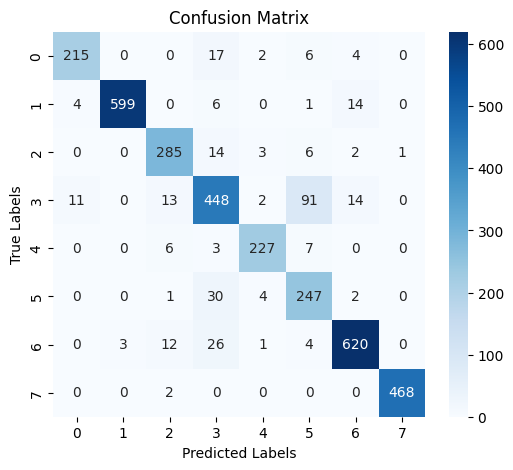

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.88      0.91       244
           1       1.00      0.96      0.98       624
           2       0.89      0.92      0.90       311
           3       0.82      0.77      0.80       579
           4       0.95      0.93      0.94       243
           5       0.68      0.87      0.76       284
           6       0.95      0.93      0.94       666
           7       1.00      1.00      1.00       470

    accuracy                           0.91      3421
   macro avg       0.90      0.91      0.90      3421
weighted avg       0.91      0.91      0.91      3421

F1 Score (Weighted): 0.9102


In [ ]:
evaluate_test_data(model, test_tf_dataset, model_log)
model_collection[model_name] = model_log

In [ ]:
# Save the model
model.save('models/' + model_name + '.keras')

### CNN 3 layers with Max Pool

In [ ]:
model_name = 'CNN_3_LAYERS_W_MAXPOOL_IN_FINAL_LAYER_NO_DENSE_ADAM'

# define the model
model = create_cnn(model_name)

# compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # sparse_categorical_crossentropy is used if labels are integers
    metrics=['accuracy']
)

model.summary()

Model: "CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)          │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_46 (Conv2D)                   │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_38 (MaxPooling2D)      │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_47 (Conv2D)                   │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_39 (MaxPooling2D)      │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_48 (Conv2D)                   │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_40 (MaxPooling2D)      │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_13 (Flatten)                 │ (None, 524288)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 8)                   │       4,194,312 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,287,560 (16.36 MB)

 Trainable params: 4,287,560 (16.36 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 13s 59ms/step - accuracy: 0.4574 - loss: 3.1127 - val_accuracy: 0.8032 - val_loss: 0.5973
Epoch 2/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.8020 - loss: 0.5858 - val_accuracy: 0.9007 - val_loss: 0.3147
Epoch 3/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.8762 - loss: 0.3529 - val_accuracy: 0.9153 - val_loss: 0.2638
Epoch 4/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - accuracy: 0.9085 - loss: 0.2644 - val_accuracy: 0.9276 - val_loss: 0.2334
Epoch 5/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.9221 - loss: 0.2183 - val_accuracy: 0.9299 - val_loss: 0.2201
Epoch 6/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.9354 - loss: 0.1841 - val_accuracy: 0.9182 - val_loss: 0.2574
Epoch 7/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9397 - loss: 0.1643 - val_accuracy: 0.9083 - val_loss: 0.3066
Epoch 8/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.9407 - loss: 0.1574 - val

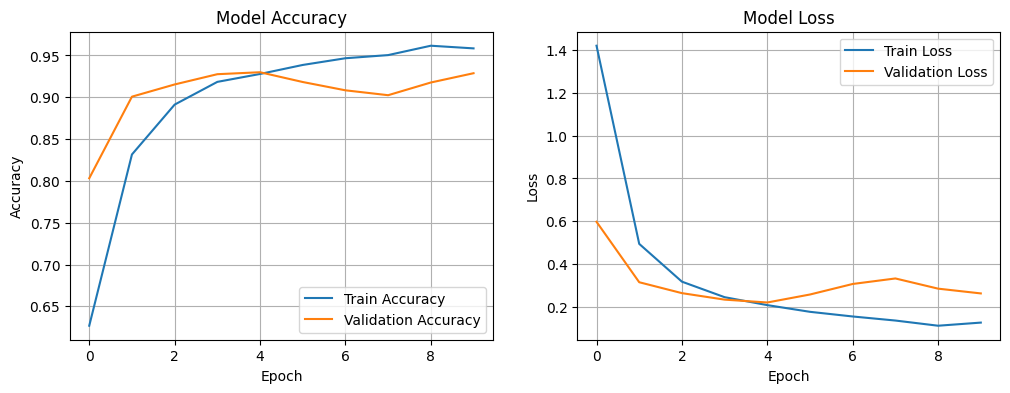

{'Model': 'CNN_3_LAYERS_W_MAXPOOL_IN_FINAL_LAYER_NO_DENSE_ADAM', 'Total Parameters': 4287560, 'Training Time': 99.44944906234741, 'GPU Memory Before Training (MB)': 14097, 'GPU Memory Total (MB)': 15360, 'Estimated Model Memory Usage (MB)': 16.355743408203125}


In [ ]:
model_log = evaluate_model(model, train_tf_dataset, val_tf_dataset, model_name, num_epochs=10)
print(model_log)

54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9096 - loss: 0.3441
Test Loss: 0.3159882724285126
Test Accuracy: 0.9131832718849182
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 

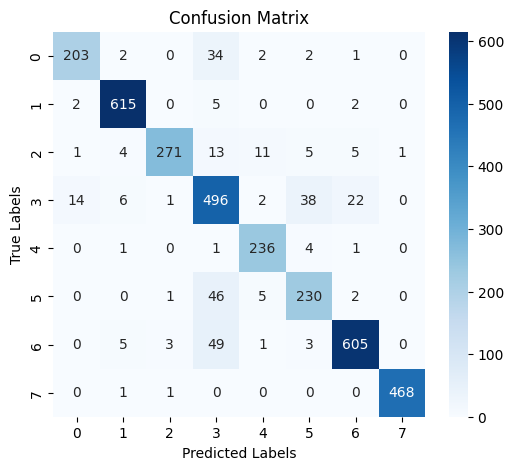

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.83      0.88       244
           1       0.97      0.99      0.98       624
           2       0.98      0.87      0.92       311
           3       0.77      0.86      0.81       579
           4       0.92      0.97      0.94       243
           5       0.82      0.81      0.81       284
           6       0.95      0.91      0.93       666
           7       1.00      1.00      1.00       470

    accuracy                           0.91      3421
   macro avg       0.92      0.90      0.91      3421
weighted avg       0.92      0.91      0.91      3421

F1 Score (Weighted): 0.9139


In [ ]:
evaluate_test_data(model, test_tf_dataset, model_log)
model_collection[model_name] = model_log

In [ ]:
# Save the model
model.save('models/' + model_name + '.keras')

### CNN 4 layers without max pool

In [ ]:
model_name = 'CNN_4_LAYERS_WO_MAXPOOL_IN_FINAL_LAYER_NO_DENSE_ADAM'

# define the model
model = create_cnn(model_name)

# compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # sparse_categorical_crossentropy is used if labels are integers
    metrics=['accuracy']
)

model.summary()

Model: "CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)          │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_49 (Conv2D)                   │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_41 (MaxPooling2D)      │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_50 (Conv2D)                   │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_42 (MaxPooling2D)      │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_51 (Conv2D)                   │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_43 (MaxPooling2D)      │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_52 (Conv2D)                   │ (None, 64, 64, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_14 (Flatten)                 │ (None, 1048576)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 8)                   │       8,388,616 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,777,032 (33.48 MB)

 Trainable params: 8,777,032 (33.48 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - accuracy: 0.5103 - loss: 2.1438 - val_accuracy: 0.8610 - val_loss: 0.4105
Epoch 2/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 37s 120ms/step - accuracy: 0.8629 - loss: 0.4065 - val_accuracy: 0.8984 - val_loss: 0.3058
Epoch 3/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 22s 120ms/step - accuracy: 0.8973 - loss: 0.2977 - val_accuracy: 0.9206 - val_loss: 0.2453
Epoch 4/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 41s 118ms/step - accuracy: 0.9261 - loss: 0.2151 - val_accuracy: 0.9282 - val_loss: 0.2240
Epoch 5/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 41s 121ms/step - accuracy: 0.9362 - loss: 0.1865 - val_accuracy: 0.9136 - val_loss: 0.2736
Epoch 6/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 41s 119ms/step - accuracy: 0.9364 - loss: 0.1705 - val_accuracy: 0.9171 - val_loss: 0.2516
Epoch 7/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 41s 119ms/step - accuracy: 0.9531 - loss: 0.1287 - val_accuracy: 0.8873 - val_loss: 0.3511
Epoch 8/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 41s 122ms/step - accuracy: 0.9540 - loss: 0

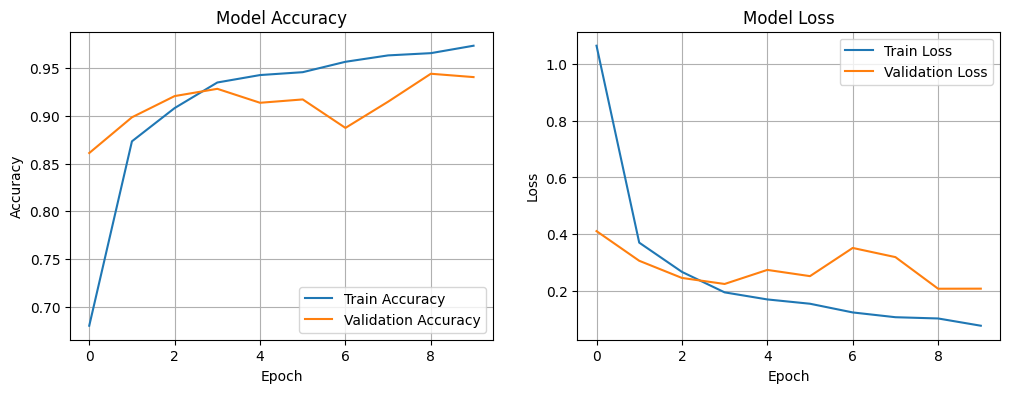

{'Model': 'CNN_4_LAYERS_WO_MAXPOOL_IN_FINAL_LAYER_NO_DENSE_ADAM', 'Total Parameters': 8777032, 'Training Time': 374.1235795021057, 'GPU Memory Before Training (MB)': 14097, 'GPU Memory Total (MB)': 15360, 'Estimated Model Memory Usage (MB)': 33.481719970703125}


In [ ]:
model_log = evaluate_model(model, train_tf_dataset, val_tf_dataset, model_name, num_epochs=10)
print(model_log)

54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.9238 - loss: 0.2777
Test Loss: 0.26784390211105347
Test Accuracy: 0.9275065660476685
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━

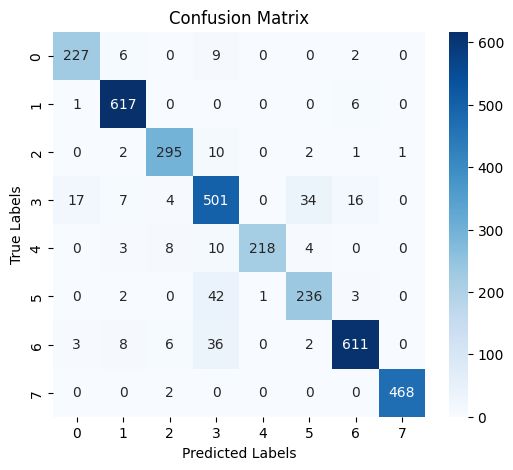

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.93      0.92       244
           1       0.96      0.99      0.97       624
           2       0.94      0.95      0.94       311
           3       0.82      0.87      0.84       579
           4       1.00      0.90      0.94       243
           5       0.85      0.83      0.84       284
           6       0.96      0.92      0.94       666
           7       1.00      1.00      1.00       470

    accuracy                           0.93      3421
   macro avg       0.93      0.92      0.92      3421
weighted avg       0.93      0.93      0.93      3421

F1 Score (Weighted): 0.9277


In [ ]:
evaluate_test_data(model, test_tf_dataset, model_log)
model_collection[model_name] = model_log

In [ ]:
# Save the model
model.save('models/' + model_name + '.keras')

### CNN with 4 layers with max pool

In [ ]:
model_name = 'CNN_4_LAYERS_W_MAXPOOL_IN_FINAL_LAYER_NO_DENSE_ADAM'

# define the model
model = create_cnn(model_name)

# compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # sparse_categorical_crossentropy is used if labels are integers
    metrics=['accuracy']
)

model.summary()

Model: "CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)          │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_53 (Conv2D)                   │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_44 (MaxPooling2D)      │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_54 (Conv2D)                   │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_45 (MaxPooling2D)      │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_55 (Conv2D)                   │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_46 (MaxPooling2D)      │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_56 (Conv2D)                   │ (None, 64, 64, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_47 (MaxPooling2D)      │ (None, 64, 64, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_15 (Flatten)                 │ (None, 1048576)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 8)                   │       8,388,616 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,777,032 (33.48 MB)

 Trainable params: 8,777,032 (33.48 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 30s 140ms/step - accuracy: 0.4272 - loss: 2.9825 - val_accuracy: 0.8067 - val_loss: 0.5873
Epoch 2/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 38s 127ms/step - accuracy: 0.7838 - loss: 0.6191 - val_accuracy: 0.8849 - val_loss: 0.3506
Epoch 3/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 41s 127ms/step - accuracy: 0.8657 - loss: 0.3886 - val_accuracy: 0.8978 - val_loss: 0.3012
Epoch 4/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 24s 126ms/step - accuracy: 0.8849 - loss: 0.3284 - val_accuracy: 0.8867 - val_loss: 0.3528
Epoch 5/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 41s 126ms/step - accuracy: 0.8965 - loss: 0.2996 - val_accuracy: 0.9171 - val_loss: 0.2607
Epoch 6/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 42s 130ms/step - accuracy: 0.9182 - loss: 0.2378 - val_accuracy: 0.9241 - val_loss: 0.2465
Epoch 7/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 40s 126ms/step - accuracy: 0.9147 - loss: 0.2282 - val_accuracy: 0.9241 - val_loss: 0.2319
Epoch 8/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 41s 129ms/step - accuracy: 0.9301 - loss: 0

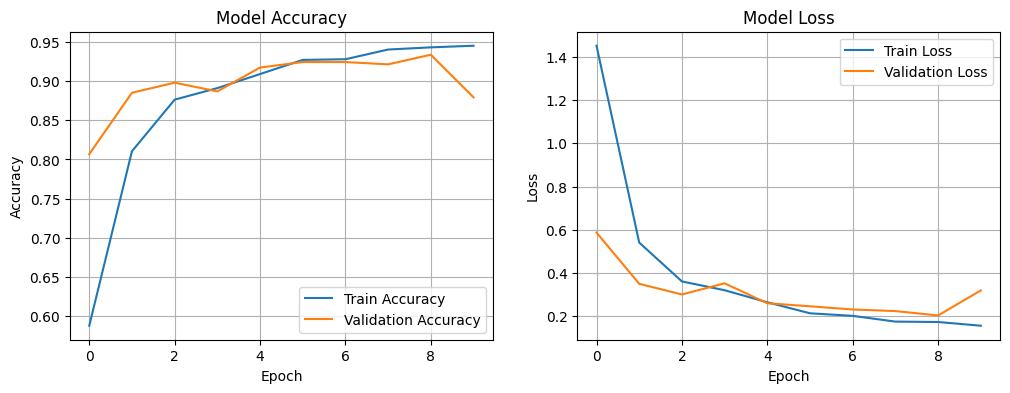

{'Model': 'CNN_4_LAYERS_W_MAXPOOL_IN_FINAL_LAYER_NO_DENSE_ADAM', 'Total Parameters': 8777032, 'Training Time': 360.2751123905182, 'GPU Memory Before Training (MB)': 14099, 'GPU Memory Total (MB)': 15360, 'Estimated Model Memory Usage (MB)': 33.481719970703125}


In [ ]:
model_log = evaluate_model(model, train_tf_dataset, val_tf_dataset, model_name, num_epochs=10)
print(model_log)

54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.8561 - loss: 0.4255
Test Loss: 0.3950824439525604
Test Accuracy: 0.8675825595855713
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 

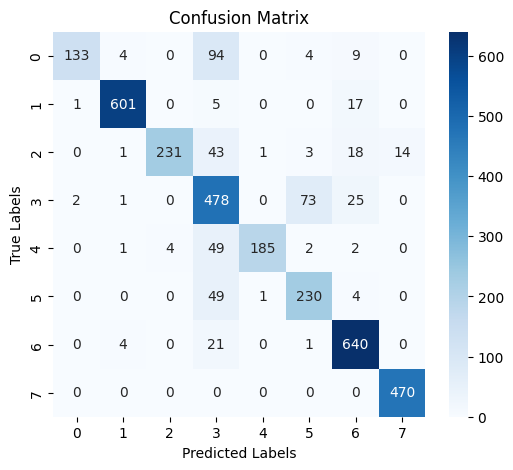

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.55      0.70       244
           1       0.98      0.96      0.97       624
           2       0.98      0.74      0.85       311
           3       0.65      0.83      0.73       579
           4       0.99      0.76      0.86       243
           5       0.73      0.81      0.77       284
           6       0.90      0.96      0.93       666
           7       0.97      1.00      0.99       470

    accuracy                           0.87      3421
   macro avg       0.90      0.83      0.85      3421
weighted avg       0.89      0.87      0.87      3421

F1 Score (Weighted): 0.8679


In [ ]:
evaluate_test_data(model, test_tf_dataset, model_log)
model_collection[model_name] = model_log

In [ ]:
# Save the model
model.save('models/' + model_name + '.keras')

### CNN 4 layers with maxpool with batch normalization

 batch normalization layers after the convolutional layers and before the activation functions

In [ ]:
model_name = 'CNN_4_LAYERS_W_MAXPOOL_IN_FINAL_LAYER_W_BATCH_NORMALIZATION_NO_DENSE_ADAM'

# define the model
model = create_cnn(model_name)

# compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # sparse_categorical_crossentropy is used if labels are integers
    metrics=['accuracy']
)

model.summary()

Model: "CNN_with_BatchNorm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64, 64, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64, 64, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 64, 64, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 64, 64, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 64, 64, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 64, 64, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 1048576)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 8)                   │       8,388,616 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 8,778,952 (33.49 MB)

 Trainable params: 8,777,992 (33.49 MB)

 Non-trainable params: 960 (3.75 KB)

Epoch 1/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 39s 175ms/step - accuracy: 0.5316 - loss: 93.5716 - val_accuracy: 0.1373 - val_loss: 152.0997
Epoch 2/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 31s 141ms/step - accuracy: 0.8457 - loss: 3.9835 - val_accuracy: 0.1472 - val_loss: 124.7684
Epoch 3/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 41s 142ms/step - accuracy: 0.8852 - loss: 3.5617 - val_accuracy: 0.6513 - val_loss: 20.1359
Epoch 4/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 28s 150ms/step - accuracy: 0.9023 - loss: 3.2963 - val_accuracy: 0.6928 - val_loss: 11.8357
Epoch 5/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 41s 149ms/step - accuracy: 0.9198 - loss: 2.1283 - val_accuracy: 0.6507 - val_loss: 12.6954
Epoch 6/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 40s 145ms/step - accuracy: 0.9283 - loss: 2.0721 - val_accuracy: 0.6437 - val_loss: 20.9787
Epoch 7/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 40s 142ms/step - accuracy: 0.9506 - loss: 1.0339 - val_accuracy: 0.8324 - val_loss: 4.7337
Epoch 8/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 41s 143ms/step - accuracy: 0.9527 

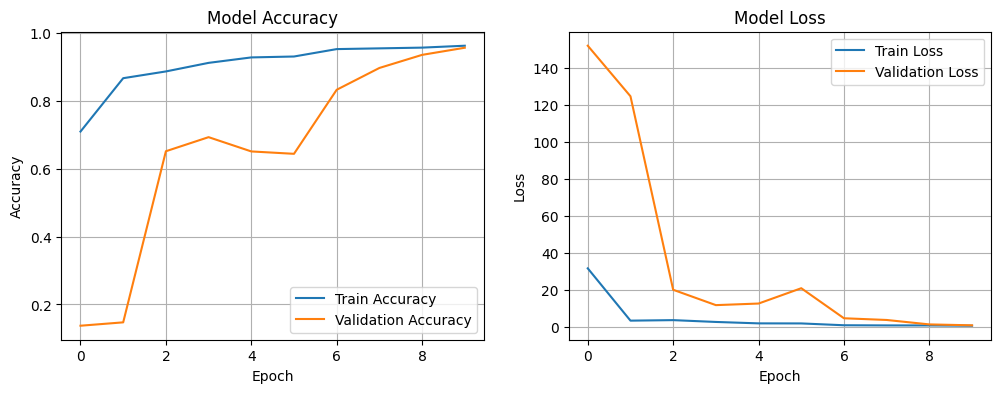

{'Model': 'CNN_4_LAYERS_W_MAXPOOL_IN_FINAL_LAYER_W_BATCH_NORMALIZATION_NO_DENSE_ADAM', 'Total Parameters': 8778952, 'Training Time': 369.38771748542786, 'GPU Memory Before Training (MB)': 14091, 'GPU Memory Total (MB)': 15360, 'Estimated Model Memory Usage (MB)': 33.489044189453125}


In [ ]:
model_log = evaluate_model(model, train_tf_dataset, val_tf_dataset, model_name, num_epochs=10)
print(model_log)

54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - accuracy: 0.9423 - loss: 1.4351
Test Loss: 1.3986440896987915
Test Accuracy: 0.9473838210105896
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0

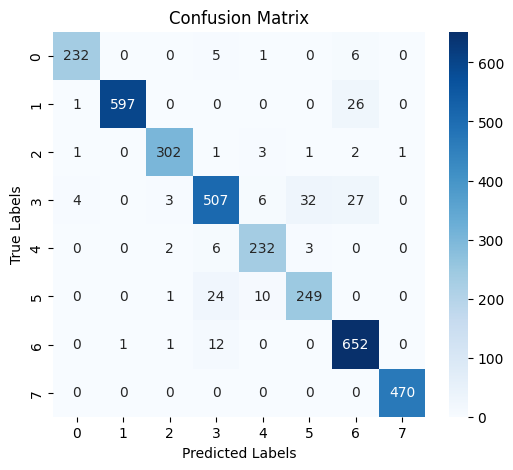

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       244
           1       1.00      0.96      0.98       624
           2       0.98      0.97      0.97       311
           3       0.91      0.88      0.89       579
           4       0.92      0.95      0.94       243
           5       0.87      0.88      0.88       284
           6       0.91      0.98      0.95       666
           7       1.00      1.00      1.00       470

    accuracy                           0.95      3421
   macro avg       0.95      0.95      0.95      3421
weighted avg       0.95      0.95      0.95      3421

F1 Score (Weighted): 0.9474


In [ ]:
evaluate_test_data(model, test_tf_dataset, model_log)
model_collection[model_name] = model_log

In [ ]:
# Save the model
model.save('models/' + model_name + '.keras')

## 2. CNN with dense layers

### CNN 3 convolutional layers without Max Pool




In [ ]:
model_name = 'CNN_3_LAYERS_WO_MAXPOOL_IN_FINAL_LAYER_DENSE_128_ADAM'

# define the model
model = create_cnn(model_name)

# compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # sparse_categorical_crossentropy is used if labels are integers
    metrics=['accuracy']
)

model.summary()

Model: "CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 524288)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 128)                 │      67,108,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 67,203,272 (256.36 MB)

 Trainable params: 67,203,272 (256.36 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 19s 80ms/step - accuracy: 0.4749 - loss: 4.3051 - val_accuracy: 0.7623 - val_loss: 0.6978
Epoch 2/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - accuracy: 0.7658 - loss: 0.6853 - val_accuracy: 0.8207 - val_loss: 0.5328
Epoch 3/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - accuracy: 0.8534 - loss: 0.4327 - val_accuracy: 0.8779 - val_loss: 0.3330
Epoch 4/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 11s 56ms/step - accuracy: 0.9017 - loss: 0.2847 - val_accuracy: 0.9282 - val_loss: 0.2288
Epoch 5/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step - accuracy: 0.9276 - loss: 0.2040 - val_accuracy: 0.9352 - val_loss: 0.2095
Epoch 6/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step - accuracy: 0.9432 - loss: 0.1605 - val_accuracy: 0.9001 - val_loss: 0.3628
Epoch 7/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 57ms/step - accuracy: 0.9423 - loss: 0.1634 - val_accuracy: 0.8674 - val_loss: 0.4319
Epoch 8/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step - accuracy: 0.9540 - loss: 0.1352 - 

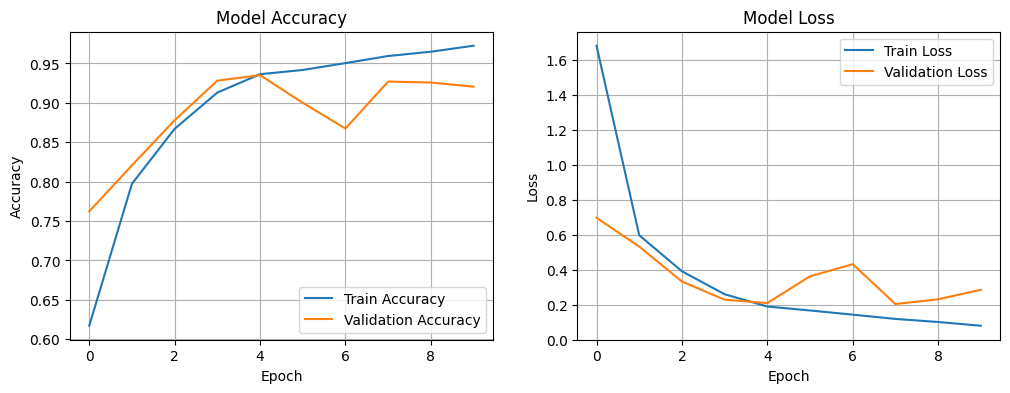

{'Model': 'CNN_3_LAYERS_WO_MAXPOOL_IN_FINAL_LAYER_DENSE_128_ADAM', 'Total Parameters': 67203272, 'Training Time': 156.79023265838623, 'GPU Memory Before Training (MB)': 14091, 'GPU Memory Total (MB)': 15360, 'Estimated Model Memory Usage (MB)': 256.3601379394531}


In [ ]:
model_log = evaluate_model(model, train_tf_dataset, val_tf_dataset, model_name, num_epochs=10)
print(model_log)

54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9176 - loss: 0.2974
Test Loss: 0.26988768577575684
Test Accuracy: 0.9237065315246582
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0

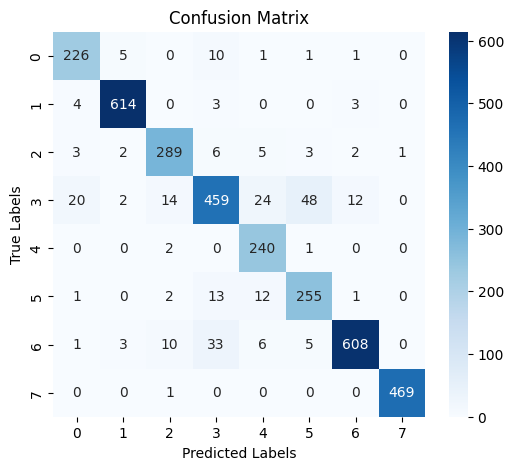

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.93      0.91       244
           1       0.98      0.98      0.98       624
           2       0.91      0.93      0.92       311
           3       0.88      0.79      0.83       579
           4       0.83      0.99      0.90       243
           5       0.81      0.90      0.85       284
           6       0.97      0.91      0.94       666
           7       1.00      1.00      1.00       470

    accuracy                           0.92      3421
   macro avg       0.91      0.93      0.92      3421
weighted avg       0.93      0.92      0.92      3421

F1 Score (Weighted): 0.9235


In [ ]:
evaluate_test_data(model, test_tf_dataset, model_log)
model_collection[model_name] = model_log

In [ ]:
# Save the model
model.save('models/' + model_name + '.keras')

### CNN 3 layers with Max Pool

In [ ]:
model_name = 'CNN_3_LAYERS_W_MAXPOOL_IN_FINAL_LAYER_DENSE_128_ADAM'

# define the model
model = create_cnn(model_name)

# compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # sparse_categorical_crossentropy is used if labels are integers
    metrics=['accuracy']
)

model.summary()

Model: "CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 524288)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 128)                 │      67,108,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 67,203,272 (256.36 MB)

 Trainable params: 67,203,272 (256.36 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 20s 77ms/step - accuracy: 0.4971 - loss: 3.4331 - val_accuracy: 0.8236 - val_loss: 0.4828
Epoch 2/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - accuracy: 0.8467 - loss: 0.4365 - val_accuracy: 0.9112 - val_loss: 0.2663
Epoch 3/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 11s 61ms/step - accuracy: 0.8948 - loss: 0.2988 - val_accuracy: 0.9206 - val_loss: 0.2410
Epoch 4/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 12s 62ms/step - accuracy: 0.9171 - loss: 0.2313 - val_accuracy: 0.9293 - val_loss: 0.1996
Epoch 5/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 11s 61ms/step - accuracy: 0.9413 - loss: 0.1713 - val_accuracy: 0.9381 - val_loss: 0.1865
Epoch 6/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 11s 61ms/step - accuracy: 0.9475 - loss: 0.1447 - val_accuracy: 0.9141 - val_loss: 0.2632
Epoch 7/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 20s 61ms/step - accuracy: 0.9555 - loss: 0.1180 - val_accuracy: 0.9504 - val_loss: 0.1757
Epoch 8/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 63ms/step - accuracy: 0.9645 - loss: 0.1043 - 

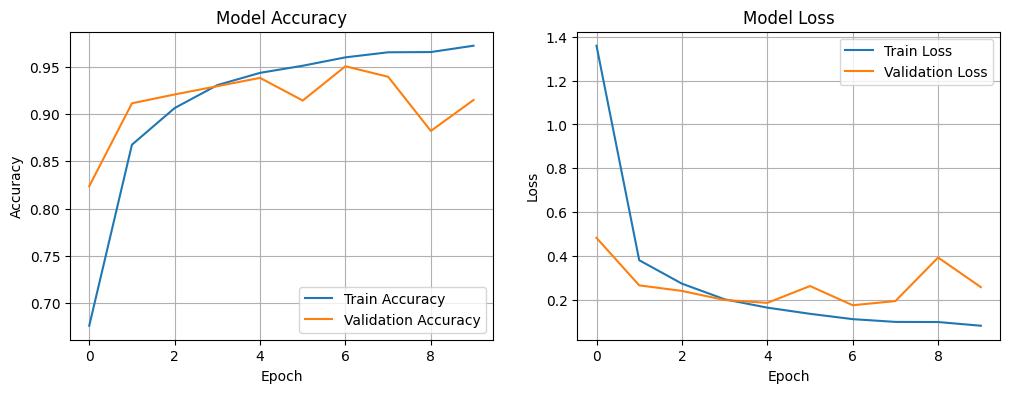

{'Model': 'CNN_3_LAYERS_W_MAXPOOL_IN_FINAL_LAYER_DENSE_128_ADAM', 'Total Parameters': 67203272, 'Training Time': 153.69052958488464, 'GPU Memory Before Training (MB)': 14093, 'GPU Memory Total (MB)': 15360, 'Estimated Model Memory Usage (MB)': 256.3601379394531}


In [ ]:
model_log = evaluate_model(model, train_tf_dataset, val_tf_dataset, model_name, num_epochs=10)
print(model_log)

54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.9022 - loss: 0.3272
Test Loss: 0.31889063119888306
Test Accuracy: 0.9070447087287903
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━

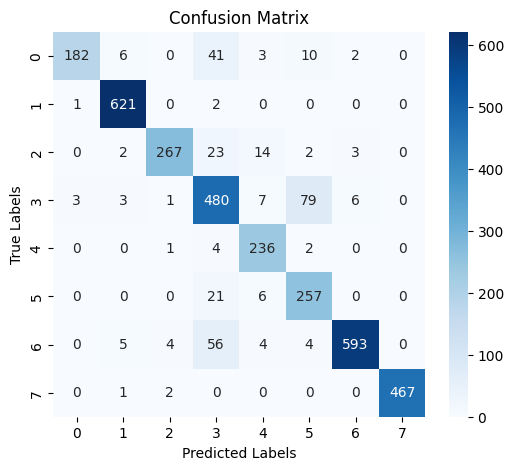

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.75      0.85       244
           1       0.97      1.00      0.98       624
           2       0.97      0.86      0.91       311
           3       0.77      0.83      0.80       579
           4       0.87      0.97      0.92       243
           5       0.73      0.90      0.81       284
           6       0.98      0.89      0.93       666
           7       1.00      0.99      1.00       470

    accuracy                           0.91      3421
   macro avg       0.91      0.90      0.90      3421
weighted avg       0.92      0.91      0.91      3421

F1 Score (Weighted): 0.9084


In [ ]:
evaluate_test_data(model, test_tf_dataset, model_log)
model_collection[model_name] = model_log

In [ ]:
# Save the model
model.save('models/' + model_name + '.keras')

### CNN 4 layers without max pool

In [ ]:
model_name = 'CNN_4_LAYERS_WO_MAXPOOL_IN_FINAL_LAYER_DENSE_128_ADAM'

# define the model
model = create_cnn(model_name)

# compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # sparse_categorical_crossentropy is used if labels are integers
    metrics=['accuracy']
)

model.summary()

Model: "CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (None, 64, 64, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 1048576)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 128)                 │     134,217,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 134,607,304 (513.49 MB)

 Trainable params: 134,607,304 (513.49 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 41s 189ms/step - accuracy: 0.4903 - loss: 2.7201 - val_accuracy: 0.7827 - val_loss: 0.6184
Epoch 2/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 29s 149ms/step - accuracy: 0.7983 - loss: 0.5676 - val_accuracy: 0.8861 - val_loss: 0.3272
Epoch 3/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 41s 147ms/step - accuracy: 0.8763 - loss: 0.3527 - val_accuracy: 0.9112 - val_loss: 0.2661
Epoch 4/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 41s 147ms/step - accuracy: 0.9077 - loss: 0.2621 - val_accuracy: 0.9276 - val_loss: 0.2313
Epoch 5/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 41s 147ms/step - accuracy: 0.9188 - loss: 0.2171 - val_accuracy: 0.9317 - val_loss: 0.2237
Epoch 6/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 41s 149ms/step - accuracy: 0.9343 - loss: 0.1808 - val_accuracy: 0.9246 - val_loss: 0.2423
Epoch 7/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 41s 149ms/step - accuracy: 0.9437 - loss: 0.1510 - val_accuracy: 0.9416 - val_loss: 0.1867
Epoch 8/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 41s 149ms/step - accuracy: 0.9507 - loss: 0

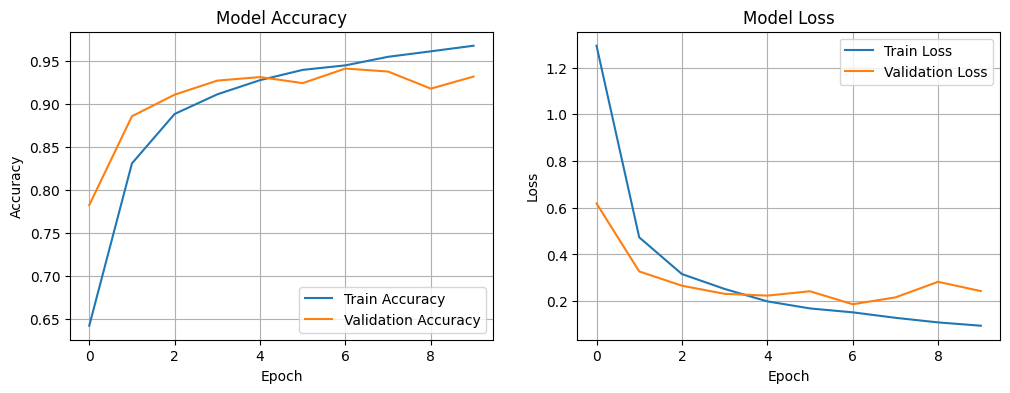

{'Model': 'CNN_4_LAYERS_WO_MAXPOOL_IN_FINAL_LAYER_DENSE_128_ADAM', 'Total Parameters': 134607304, 'Training Time': 397.96348237991333, 'GPU Memory Before Training (MB)': 14093, 'GPU Memory Total (MB)': 15360, 'Estimated Model Memory Usage (MB)': 513.4861145019531}


In [ ]:
model_log = evaluate_model(model, train_tf_dataset, val_tf_dataset, model_name, num_epochs=10)
print(model_log)

54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - accuracy: 0.9251 - loss: 0.2423
Test Loss: 0.2425694763660431
Test Accuracy: 0.9289681315422058
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0

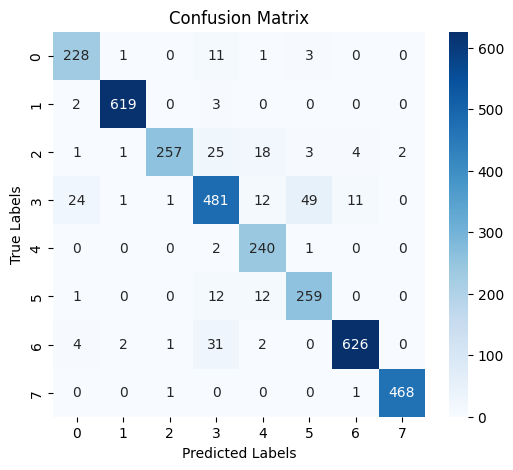

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.93      0.90       244
           1       0.99      0.99      0.99       624
           2       0.99      0.83      0.90       311
           3       0.85      0.83      0.84       579
           4       0.84      0.99      0.91       243
           5       0.82      0.91      0.86       284
           6       0.98      0.94      0.96       666
           7       1.00      1.00      1.00       470

    accuracy                           0.93      3421
   macro avg       0.92      0.93      0.92      3421
weighted avg       0.93      0.93      0.93      3421

F1 Score (Weighted): 0.9291


In [ ]:
evaluate_test_data(model, test_tf_dataset, model_log)
model_collection[model_name] = model_log

In [ ]:
# Save the model
model.save('models/' + model_name + '.keras')

### CNN 3 layers without max pool 256 dense units

In [ ]:
model_name = 'CNN_3_LAYERS_WO_MAXPOOL_IN_FINAL_LAYER_DENSE_256_ADAM'

# define the model
model = create_cnn(model_name)

# compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # sparse_categorical_crossentropy is used if labels are integers
    metrics=['accuracy']
)

model.summary()

Model: "CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 524288)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │     134,217,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 8)                   │           2,056 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 134,313,288 (512.36 MB)

 Trainable params: 134,313,288 (512.36 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 25s 107ms/step - accuracy: 0.5176 - loss: 2.8719 - val_accuracy: 0.8715 - val_loss: 0.3995
Epoch 2/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 32s 74ms/step - accuracy: 0.8523 - loss: 0.4189 - val_accuracy: 0.8884 - val_loss: 0.3252
Epoch 3/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 76ms/step - accuracy: 0.8939 - loss: 0.2988 - val_accuracy: 0.9206 - val_loss: 0.2424
Epoch 4/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 20s 75ms/step - accuracy: 0.9225 - loss: 0.2195 - val_accuracy: 0.9112 - val_loss: 0.2525
Epoch 5/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 14s 75ms/step - accuracy: 0.9274 - loss: 0.2045 - val_accuracy: 0.9375 - val_loss: 0.2012
Epoch 6/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 14s 74ms/step - accuracy: 0.9378 - loss: 0.1760 - val_accuracy: 0.9241 - val_loss: 0.2412
Epoch 7/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 14s 73ms/step - accuracy: 0.9480 - loss: 0.1503 - val_accuracy: 0.9182 - val_loss: 0.2422
Epoch 8/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 14s 74ms/step - accuracy: 0.9566 - loss: 0.1260 -

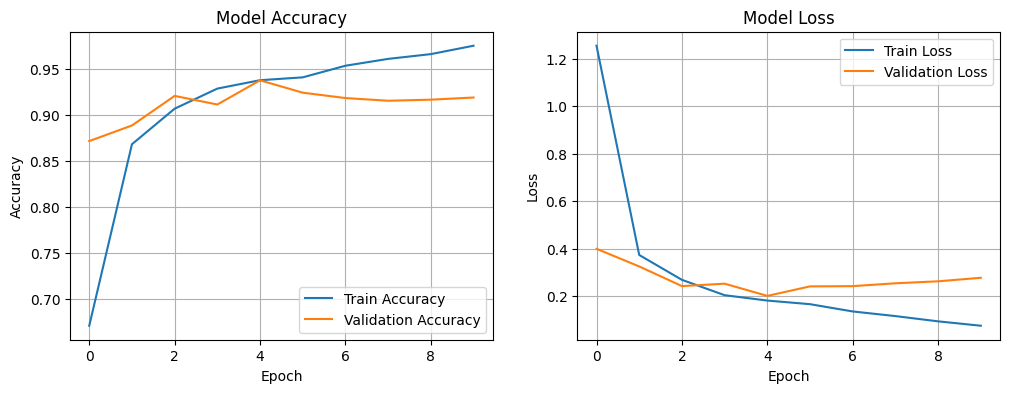

{'Model': 'CNN_3_LAYERS_WO_MAXPOOL_IN_FINAL_LAYER_DENSE_256_ADAM', 'Total Parameters': 134313288, 'Training Time': 187.04259657859802, 'GPU Memory Before Training (MB)': 12425, 'GPU Memory Total (MB)': 15360, 'Estimated Model Memory Usage (MB)': 512.3645324707031}


In [ ]:
model_log = evaluate_model(model, train_tf_dataset, val_tf_dataset, model_name, num_epochs=10)
print(model_log)

54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.9086 - loss: 0.3021
Test Loss: 0.2855433225631714
Test Accuracy: 0.9175679683685303
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s

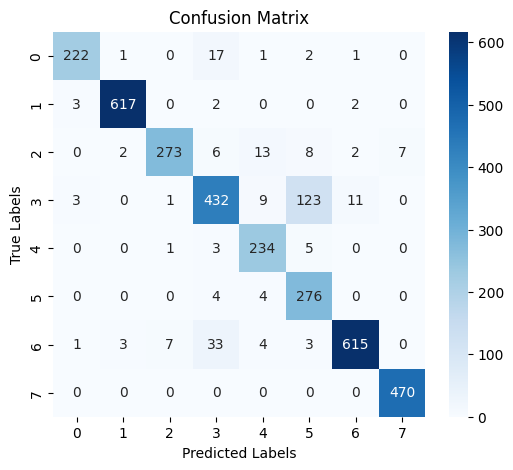

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.91      0.94       244
           1       0.99      0.99      0.99       624
           2       0.97      0.88      0.92       311
           3       0.87      0.75      0.80       579
           4       0.88      0.96      0.92       243
           5       0.66      0.97      0.79       284
           6       0.97      0.92      0.95       666
           7       0.99      1.00      0.99       470

    accuracy                           0.92      3421
   macro avg       0.91      0.92      0.91      3421
weighted avg       0.93      0.92      0.92      3421

F1 Score (Weighted): 0.9189


In [ ]:
evaluate_test_data(model, test_tf_dataset, model_log)
model_collection[model_name] = model_log

In [ ]:
# Save the model
model.save('models/' + model_name + '.keras')

### CNN 3 layers with Max Pool and 256 units in dense layer

In [ ]:
model_name = 'CNN_3_LAYERS_W_MAXPOOL_IN_FINAL_LAYER_DENSE_256_ADAM'

# define the model
model = create_cnn(model_name)

# compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # sparse_categorical_crossentropy is used if labels are integers
    metrics=['accuracy']
)

model.summary()

Model: "CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_28 (Conv2D)                   │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_24 (MaxPooling2D)      │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_25 (MaxPooling2D)      │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_30 (Conv2D)                   │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_26 (MaxPooling2D)      │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 524288)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 256)                 │     134,217,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 8)                   │           2,056 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 134,313,288 (512.36 MB)

 Trainable params: 134,313,288 (512.36 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 27s 120ms/step - accuracy: 0.4702 - loss: 4.2896 - val_accuracy: 0.8843 - val_loss: 0.3869
Epoch 2/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 30s 76ms/step - accuracy: 0.8467 - loss: 0.4435 - val_accuracy: 0.9001 - val_loss: 0.2933
Epoch 3/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 20s 76ms/step - accuracy: 0.8952 - loss: 0.2933 - val_accuracy: 0.9171 - val_loss: 0.2405
Epoch 4/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 77ms/step - accuracy: 0.9130 - loss: 0.2477 - val_accuracy: 0.9252 - val_loss: 0.2500
Epoch 5/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 20s 77ms/step - accuracy: 0.9181 - loss: 0.2274 - val_accuracy: 0.9287 - val_loss: 0.2361
Epoch 6/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 20s 77ms/step - accuracy: 0.9369 - loss: 0.1788 - val_accuracy: 0.9206 - val_loss: 0.2493
Epoch 7/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 20s 76ms/step - accuracy: 0.9543 - loss: 0.1302 - val_accuracy: 0.9206 - val_loss: 0.2350
Epoch 8/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 76ms/step - accuracy: 0.9580 - loss: 0.1143 -

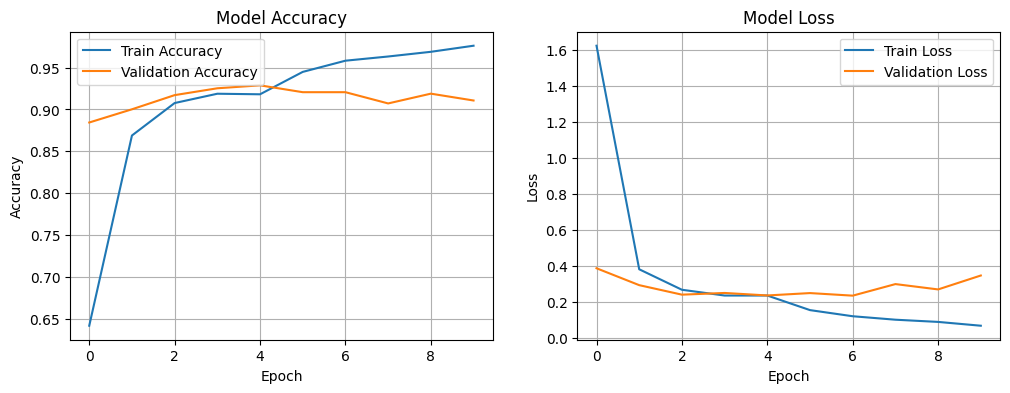

{'Model': 'CNN_3_LAYERS_W_MAXPOOL_IN_FINAL_LAYER_DENSE_256_ADAM', 'Total Parameters': 134313288, 'Training Time': 220.22828602790833, 'GPU Memory Before Training (MB)': 14093, 'GPU Memory Total (MB)': 15360, 'Estimated Model Memory Usage (MB)': 512.3645324707031}


In [ ]:
model_log = evaluate_model(model, train_tf_dataset, val_tf_dataset, model_name, num_epochs=10)
print(model_log)

54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.9029 - loss: 0.3817
Test Loss: 0.3733308017253876
Test Accuracy: 0.9047062397003174
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s

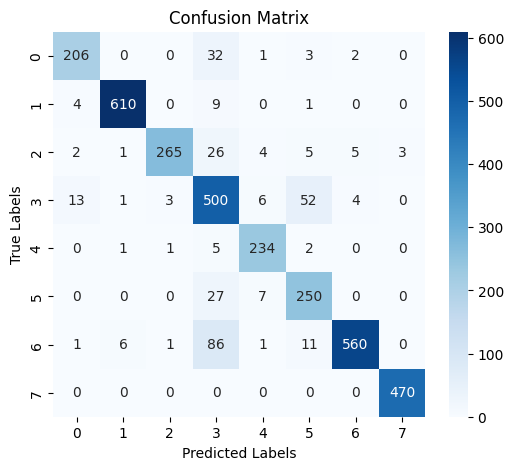

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.84      0.88       244
           1       0.99      0.98      0.98       624
           2       0.98      0.85      0.91       311
           3       0.73      0.86      0.79       579
           4       0.92      0.96      0.94       243
           5       0.77      0.88      0.82       284
           6       0.98      0.84      0.91       666
           7       0.99      1.00      1.00       470

    accuracy                           0.90      3421
   macro avg       0.91      0.90      0.90      3421
weighted avg       0.91      0.90      0.91      3421

F1 Score (Weighted): 0.9069


In [ ]:
evaluate_test_data(model, test_tf_dataset, model_log)
model_collection[model_name] = model_log

In [ ]:
# Save the model
model.save('models/' + model_name + '.keras')

### CNN with 4 layer without max pool and 256 units in dense layer

In [ ]:
model_name = 'CNN_4_LAYERS_WO_MAXPOOL_IN_FINAL_LAYER_DENSE_256_ADAM'

# define the model
model = create_cnn(model_name)

# compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # sparse_categorical_crossentropy is used if labels are integers
    metrics=['accuracy']
)

model.summary()

Model: "CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_31 (Conv2D)                   │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_27 (MaxPooling2D)      │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_32 (Conv2D)                   │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_28 (MaxPooling2D)      │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_33 (Conv2D)                   │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_29 (MaxPooling2D)      │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_34 (Conv2D)                   │ (None, 64, 64, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_9 (Flatten)                  │ (None, 1048576)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 256)                 │     268,435,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 8)                   │           2,056 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 268,826,184 (1.00 GB)

 Trainable params: 268,826,184 (1.00 GB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 49s 222ms/step - accuracy: 0.5028 - loss: 4.8863 - val_accuracy: 0.8230 - val_loss: 0.5090
Epoch 2/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 69s 180ms/step - accuracy: 0.8351 - loss: 0.4745 - val_accuracy: 0.8884 - val_loss: 0.3025
Epoch 3/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 41s 180ms/step - accuracy: 0.8819 - loss: 0.3277 - val_accuracy: 0.8995 - val_loss: 0.2649
Epoch 4/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 41s 180ms/step - accuracy: 0.8442 - loss: 0.4467 - val_accuracy: 0.9013 - val_loss: 0.2946
Epoch 5/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 41s 180ms/step - accuracy: 0.9037 - loss: 0.2742 - val_accuracy: 0.9188 - val_loss: 0.2430
Epoch 6/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 33s 179ms/step - accuracy: 0.9280 - loss: 0.2099 - val_accuracy: 0.9387 - val_loss: 0.1968
Epoch 7/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 41s 179ms/step - accuracy: 0.9449 - loss: 0.1648 - val_accuracy: 0.9387 - val_loss: 0.1870
Epoch 8/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 41s 179ms/step - accuracy: 0.9546 - loss: 0

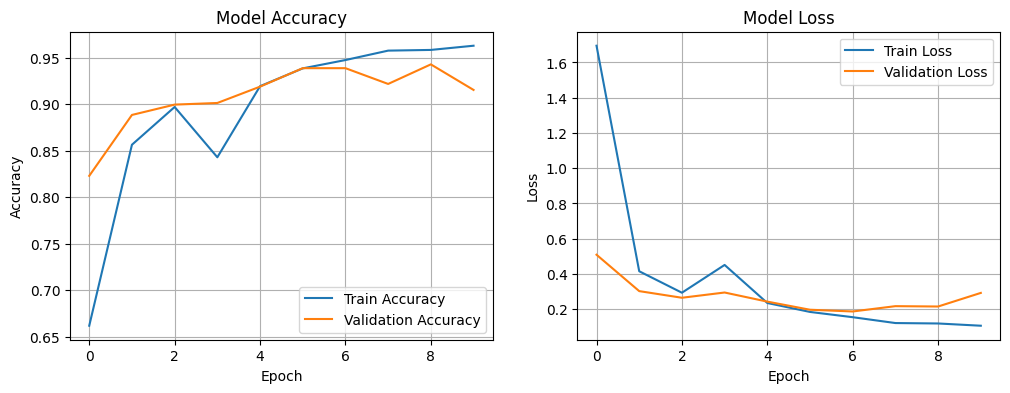

{'Model': 'CNN_4_LAYERS_WO_MAXPOOL_IN_FINAL_LAYER_DENSE_256_ADAM', 'Total Parameters': 268826184, 'Training Time': 445.1844756603241, 'GPU Memory Before Training (MB)': 14097, 'GPU Memory Total (MB)': 15360, 'Estimated Model Memory Usage (MB)': 1025.4905090332031}


In [ ]:
model_log = evaluate_model(model, train_tf_dataset, val_tf_dataset, model_name, num_epochs=10)
print(model_log)

54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - accuracy: 0.9118 - loss: 0.2975
Test Loss: 0.3041791021823883
Test Accuracy: 0.9114294052124023
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0

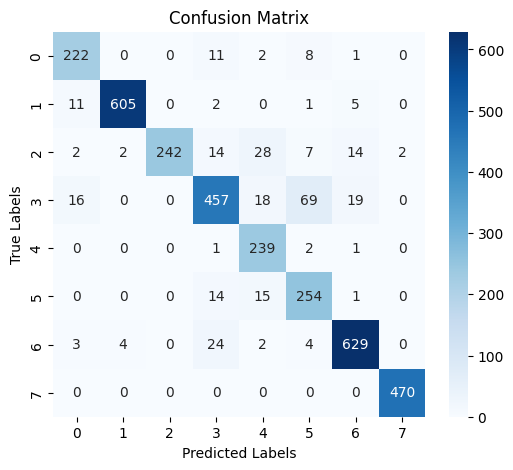

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.91      0.89       244
           1       0.99      0.97      0.98       624
           2       1.00      0.78      0.88       311
           3       0.87      0.79      0.83       579
           4       0.79      0.98      0.87       243
           5       0.74      0.89      0.81       284
           6       0.94      0.94      0.94       666
           7       1.00      1.00      1.00       470

    accuracy                           0.91      3421
   macro avg       0.90      0.91      0.90      3421
weighted avg       0.92      0.91      0.91      3421

F1 Score (Weighted): 0.9118


In [ ]:
evaluate_test_data(model, test_tf_dataset, model_log)
model_collection[model_name] = model_log

In [ ]:
# Save the model
model.save('models/' + model_name + '.keras')

### CNN 4 layers with Maxpool and 128 units in dense layer

In [ ]:
model_name = 'CNN_4_LAYERS_W_MAXPOOL_IN_FINAL_LAYER_DENSE_128_ADAM'

# define the model
model = create_cnn(model_name)

# compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # sparse_categorical_crossentropy is used if labels are integers
    metrics=['accuracy']
)

model.summary()

Model: "CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 64, 64, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 64, 64, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1048576)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │     134,217,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 134,607,304 (513.49 MB)

 Trainable params: 134,607,304 (513.49 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 67s 263ms/step - accuracy: 0.4457 - loss: 4.1245 - val_accuracy: 0.8411 - val_loss: 0.4940
Epoch 2/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 43s 143ms/step - accuracy: 0.8341 - loss: 0.5001 - val_accuracy: 0.8873 - val_loss: 0.3256
Epoch 3/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 42s 148ms/step - accuracy: 0.8796 - loss: 0.3552 - val_accuracy: 0.9025 - val_loss: 0.3014
Epoch 4/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 41s 147ms/step - accuracy: 0.9016 - loss: 0.2852 - val_accuracy: 0.9246 - val_loss: 0.2240
Epoch 5/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 42s 152ms/step - accuracy: 0.9054 - loss: 0.2639 - val_accuracy: 0.9276 - val_loss: 0.2094
Epoch 6/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 40s 148ms/step - accuracy: 0.9253 - loss: 0.2176 - val_accuracy: 0.9322 - val_loss: 0.2123
Epoch 7/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 28s 150ms/step - accuracy: 0.9333 - loss: 0.1975 - val_accuracy: 0.9375 - val_loss: 0.1823
Epoch 8/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 40s 147ms/step - accuracy: 0.9367 - loss: 0

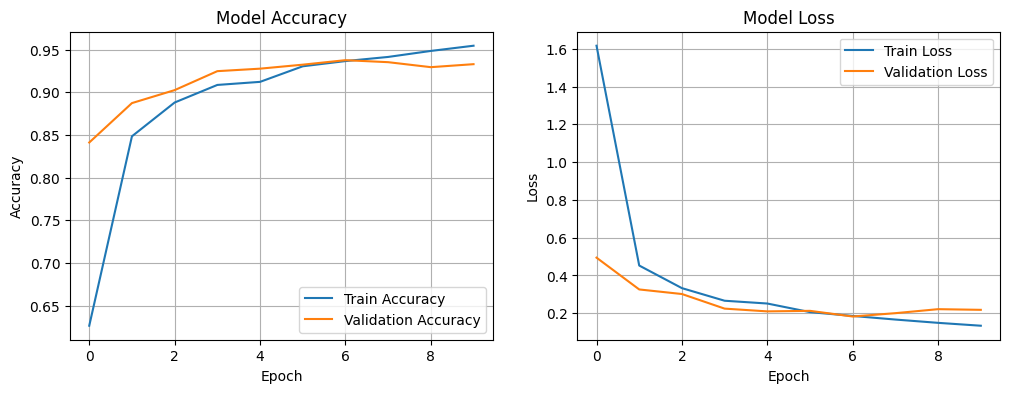

{'Model': 'CNN_4_LAYERS_W_MAXPOOL_IN_FINAL_LAYER_DENSE_128_ADAM', 'Total Parameters': 134607304, 'Training Time': 425.44580936431885, 'GPU Memory Before Training (MB)': 12423, 'GPU Memory Total (MB)': 15360, 'Estimated Model Memory Usage (MB)': 513.4861145019531}


In [ ]:
model_log = evaluate_model(model, train_tf_dataset, val_tf_dataset, model_name, num_epochs=10)
print(model_log)

54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 0.9160 - loss: 0.2796
Test Loss: 0.2559165060520172
Test Accuracy: 0.9193218350410461
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 

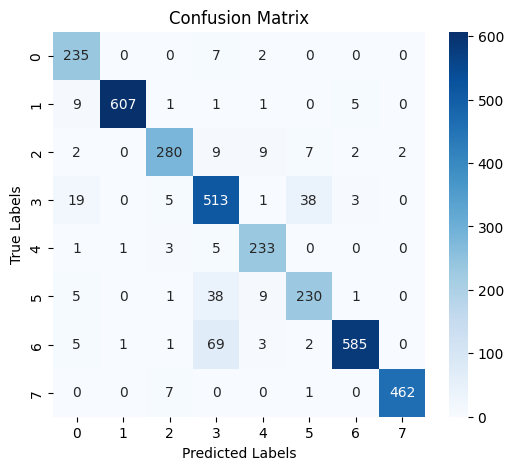

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.96      0.90       244
           1       1.00      0.97      0.98       624
           2       0.94      0.90      0.92       311
           3       0.80      0.89      0.84       579
           4       0.90      0.96      0.93       243
           5       0.83      0.81      0.82       284
           6       0.98      0.88      0.93       666
           7       1.00      0.98      0.99       470

    accuracy                           0.92      3421
   macro avg       0.91      0.92      0.91      3421
weighted avg       0.92      0.92      0.92      3421

F1 Score (Weighted): 0.9203


In [ ]:
evaluate_test_data(model, test_tf_dataset, model_log)
model_collection[model_name] = model_log

In [ ]:
# Save the model
model.save('models/' + model_name + '.keras')

### CNN 4 layers with Maxpool and 256 units in dense layer

In [ ]:
model_name = 'CNN_4_LAYERS_W_MAXPOOL_IN_FINAL_LAYER_DENSE_256_ADAM'

# define the model
model = create_cnn(model_name)

# compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # sparse_categorical_crossentropy is used if labels are integers
    metrics=['accuracy']
)

model.summary()

Model: "CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 64, 64, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 64, 64, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1048576)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │     268,435,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 8)                   │           2,056 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 268,826,184 (1.00 GB)

 Trainable params: 268,826,184 (1.00 GB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 49s 223ms/step - accuracy: 0.4259 - loss: 6.1126 - val_accuracy: 0.7553 - val_loss: 0.6704
Epoch 2/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 70s 182ms/step - accuracy: 0.7738 - loss: 0.6396 - val_accuracy: 0.8563 - val_loss: 0.4060
Epoch 3/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 34s 182ms/step - accuracy: 0.8480 - loss: 0.4222 - val_accuracy: 0.8867 - val_loss: 0.3340
Epoch 4/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 41s 182ms/step - accuracy: 0.8775 - loss: 0.3427 - val_accuracy: 0.8855 - val_loss: 0.3147
Epoch 5/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 41s 183ms/step - accuracy: 0.8980 - loss: 0.2804 - val_accuracy: 0.9065 - val_loss: 0.2669
Epoch 6/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 34s 180ms/step - accuracy: 0.9010 - loss: 0.2692 - val_accuracy: 0.9171 - val_loss: 0.2565
Epoch 7/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 41s 181ms/step - accuracy: 0.9208 - loss: 0.2204 - val_accuracy: 0.9241 - val_loss: 0.2391
Epoch 8/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 41s 181ms/step - accuracy: 0.9279 - loss: 0

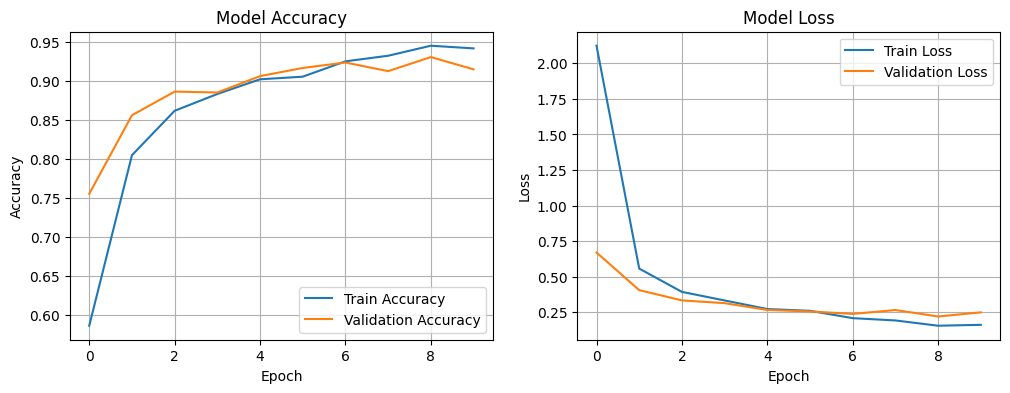

{'Model': 'CNN_4_LAYERS_W_MAXPOOL_IN_FINAL_LAYER_DENSE_256_ADAM', 'Total Parameters': 268826184, 'Training Time': 439.69389963150024, 'GPU Memory Before Training (MB)': 12425, 'GPU Memory Total (MB)': 15360, 'Estimated Model Memory Usage (MB)': 1025.4905090332031}


In [ ]:
model_log = evaluate_model(model, train_tf_dataset, val_tf_dataset, model_name, num_epochs=10)
print(model_log)

54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - accuracy: 0.8978 - loss: 0.3011
Test Loss: 0.27632591128349304
Test Accuracy: 0.909967839717865
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0

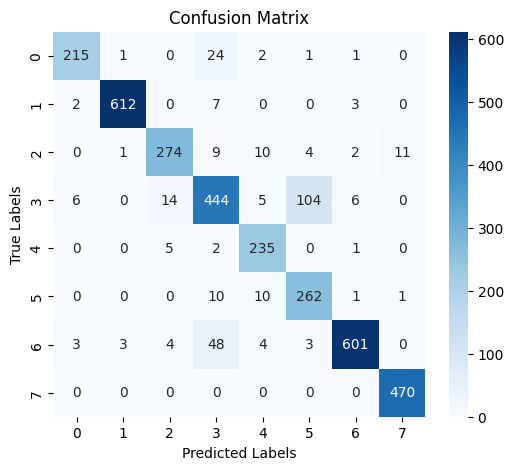

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.88      0.91       244
           1       0.99      0.98      0.99       624
           2       0.92      0.88      0.90       311
           3       0.82      0.77      0.79       579
           4       0.88      0.97      0.92       243
           5       0.70      0.92      0.80       284
           6       0.98      0.90      0.94       666
           7       0.98      1.00      0.99       470

    accuracy                           0.91      3421
   macro avg       0.90      0.91      0.90      3421
weighted avg       0.92      0.91      0.91      3421

F1 Score (Weighted): 0.9110


In [ ]:
evaluate_test_data(model, test_tf_dataset, model_log)
model_collection[model_name] = model_log

In [ ]:
# Save the model
model.save('models/' + model_name + '.keras')

### CNN with 4 layers without maxpool dense layer 512 units

In [ ]:
model_name = 'CNN_4_LAYERS_WO_MAXPOOL_IN_FINAL_LAYER_DENSE_512_ADAM'

# define the model
model = create_cnn(model_name)

# compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # sparse_categorical_crossentropy is used if labels are integers
    metrics=['accuracy']
)

model.summary()

Model: "CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 64, 64, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1048576)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │     536,871,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │           4,104 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 537,263,944 (2.00 GB)

 Trainable params: 537,263,944 (2.00 GB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 85s 344ms/step - accuracy: 0.5059 - loss: 3.9237 - val_accuracy: 0.8621 - val_loss: 0.4109
Epoch 2/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 42s 225ms/step - accuracy: 0.8631 - loss: 0.3933 - val_accuracy: 0.9282 - val_loss: 0.2298
Epoch 3/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 82s 226ms/step - accuracy: 0.9053 - loss: 0.2656 - val_accuracy: 0.9182 - val_loss: 0.2411
Epoch 4/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 82s 226ms/step - accuracy: 0.9290 - loss: 0.2002 - val_accuracy: 0.9270 - val_loss: 0.2187
Epoch 5/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 43s 230ms/step - accuracy: 0.9406 - loss: 0.1615 - val_accuracy: 0.9182 - val_loss: 0.2516
Epoch 6/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 43s 230ms/step - accuracy: 0.9478 - loss: 0.1484 - val_accuracy: 0.9317 - val_loss: 0.2149
Epoch 7/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 43s 230ms/step - accuracy: 0.9523 - loss: 0.1252 - val_accuracy: 0.9287 - val_loss: 0.2555
Epoch 8/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 43s 230ms/step - accuracy: 0.9657 - loss: 0

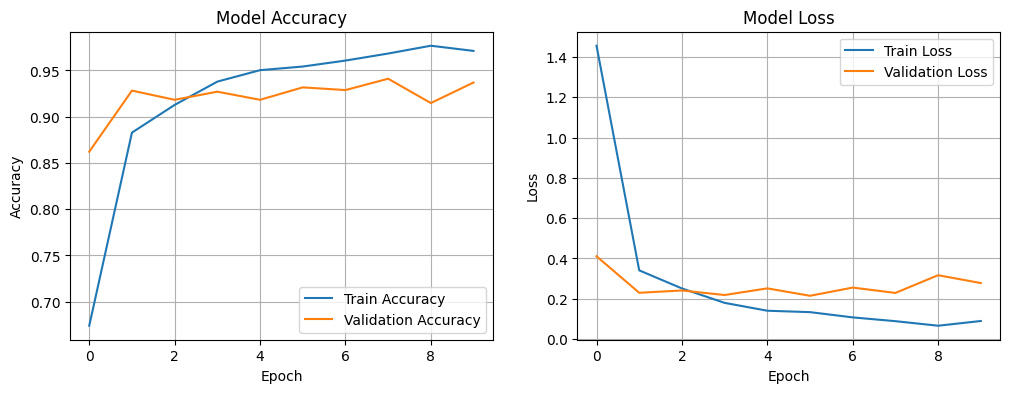

{'Model': 'CNN_4_LAYERS_WO_MAXPOOL_IN_FINAL_LAYER_DENSE_512_ADAM', 'Total Parameters': 537263944, 'Training Time': 627.2222285270691, 'GPU Memory Before Training (MB)': 14089, 'GPU Memory Total (MB)': 15360, 'Estimated Model Memory Usage (MB)': 2049.499298095703}


In [ ]:
model_log = evaluate_model(model, train_tf_dataset, val_tf_dataset, model_name, num_epochs=10)
print(model_log)

54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 122ms/step - accuracy: 0.9280 - loss: 0.2753
Test Loss: 0.278268426656723
Test Accuracy: 0.9301373958587646
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0

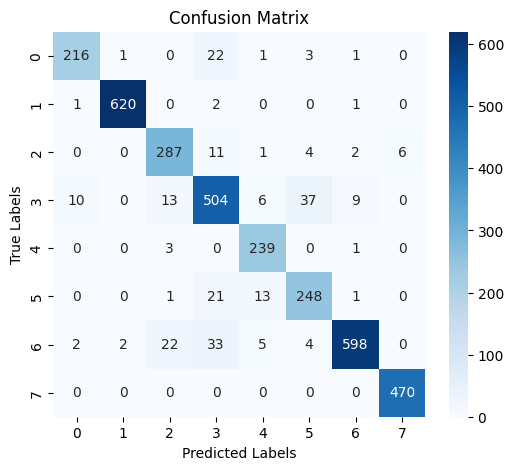

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.89      0.91       244
           1       1.00      0.99      0.99       624
           2       0.88      0.92      0.90       311
           3       0.85      0.87      0.86       579
           4       0.90      0.98      0.94       243
           5       0.84      0.87      0.86       284
           6       0.98      0.90      0.94       666
           7       0.99      1.00      0.99       470

    accuracy                           0.93      3421
   macro avg       0.92      0.93      0.92      3421
weighted avg       0.93      0.93      0.93      3421

F1 Score (Weighted): 0.9304


In [ ]:
evaluate_test_data(model, test_tf_dataset, model_log)
model_collection[model_name] = model_log

In [ ]:
# Save the model
model.save('models/' + model_name + '.keras')

### CNN 4 Layers with maxpool, dense layers 512 units

In [ ]:
model_name = 'CNN_4_LAYERS_W_MAXPOOL_IN_FINAL_LAYER_DENSE_512_ADAM'

# define the model
model = create_cnn(model_name)

# compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # sparse_categorical_crossentropy is used if labels are integers
    metrics=['accuracy']
)

model.summary()

Epoch 1/10


In [ ]:
model_log = evaluate_model(model, train_tf_dataset, val_tf_dataset, model_name, num_epochs=10)
print(model_log)

In [ ]:
evaluate_test_data(model, test_tf_dataset, model_log)
model_collection[model_name] = model_log

In [ ]:
# Save the model
model.save('models/' + model_name + '.keras')

### CNN 4 layers with maxpool, try with batch normalization, 512 units

 batch normalization layers after the convolutional layers and before the activation functions

In [ ]:
model_name = 'CNN_4_LAYERS_W_MAXPOOL_IN_FINAL_LAYER_W_BATCH_NORMALIZATION_DENSE_512_ADAM'

# define the model
model = create_cnn(model_name)

# compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # sparse_categorical_crossentropy is used if labels are integers
    metrics=['accuracy']
)

model.summary()

Epoch 1/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 104s 415ms/step - accuracy: 0.8310 - loss: 0.5145 - val_accuracy: 0.1548 - val_loss: 3.5261
Epoch 2/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 97s 292ms/step - accuracy: 0.9525 - loss: 0.1346 - val_accuracy: 0.5561 - val_loss: 1.6742
Epoch 3/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 82s 291ms/step - accuracy: 0.9779 - loss: 0.0696 - val_accuracy: 0.8540 - val_loss: 0.4796
Epoch 4/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 55s 292ms/step - accuracy: 0.9881 - loss: 0.0440 - val_accuracy: 0.6577 - val_loss: 1.4813
Epoch 5/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 55s 294ms/step - accuracy: 0.9863 - loss: 0.0368 - val_accuracy: 0.6752 - val_loss: 3.3024
Epoch 6/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 83s 297ms/step - accuracy: 0.9896 - loss: 0.0340 - val_accuracy: 0.8248 - val_loss: 0.9200
Epoch 7/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 82s 297ms/step - accuracy: 0.9946 - loss: 0.0173 - val_accuracy: 0.9293 - val_loss: 0.2541
Epoch 8/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 82s 296ms/step - accuracy: 0.9979 - loss: 

In [ ]:
model_log = evaluate_model(model, train_tf_dataset, val_tf_dataset, model_name, num_epochs=10)
print(model_log)

54/54 ━━━━━━━━━━━━━━━━━━━━ 8s 146ms/step - accuracy: 0.9662 - loss: 0.1178
Test Loss: 0.11637289822101593
Test Accuracy: 0.9713534116744995


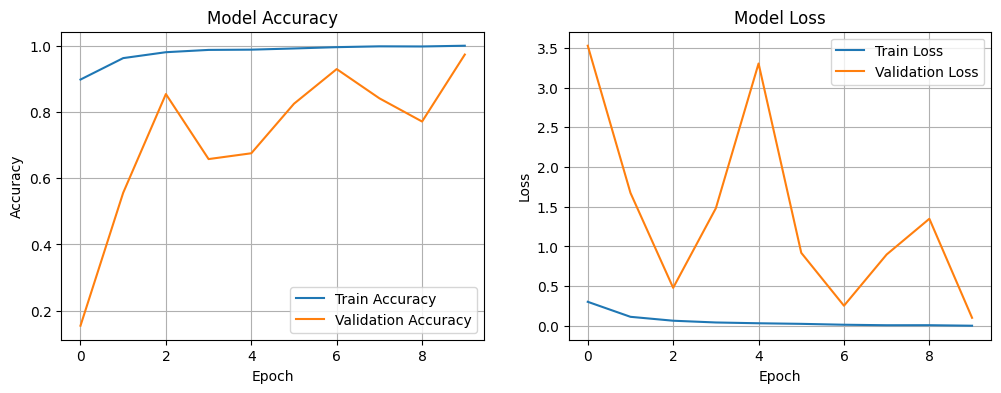

In [ ]:
evaluate_test_data(model, test_tf_dataset, model_log)
model_collection[model_name] = model_log

In [ ]:
# Save the model
model.save('models/' + model_name + '.keras')

## Save Dictionary

do analysis on it later

In [ ]:
model_collection

{'CNN_4_LAYERS_W_MAXPOOL_IN_FINAL_LAYER_DENSE_128_ADAM': {'Model': 'CNN_4_LAYERS_W_MAXPOOL_IN_FINAL_LAYER_DENSE_128_ADAM',
  'Total Parameters': 134607304,
  'Training Time': 425.44580936431885,
  'GPU Memory Before Training (MB)': 12423,
  'GPU Memory Total (MB)': 15360,
  'Estimated Model Memory Usage (MB)': 513.4861145019531,
  'Test Loss': 0.2559165060520172,
  'Test Accuracy': 0.9193218350410461,
  'Test Weighted F1 Score': 0.9202941994844245},
 'CNN_4_LAYERS_W_MAXPOOL_IN_FINAL_LAYER_DENSE_256_ADAM': {'Model': 'CNN_4_LAYERS_W_MAXPOOL_IN_FINAL_LAYER_DENSE_256_ADAM',
  'Total Parameters': 268826184,
  'Training Time': 439.69389963150024,
  'GPU Memory Before Training (MB)': 12425,
  'GPU Memory Total (MB)': 15360,
  'Estimated Model Memory Usage (MB)': 1025.4905090332031,
  'Test Loss': 0.27632591128349304,
  'Test Accuracy': 0.909967839717865,
  'Test Weighted F1 Score': 0.9109563127528163},
 'CNN_3_LAYERS_WO_MAXPOOL_IN_FINAL_LAYER_DENSE_256_ADAM': {'Model': 'CNN_3_LAYERS_WO_MAXPOO

In [ ]:
# Convert the nested dictionary to a DataFrame
df = pd.DataFrame.from_dict(model_collection, orient='index')
df.reset_index(inplace=True, drop=True)
# df.rename(columns={'index': 'model_name'}, inplace=True)
df

Model  Total Parameters  \
0  CNN_4_LAYERS_W_MAXPOOL_IN_FINAL_LAYER_DENSE_12...         134607304   
1  CNN_4_LAYERS_W_MAXPOOL_IN_FINAL_LAYER_DENSE_25...         268826184   
2  CNN_3_LAYERS_WO_MAXPOOL_IN_FINAL_LAYER_DENSE_2...         134313288   

   Training Time  GPU Memory Before Training (MB)  GPU Memory Total (MB)  \
0     425.445809                            12423                  15360   
1     439.693900                            12425                  15360   
2     187.042597                            12425                  15360   

   Estimated Model Memory Usage (MB)  Test Loss  Test Accuracy  \
0                         513.486115   0.255917       0.919322   
1                        1025.490509   0.276326       0.909968   
2                         512.364532   0.285543       0.917568   

   Test Weighted F1 Score  
0                0.920294  
1                0.910956  
2                0.918863

In [ ]:
# save to disk
# df_orig.to_csv('cnn_model_collection.csv', index=False)

In [ ]:
df = pd.read_csv('cnn_model_collection.csv')
df

Model  Total Parameters  \
0   CNN_3_LAYERS_WO_MAXPOOL_IN_FINAL_LAYER_NO_DENS...           4287560   
1   CNN_3_LAYERS_W_MAXPOOL_IN_FINAL_LAYER_NO_DENSE...           4287560   
2   CNN_4_LAYERS_WO_MAXPOOL_IN_FINAL_LAYER_NO_DENS...           8777032   
3   CNN_4_LAYERS_W_MAXPOOL_IN_FINAL_LAYER_NO_DENSE...           8777032   
4   CNN_4_LAYERS_W_MAXPOOL_IN_FINAL_LAYER_W_BATCH_...           8778952   
5   CNN_3_LAYERS_WO_MAXPOOL_IN_FINAL_LAYER_DENSE_1...          67203272   
6   CNN_3_LAYERS_W_MAXPOOL_IN_FINAL_LAYER_DENSE_12...          67203272   
7   CNN_4_LAYERS_WO_MAXPOOL_IN_FINAL_LAYER_DENSE_1...         134607304   
8   CNN_3_LAYERS_W_MAXPOOL_IN_FINAL_LAYER_DENSE_25...         134313288   
9   CNN_4_LAYERS_WO_MAXPOOL_IN_FINAL_LAYER_DENSE_2...         268826184   
10  CNN_4_LAYERS_W_MAXPOOL_IN_FINAL_LAYER_DENSE_12...         134607304   
11  CNN_4_LAYERS_W_MAXPOOL_IN_FINAL_LAYER_DENSE_25...         268826184   
12  CNN_3_LAYERS_WO_MAXPOOL_IN_FINAL_LAYER_DENSE_2...         134313288   

    Training Time  GPU Memory Before Training (MB)  GPU Memory Total (MB)  \
0       99.885872                            14097                  15360   
1       99.449449                            14097                  15360   
2      374.123580                            14097                  15360   
3      360.275112                            14099                  15360   
4      369.387717                            14091                  15360   
5      156.790233                            14091                  15360   
6      153.690530                            14093                  15360   
7      397.963482                            14093                  15360   
8      220.228286                            14093                  15360   
9      445.184476                            14097                  15360   
10     425.445809                            12423                  15360   
11     439.693900                            12425                  15360   
12     187.042597                            12425                  15360   

    Estimated Model Memory Usage (MB)  Test Loss  Test Accuracy  \
0                           16.355743   0.309979       0.908799   
1                           16.355743   0.315988       0.913183   
2                           33.481720   0.267844       0.927507   
3                           33.481720   0.395082       0.867583   
4                           33.489044   1.398644       0.947384   
5                          256.360138   0.269888       0.923707   
6                          256.360138   0.318891       0.907045   
7                          513.486115   0.242569       0.928968   
8                          512.364532   0.373331       0.904706   
9                         1025.490509   0.304179       0.911429   
10                         513.486115   0.255917       0.919322   
11                        1025.490509   0.276326       0.909968   
12                         512.364532   0.285543       0.917568   

    Test Weighted F1 Score  
0                 0.910170  
1                 0.913947  
2                 0.927741  
3                 0.867897  
4                 0.947360  
5                 0.923508  
6                 0.908443  
7                 0.929142  
8                 0.906887  
9                 0.911769  
10                0.920294  
11                0.910956  
12                0.918863

# 3. Chosen CNN model - Experiments on Them


- Learning Rate
- Early Stopping
- Batch Normalization
- Data Augmentation (with and without)
- Number of Epochs to train for
- See how it performs on Classification - Confusion Matrix. Make conclusions.

## Best CNN Model with and without Data Augmentation

### CNN model without data augmentation

In [ ]:
# Define input shape
input_shape = (64, 64, 3)

# Create the CNN model
model = cnn(input_shape=input_shape)

# Print the model summary
model.summary()

Model: "cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 1_conv (Conv2D)                      │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 1_bn (BatchNormalization)            │ (None, 64, 64, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 1_activation (Activation)            │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 2_conv (Conv2D)                      │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 2_bn (BatchNormalization)            │ (None, 64, 64, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 2_activation (Activation)            │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 3_conv (Conv2D)                      │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 3_bn (BatchNormalization)            │ (None, 64, 64, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 3_activation (Activation)            │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 4_conv (Conv2D)                      │ (None, 64, 64, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 4_bn (BatchNormalization)            │ (None, 64, 64, 256)         │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 4_activation (Activation)            │ (None, 64, 64, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 64, 64, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1048576)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │       8,388,616 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,778,952 (33.49 MB)

 Trainable params: 8,777,992 (33.49 MB)

 Non-trainable params: 960 (3.75 KB)

Epoch 1/25
187/187 ━━━━━━━━━━━━━━━━━━━━ 75s 262ms/step - accuracy: 0.5592 - loss: 83.4936 - val_accuracy: 0.3271 - val_loss: 87.6304 - learning_rate: 0.0010
Epoch 2/25
187/187 ━━━━━━━━━━━━━━━━━━━━ 40s 141ms/step - accuracy: 0.8806 - loss: 3.6287 - val_accuracy: 0.4930 - val_loss: 34.1096 - learning_rate: 9.0484e-04
Epoch 3/25
187/187 ━━━━━━━━━━━━━━━━━━━━ 27s 142ms/step - accuracy: 0.8965 - loss: 3.1431 - val_accuracy: 0.5666 - val_loss: 24.6184 - learning_rate: 7.4082e-04
Epoch 4/25
187/187 ━━━━━━━━━━━━━━━━━━━━ 41s 142ms/step - accuracy: 0.9289 - loss: 1.6027 - val_accuracy: 0.9311 - val_loss: 1.4113 - learning_rate: 5.4881e-04
Epoch 5/25
187/187 ━━━━━━━━━━━━━━━━━━━━ 42s 147ms/step - accuracy: 0.9447 - loss: 1.0617 - val_accuracy: 0.9387 - val_loss: 1.6058 - learning_rate: 3.6788e-04
Epoch 6/25
187/187 ━━━━━━━━━━━━━━━━━━━━ 40s 143ms/step - accuracy: 0.9616 - loss: 0.6417 - val_accuracy: 0.9574 - val_loss: 1.0314 - learning_rate: 2.2313e-04
Epoch 7/25
187/187 ━━━━━━━━━━━━━━━━━━━━ 41s 14

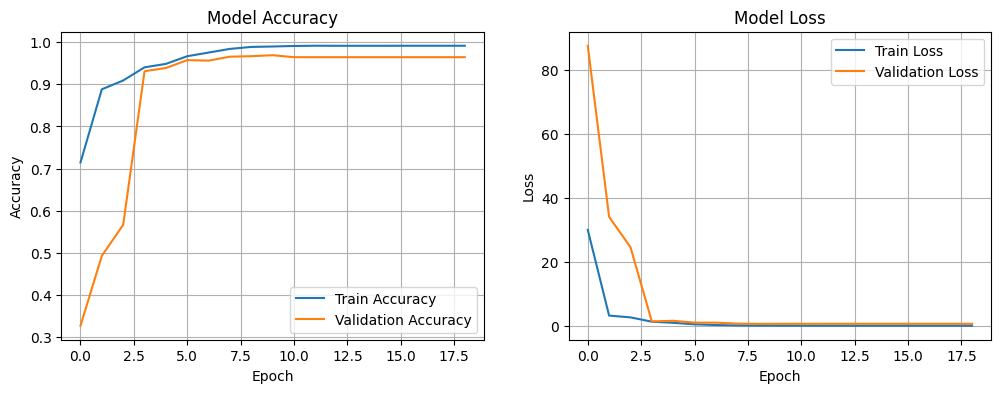

In [ ]:
# Train model
trained_model, history = train_adam(
    model=model,
    train_dataset=train_tf_dataset,
    val_dataset=val_tf_dataset,
    test_dataset=test_tf_dataset,
    epochs=25,
    learning_rate=0.001,
    # patience = 10, # Stop if validation loss doesn't improve for 10 epochs,
    # reduce_lr_patience=5,  # Reduce LR after 5 epochs of no improvement
    # factor=0.2  # Reduce LR by a factor of 0.2 (new_lr = lr * 0.2)
)


In [ ]:
# Save the model
model.save('pre-trained/cnn_wo_data_aug.keras')

In [ ]:
# Get predictions
y_pred = model.predict(test_tf_dataset)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels
y_true = np.concatenate([y for x, y in test_tf_dataset], axis=0)
y_true_classes = y_true.flatten()  # Convert one-hot encoded labels to class indices

# Compute F1 score
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')  # Weighted F1 for multiclass classification
print(f"Test F1 Score: {f1:.4f}")

54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step
Test F1 Score: 0.9597


In [ ]:
# Compute the classification report
print(classification_report(y_true_classes, y_pred_classes))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97       244
           1       1.00      1.00      1.00       624
           2       0.96      0.97      0.96       311
           3       0.90      0.92      0.91       579
           4       0.96      0.95      0.95       243
           5       0.91      0.89      0.90       284
           6       0.97      0.96      0.96       666
           7       1.00      1.00      1.00       470

    accuracy                           0.96      3421
   macro avg       0.96      0.96      0.96      3421
weighted avg       0.96      0.96      0.96      3421



### CNN model with data augmentation

In [ ]:
# Define input shape
input_shape = (64, 64, 3)

# Create the CNN model
model = cnn(input_shape=input_shape)

# Print the model summary
model.summary()

Model: "cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 1_conv (Conv2D)                      │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 1_bn (BatchNormalization)            │ (None, 64, 64, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 1_activation (Activation)            │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 2_conv (Conv2D)                      │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 2_bn (BatchNormalization)            │ (None, 64, 64, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 2_activation (Activation)            │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 3_conv (Conv2D)                      │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 3_bn (BatchNormalization)            │ (None, 64, 64, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 3_activation (Activation)            │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 4_conv (Conv2D)                      │ (None, 64, 64, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 4_bn (BatchNormalization)            │ (None, 64, 64, 256)         │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 4_activation (Activation)            │ (None, 64, 64, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 64, 64, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1048576)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 8)                   │       8,388,616 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,778,952 (33.49 MB)

 Trainable params: 8,777,992 (33.49 MB)

 Non-trainable params: 960 (3.75 KB)

Epoch 1/25
292/292 ━━━━━━━━━━━━━━━━━━━━ 81s 205ms/step - accuracy: 0.6058 - loss: 65.4671 - val_accuracy: 0.2815 - val_loss: 96.6768 - learning_rate: 0.0010
Epoch 2/25
292/292 ━━━━━━━━━━━━━━━━━━━━ 46s 139ms/step - accuracy: 0.8599 - loss: 5.4451 - val_accuracy: 0.5438 - val_loss: 33.0020 - learning_rate: 9.0484e-04
Epoch 3/25
292/292 ━━━━━━━━━━━━━━━━━━━━ 40s 137ms/step - accuracy: 0.9034 - loss: 3.8355 - val_accuracy: 0.1355 - val_loss: 266.1945 - learning_rate: 7.4082e-04
Epoch 4/25
292/292 ━━━━━━━━━━━━━━━━━━━━ 41s 137ms/step - accuracy: 0.9237 - loss: 2.6916 - val_accuracy: 0.6986 - val_loss: 11.1525 - learning_rate: 5.4881e-04
Epoch 5/25
292/292 ━━━━━━━━━━━━━━━━━━━━ 41s 137ms/step - accuracy: 0.9442 - loss: 1.3627 - val_accuracy: 0.3727 - val_loss: 76.1242 - learning_rate: 3.6788e-04
Epoch 6/25
292/292 ━━━━━━━━━━━━━━━━━━━━ 40s 137ms/step - accuracy: 0.9389 - loss: 1.9309 - val_accuracy: 0.7938 - val_loss: 8.3586 - learning_rate: 2.2313e-04
Epoch 7/25
292/292 ━━━━━━━━━━━━━━━━━━━━ 41s

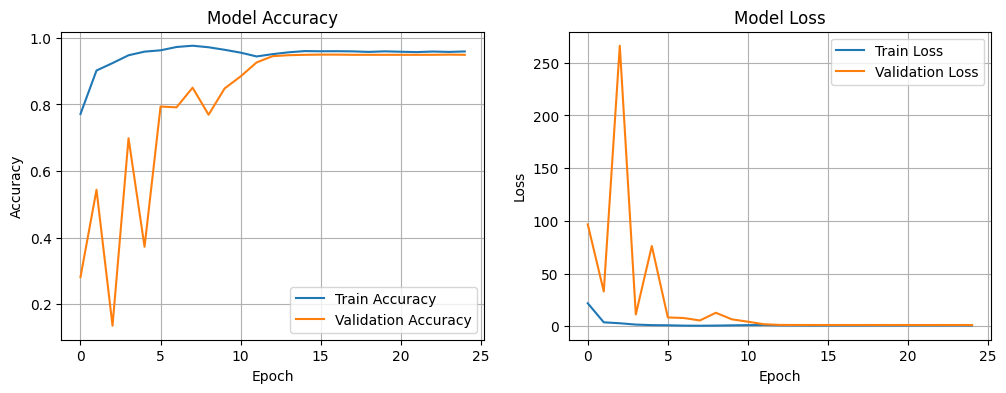

In [ ]:
# Train model
trained_model, history = train_adam(
    model=model,
    train_dataset=train_tf_dataset,
    val_dataset=val_tf_dataset,
    test_dataset=test_tf_dataset,
    epochs=25,
    learning_rate=0.001,
    # patience = 10, # Stop if validation loss doesn't improve for 10 epochs,
    # reduce_lr_patience=5,  # Reduce LR after 5 epochs of no improvement
    # factor=0.2  # Reduce LR by a factor of 0.2 (new_lr = lr * 0.2)
)


In [ ]:
# Save the model
model.save('pre-trained/cnn_data_aug.keras')

In [ ]:
# Get predictions
y_pred = model.predict(test_tf_dataset)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels
y_true = np.concatenate([y for x, y in test_tf_dataset], axis=0)
y_true_classes = y_true.flatten()  # Convert one-hot encoded labels to class indices

# Compute F1 score
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')  # Weighted F1 for multiclass classification
print(f"Test F1 Score: {f1:.4f}")

54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step
Test F1 Score: 0.9506


In [ ]:
# Compute the classification report
print(classification_report(y_true_classes, y_pred_classes))

              precision    recall  f1-score   support

           0       0.91      0.99      0.95       244
           1       0.99      1.00      0.99       624
           2       0.97      0.98      0.98       311
           3       0.94      0.80      0.87       579
           4       0.96      0.98      0.97       243
           5       0.79      0.96      0.87       284
           6       0.97      0.96      0.96       666
           7       1.00      1.00      1.00       470

    accuracy                           0.95      3421
   macro avg       0.94      0.96      0.95      3421
weighted avg       0.95      0.95      0.95      3421



# CNN

The architecture of the CNN is the following:
- Input Layer: Output Shape (64,64,3)
- 1st Convolution Block:
  - 2D Convolution Layer with 32 filters: Output Shape (64,64,32)
  - Batch normalization
  - ReLU Activation Function
- Pooling with padding 'same': Output Shape (64,64,32)
- 2nd Convolution Block:
  - 2D Convolution Layer with 64 filters: Output Shape (64,64,64)
  - Batch normalization
  - ReLU Activation Function
- Pooling with padding 'same': Output Shape (64,64,64)
- 3rd Convolution Block:
  - 2D Convolution Layer with 128 filters: Output Shape (64,64,128)
  - Batch normalization
  - ReLU Activation Function
- Pooling with padding 'same': Output Shape (64,64,128)
- 4th Convolution Block:
  - 2D Convolution Layer with 256 filters: Output Shape (64,64,256)
  - Batch normalization
  - ReLU Activation Function
- Pooling with padding 'same': Output Shape (64,64,256)
- Flatten Layer: Output Shape (64×64×256,)
- Output layer: Output Shape (8,)

In [ ]:
# Define input shape
input_shape = (64, 64, 3)

# Create the CNN model
model = cnn(input_shape=input_shape)

# Print the model summary
model.summary()

Model: "cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 1_conv (Conv2D)                      │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 1_bn (BatchNormalization)            │ (None, 64, 64, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 1_activation (Activation)            │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 2_conv (Conv2D)                      │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 2_bn (BatchNormalization)            │ (None, 64, 64, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 2_activation (Activation)            │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 3_conv (Conv2D)                      │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 3_bn (BatchNormalization)            │ (None, 64, 64, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 3_activation (Activation)            │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 4_conv (Conv2D)                      │ (None, 64, 64, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 4_bn (BatchNormalization)            │ (None, 64, 64, 256)         │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 4_activation (Activation)            │ (None, 64, 64, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 64, 64, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1048576)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 8)                   │       8,388,616 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,778,952 (33.49 MB)

 Trainable params: 8,777,992 (33.49 MB)

 Non-trainable params: 960 (3.75 KB)

Epoch 1/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 67s 256ms/step - accuracy: 0.5320 - loss: 98.2061 - val_accuracy: 0.1390 - val_loss: 102.0762 - learning_rate: 0.0010
Epoch 2/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 42s 132ms/step - accuracy: 0.8631 - loss: 3.8222 - val_accuracy: 0.2634 - val_loss: 97.0403 - learning_rate: 9.0484e-04
Epoch 3/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 41s 135ms/step - accuracy: 0.8915 - loss: 3.3918 - val_accuracy: 0.5847 - val_loss: 28.3069 - learning_rate: 7.4082e-04
Epoch 4/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 41s 135ms/step - accuracy: 0.9312 - loss: 2.0004 - val_accuracy: 0.8995 - val_loss: 2.9162 - learning_rate: 5.4881e-04
Epoch 5/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 41s 136ms/step - accuracy: 0.9468 - loss: 1.1077 - val_accuracy: 0.9422 - val_loss: 1.3215 - learning_rate: 3.6788e-04
Epoch 6/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 41s 136ms/step - accuracy: 0.9544 - loss: 0.7333 - val_accuracy: 0.9498 - val_loss: 1.3064 - learning_rate: 2.2313e-04
Epoch 7/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 41s 1

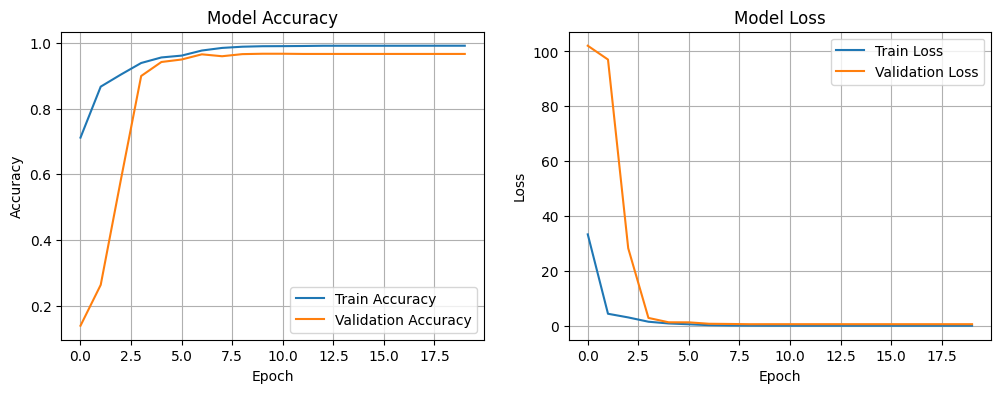

In [ ]:
# Set seeds for reproducibility
np.random.seed(42)

# Train model
trained_model, history = train_adam(
    model=model,
    train_dataset=train_tf_dataset,
    val_dataset=val_tf_dataset,
    test_dataset=test_tf_dataset,
    epochs=20,
    learning_rate=0.001
)


In [ ]:
# Save the model
model.save('pre-trained/cnn.keras')

## Performance assessment

In [ ]:
# If necessary, load the model
model = load_model('pre-trained/cnn.keras')

In [ ]:
# Get predictions
y_pred = model.predict(test_tf_dataset)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels
y_true = np.concatenate([y for x, y in test_tf_dataset], axis=0)
y_true_classes = y_true.flatten()  # Convert one-hot encoded labels to class indices

# Compute F1 score
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')  # Weighted F1 for multiclass classification
print(f"Test F1 Score: {f1:.4f}")

54/54 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step
Test F1 Score: 0.9643


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Precision: 0.96
Recall: 0.96
F1 Score: 0.96


## Understanding the Misclassifications by the Model

In [ ]:
# Compute the classification report
print(classification_report(y_true, y_pred_classes))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       244
           1       1.00      1.00      1.00       624
           2       0.96      0.97      0.97       311
           3       0.93      0.91      0.92       579
           4       0.98      0.95      0.96       243
           5       0.90      0.93      0.91       284
           6       0.96      0.97      0.97       666
           7       1.00      1.00      1.00       470

    accuracy                           0.96      3421
   macro avg       0.96      0.96      0.96      3421
weighted avg       0.96      0.96      0.96      3421



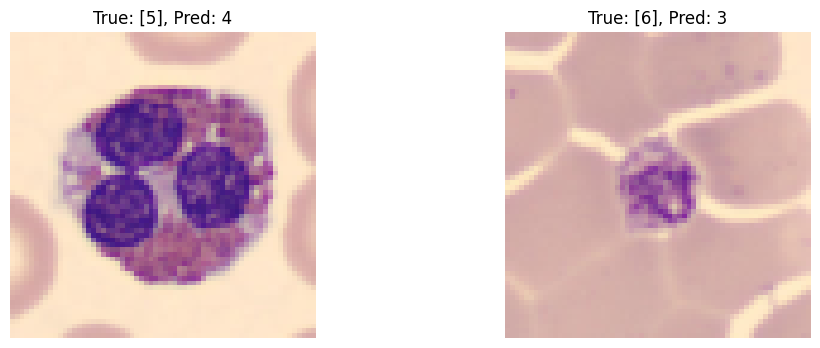

In [ ]:
def identify_misclassified_images(test_dataset, y_true, y_pred_classes):
    """
    Identify misclassified images along with their true and predicted labels.

    Parameters:
    - test_dataset: Dataset containing test images.
    - y_true: Array of true labels.
    - y_pred_classes: Array of predicted labels.

    Returns:
    - misclassified_images: List of misclassified image tensors.
    - misclassified_true_labels: Array of true labels for misclassified images.
    - misclassified_pred_labels: Array of predicted labels for misclassified images.
    """
    misclassified_images = []
    misclassified_true_labels = []
    misclassified_pred_labels = []

    # Ensure the dataset and labels are consistent
    if len(y_true) != len(y_pred_classes):
        raise ValueError("Length of y_true and y_pred_classes must match.")

    # Iterate through the dataset in batches
    for batch_images, batch_labels in test_dataset:
        batch_predictions = y_pred_classes[:len(batch_images)]  # Slice predictions for the current batch
        batch_true_labels = y_true[:len(batch_images)]  # Slice true labels for the current batch

        for i in range(len(batch_images)):
            if batch_true_labels[i] != batch_predictions[i]:
                misclassified_images.append(batch_images[i])
                misclassified_true_labels.append(batch_true_labels[i])
                misclassified_pred_labels.append(batch_predictions[i])

    return misclassified_images, np.array(misclassified_true_labels), np.array(misclassified_pred_labels)


def select_one_misclassified_per_class(misclassified_images, misclassified_true_labels, misclassified_pred_labels):
    """
    Select one misclassified image per class.

    Parameters:
    - misclassified_images: List of misclassified image tensors.
    - misclassified_true_labels: Array of true labels for misclassified images.
    - misclassified_pred_labels: Array of predicted labels for misclassified images.

    Returns:
    - misclassified_samples: Dictionary containing one sample per true label.
    """
    misclassified_samples = {}

    for label in np.unique(misclassified_true_labels):
        # Find indices for this true label
        indices = [i for i in range(len(misclassified_true_labels)) if misclassified_true_labels[i] == label]
        if indices:
            sample_index = random.choice(indices)  # Pick one random example
            misclassified_samples[label] = {
                "image": misclassified_images[sample_index],
                "true_label": misclassified_true_labels[sample_index],
                "pred_label": misclassified_pred_labels[sample_index]
            }

    return misclassified_samples


def plot_misclassified_samples(misclassified_samples):
    """
    Plot one misclassified image per class.

    Parameters:
    - misclassified_samples: Dictionary containing one sample per true label.
    """
    plt.figure(figsize=(15, 10))
    for i, (true_label, sample) in enumerate(misclassified_samples.items()):
        plt.subplot(3, 3, i + 1)  # Adjust subplot grid size as needed
        plt.imshow(sample["image"].numpy().squeeze(), cmap='gray')  # Adjust for color images if needed
        plt.title(f"True: {sample['true_label']}, Pred: {sample['pred_label']}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


# Assuming test_dataset, y_true, and y_pred_classes are available
misclassified_images, misclassified_true_labels, misclassified_pred_labels = identify_misclassified_images(
    test_tf_dataset, y_true, y_pred_classes
)

misclassified_samples = select_one_misclassified_per_class(
    misclassified_images, misclassified_true_labels, misclassified_pred_labels
)

plot_misclassified_samples(misclassified_samples)


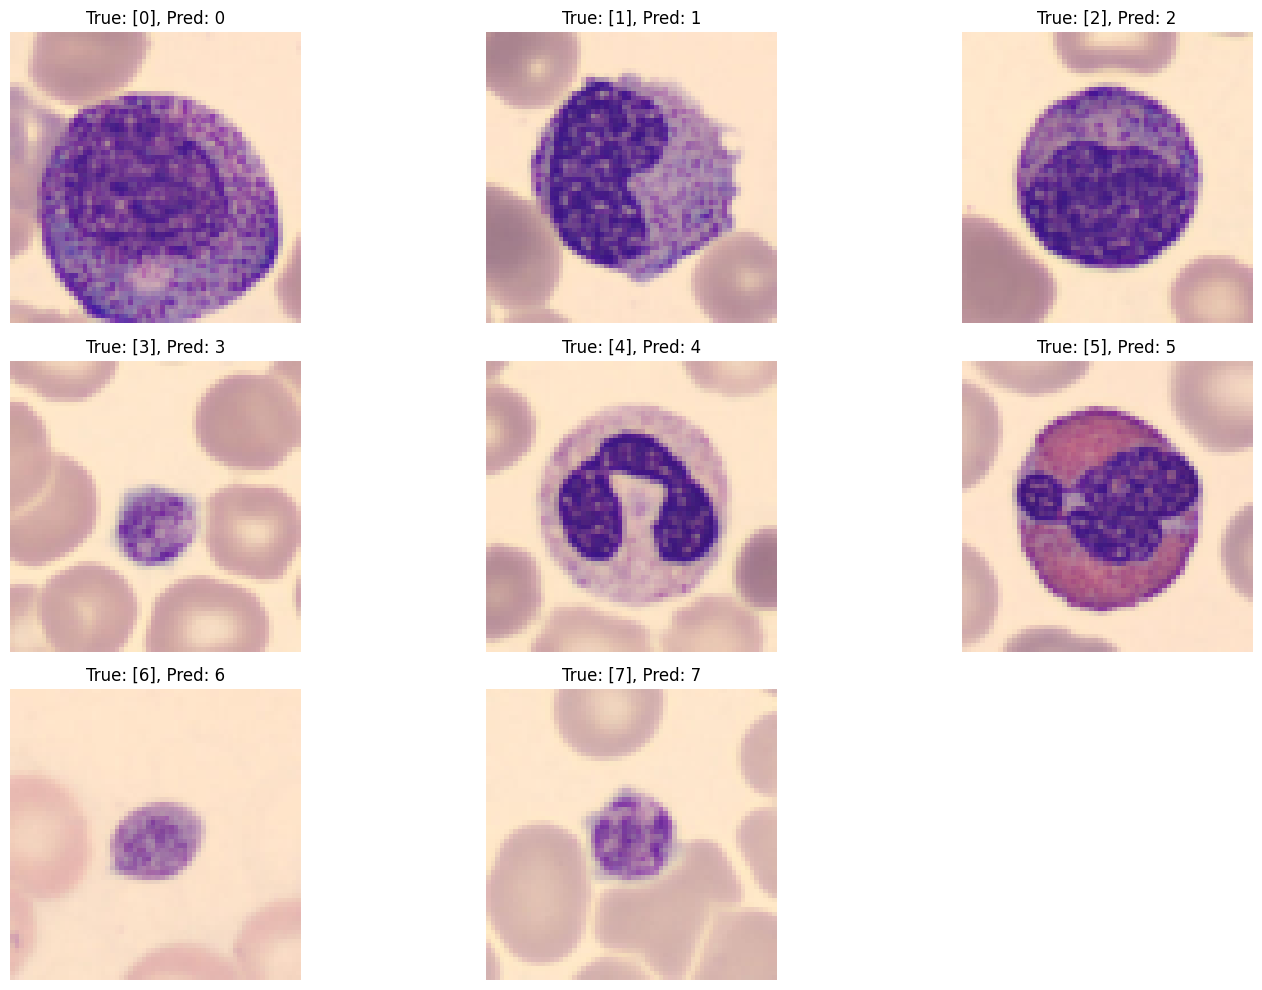

In [ ]:
def identify_correctly_predicted_images(test_dataset, y_true, y_pred_classes):
    """
    Identify correctly predicted images along with their true and predicted labels.

    Parameters:
    - test_dataset: Dataset containing test images.
    - y_true: Array of true labels.
    - y_pred_classes: Array of predicted labels.

    Returns:
    - correctly_predicted_images: List of correctly predicted image tensors.
    - correctly_predicted_true_labels: Array of true labels for correctly predicted images.
    - correctly_predicted_pred_labels: Array of predicted labels for correctly predicted images.
    """
    correctly_predicted_images = []
    correctly_predicted_true_labels = []
    correctly_predicted_pred_labels = []

    # Ensure the dataset and labels are consistent
    if len(y_true) != len(y_pred_classes):
        raise ValueError("Length of y_true and y_pred_classes must match.")

    # Iterate through the dataset in batches
    for batch_images, batch_labels in test_dataset:
        batch_predictions = y_pred_classes[:len(batch_images)]  # Slice predictions for the current batch
        batch_true_labels = y_true[:len(batch_images)]  # Slice true labels for the current batch

        for i in range(len(batch_images)):
            if batch_true_labels[i] == batch_predictions[i]:
                correctly_predicted_images.append(batch_images[i])
                correctly_predicted_true_labels.append(batch_true_labels[i])
                correctly_predicted_pred_labels.append(batch_predictions[i])

    return correctly_predicted_images, np.array(correctly_predicted_true_labels), np.array(correctly_predicted_pred_labels)


def select_one_correctly_predicted_per_class(correctly_predicted_images, correctly_predicted_true_labels, correctly_predicted_pred_labels):
    """
    Select one correctly predicted image per class.

    Parameters:
    - correctly_predicted_images: List of correctly predicted image tensors.
    - correctly_predicted_true_labels: Array of true labels for correctly predicted images.
    - correctly_predicted_pred_labels: Array of predicted labels for correctly predicted images.

    Returns:
    - correctly_predicted_samples: Dictionary containing one sample per true label.
    """
    correctly_predicted_samples = {}

    for label in np.unique(correctly_predicted_true_labels):
        # Find indices for this true label
        indices = [i for i in range(len(correctly_predicted_true_labels)) if correctly_predicted_true_labels[i] == label]
        if indices:
            sample_index = random.choice(indices)  # Pick one random example
            correctly_predicted_samples[label] = {
                "image": correctly_predicted_images[sample_index],
                "true_label": correctly_predicted_true_labels[sample_index],
                "pred_label": correctly_predicted_pred_labels[sample_index]
            }

    return correctly_predicted_samples


def plot_correctly_predicted_samples(correctly_predicted_samples):
    """
    Plot one correctly predicted image per class.

    Parameters:
    - correctly_predicted_samples: Dictionary containing one sample per true label.
    """
    plt.figure(figsize=(15, 10))
    for i, (true_label, sample) in enumerate(correctly_predicted_samples.items()):
        plt.subplot(3, 3, i + 1)  # Adjust subplot grid size as needed
        plt.imshow(sample["image"].numpy().squeeze(), cmap='gray')  # Adjust for color images if needed
        plt.title(f"True: {sample['true_label']}, Pred: {sample['pred_label']}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


# Assuming test_dataset, y_true, and y_pred_classes are available
correctly_predicted_images, correctly_predicted_true_labels, correctly_predicted_pred_labels = identify_correctly_predicted_images(
    test_tf_dataset, y_true, y_pred_classes
)

correctly_predicted_samples = select_one_correctly_predicted_per_class(
    correctly_predicted_images, correctly_predicted_true_labels, correctly_predicted_pred_labels
)

plot_correctly_predicted_samples(correctly_predicted_samples)


# Dilated CNN

This is just the previous CNN with ``dilation_rate=(1,2)``.

In [ ]:
# Define input shape
input_shape = (64, 64, 3)

# Create the Dilated CNN model
model = dilated_cnn(input_shape=input_shape)

# Print the model summary
model.summary()

Model: "dilated_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 1_conv (Conv2D)                      │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 1_bn (BatchNormalization)            │ (None, 64, 64, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 1_activation (Activation)            │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 2_conv (Conv2D)                      │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 2_bn (BatchNormalization)            │ (None, 64, 64, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 2_activation (Activation)            │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_24 (MaxPooling2D)      │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 3_conv (Conv2D)                      │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 3_bn (BatchNormalization)            │ (None, 64, 64, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 3_activation (Activation)            │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_25 (MaxPooling2D)      │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 4_conv (Conv2D)                      │ (None, 64, 64, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 4_bn (BatchNormalization)            │ (None, 64, 64, 256)         │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 4_activation (Activation)            │ (None, 64, 64, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_26 (MaxPooling2D)      │ (None, 64, 64, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 1048576)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 8)                   │       8,388,616 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,778,952 (33.49 MB)

 Trainable params: 8,777,992 (33.49 MB)

 Non-trainable params: 960 (3.75 KB)

Epoch 1/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 65s 251ms/step - accuracy: 0.5571 - loss: 105.7537 - val_accuracy: 0.1373 - val_loss: 220.8728 - learning_rate: 0.0010
Epoch 2/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 49s 157ms/step - accuracy: 0.8599 - loss: 5.3775 - val_accuracy: 0.2126 - val_loss: 95.5194 - learning_rate: 9.0484e-04
Epoch 3/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 43s 167ms/step - accuracy: 0.9131 - loss: 2.6351 - val_accuracy: 0.8563 - val_loss: 9.1207 - learning_rate: 7.4082e-04
Epoch 4/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 40s 164ms/step - accuracy: 0.9307 - loss: 2.0446 - val_accuracy: 0.9025 - val_loss: 2.5817 - learning_rate: 5.4881e-04
Epoch 5/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 42s 168ms/step - accuracy: 0.9453 - loss: 0.9566 - val_accuracy: 0.9334 - val_loss: 1.8182 - learning_rate: 3.6788e-04
Epoch 6/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 40s 163ms/step - accuracy: 0.9636 - loss: 0.6519 - val_accuracy: 0.9620 - val_loss: 0.9775 - learning_rate: 2.2313e-04
Epoch 7/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 41s 1

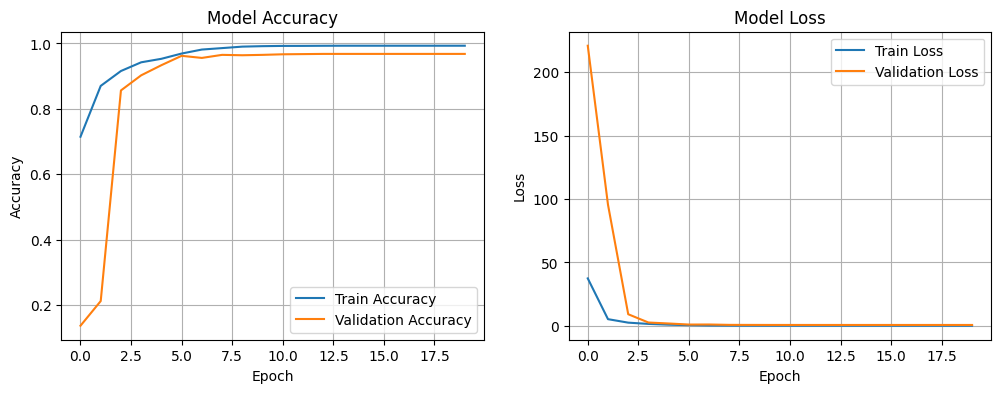

In [ ]:
# Set seeds for reproducibility
np.random.seed(42)

# Train model
trained_model, history = train_adam(
    model=model,
    train_dataset=train_tf_dataset,
    val_dataset=val_tf_dataset,
    test_dataset=test_tf_dataset,
    epochs=20,
    learning_rate=0.001
)

In [ ]:
# Save the model
model.save('pre-trained/dilated_cnn.keras')

## Performance assessment

In [ ]:
# If necessary, load the model
model = load_model('pre-trained/dilated_cnn.keras')

In [ ]:
# Get predictions
y_pred = model.predict(test_tf_dataset)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class indices

# Get true labels
y_true = np.concatenate([y for x, y in test_tf_dataset], axis=0)
y_true_classes = y_true.flatten()  # Convert one-hot encoded labels to class indices

# Compute F1 score
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')  # Weighted F1 for multiclass classification
print(f"Test F1 Score: {f1:.4f}")

54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step
Test F1 Score: 0.9637


In [ ]:
# Compute the classification report
print(classification_report(y_true_classes, y_pred_classes))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       244
           1       0.99      1.00      0.99       624
           2       0.96      0.97      0.97       311
           3       0.93      0.90      0.92       579
           4       0.98      0.96      0.97       243
           5       0.90      0.93      0.92       284
           6       0.97      0.97      0.97       666
           7       1.00      1.00      1.00       470

    accuracy                           0.96      3421
   macro avg       0.96      0.96      0.96      3421
weighted avg       0.96      0.96      0.96      3421



# ResNet

For the ResNet34, Residual Block are introduced as block with shortcut connections (or residual connections) that allows the input to bypass some layers. Their structure is:
- Identity Block: 2 2D Convolution Layers and then the sum of the input wiht the Output of the convolutions.
- Convolution Block: Just a convolution with stride 2 to reduce the spatial dimensions and increase the number of channels.

Using these blocks, the architecture of ResNet34 is the architecture proposed in https://arxiv.org/pdf/1512.03385:
- Input Layer: Output Shape (64,64,3)
- Zero-padding: Add 3 pixels on every side. Output Shape (70,70,3)
- Initial Convolution Layer:
  - 7×7 2D Convolution Layer with 64 filters, stride 2: Output Shape (64,64,32).
  - Batch Normalization
  - ReLU Activation
- Max Pooling with stride 2: Output Shape (16,16,64)
- Block 1: Output Shape (16,16,64)
  - 3 identity blocks with 64 filters each.
- Block 2: Output Shape (8,8,128)
  - Convolution Block with 128 filters and stride 2: Output Shape (8,8,128).
  - 3 identity blocks with 128 filters.
- Block 3: Output Shape (4,4,256)
  - Convolution Block with 256 filters and stride 2: Output Shape (4,4,256)
  - 5 identity blocks with 256 filters
- Block 4: Output Shape (2,2,256)
  - Convolution Block with 512 filters and stride 2: Output Shape (2,2,512)
  - 2 identity blocks with 512 filters
- Global Average Pooling: Output Shape (512,)
- Output Layer: Output Shape (8,)

In [ ]:
# Define input shape
input_shape = (64, 64, 3)

# Create the ResNet model
model = resnet34(input_shape = input_shape)

# Print the model summary
model.summary()

Model: "ResNet34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 64, 64, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 70, 70, 3)      │              0 │ input_layer_1[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 32, 32, 64)     │          9,472 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 32, 32, 64)     │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 32, 32, 64)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 16, 16, 64)     │              0 │ activation[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 16, 16, 64)     │         36,928 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 16, 16, 64)     │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 16, 16, 64)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 16, 16, 64)     │         36,928 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 16, 16, 64)     │            256 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 16, 16, 64)     │              0 │ batch_normalization_2… │
│                           │                        │                │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 16, 16, 64)     │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 16, 16, 64)     │         36,928 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 16, 16, 64)     │            256 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activat

 Total params: 21,314,312 (81.31 MB)

 Trainable params: 21,297,288 (81.24 MB)

 Non-trainable params: 17,024 (66.50 KB)

Epoch 1/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 44s 135ms/step - accuracy: 0.4559 - loss: 1.5672 - val_accuracy: 0.1688 - val_loss: 2.3920 - learning_rate: 0.0010
Epoch 2/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - accuracy: 0.7883 - loss: 0.6023 - val_accuracy: 0.2518 - val_loss: 2.6254 - learning_rate: 9.0484e-04
Epoch 3/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.8712 - loss: 0.3724 - val_accuracy: 0.6215 - val_loss: 1.1187 - learning_rate: 7.4082e-04
Epoch 4/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - accuracy: 0.9265 - loss: 0.2403 - val_accuracy: 0.8213 - val_loss: 0.4844 - learning_rate: 5.4881e-04
Epoch 5/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - accuracy: 0.9671 - loss: 0.1613 - val_accuracy: 0.8481 - val_loss: 0.4074 - learning_rate: 3.6788e-04
Epoch 6/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.9799 - loss: 0.1274 - val_accuracy: 0.8633 - val_loss: 0.3663 - learning_rate: 2.2313e-04
Epoch 7/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - accu

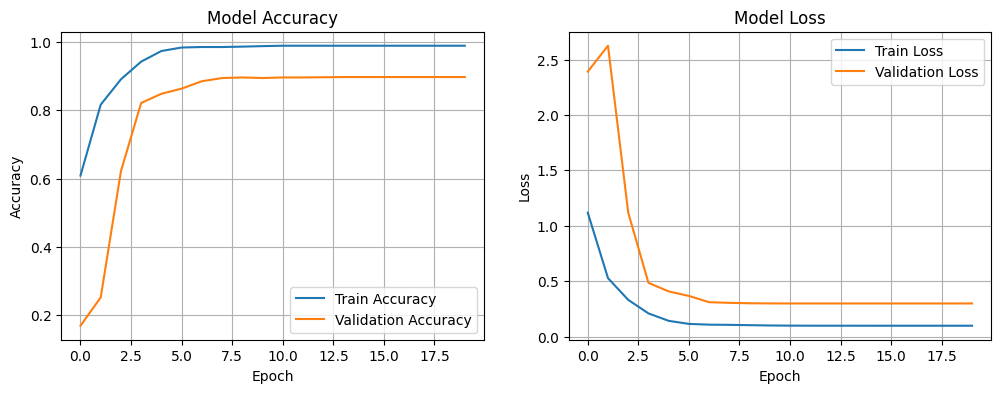

In [ ]:
# Set seeds for reproducibility
np.random.seed(42)

# Train model
trained_model, history = train_sgd(
    model=model,
    train_dataset=train_tf_dataset,
    val_dataset=val_tf_dataset,
    test_dataset=test_tf_dataset,
    epochs=20,
    learning_rate=0.001
)

In [ ]:
# Save the model
model.save('pre-trained/resnet.keras')

## Performance assessment

In [ ]:
# If necessary, load the model
model = load_model('pre-trained/resnet.keras')

In [ ]:
# Get predictions
y_pred = model.predict(test_tf_dataset)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class indices

# Get true labels
y_true = np.concatenate([y for x, y in test_tf_dataset], axis=0)
y_true_classes = y_true.flatten()  # Convert one-hot encoded labels to class indices

# Compute F1 score
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')  # Weighted F1 for multiclass classification
print(f"Test F1 Score: {f1:.4f}")

54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step
Test F1 Score: 0.8831


In [ ]:
# Compute the classification report
print(classification_report(y_true_classes, y_pred_classes))

              precision    recall  f1-score   support

           0       0.83      0.77      0.80       244
           1       0.95      0.96      0.95       624
           2       0.93      0.87      0.90       311
           3       0.74      0.77      0.76       579
           4       0.91      0.88      0.90       243
           5       0.76      0.71      0.74       284
           6       0.91      0.95      0.93       666
           7       0.99      1.00      0.99       470

    accuracy                           0.88      3421
   macro avg       0.88      0.86      0.87      3421
weighted avg       0.88      0.88      0.88      3421



# VGG

The architecture of the VGG is the following:
- Input Layer: Output Shape (64,64,3)
- 1st Block:
  - 2D Convolution Layer with 32 filters: Output Shape (64,64,32)
  - Batch normalization
  - ReLU Activation Function
  - 2D Convolution Layer with 32 filters: Output Shape (64,64,32)
  - Batch normalization
  - ReLU Activation Function
- MaxPooling with padding 'same': Output Shape (64,64,32)
- 2nd Block:
  - 2D Convolution Layer with 64 filters: Output Shape (64,64,64)
  - Batch normalization
  - ReLU Activation Function
  - 2D Convolution Layer with 64 filters: Output Shape (64,64,64)
  - Batch normalization
  - ReLU Activation Function
- MaxPooling with padding 'same': Output Shape (64,64,64)
- 3rd Block:
  - 2D Convolution Layer with 128 filters: Output Shape (64,64,128)
  - Batch normalization
  - ReLU Activation Function
  - 2D Convolution Layer with 128 filters: Output Shape (64,64,128)
  - Batch normalization
  - ReLU Activation Function
- Pooling with padding 'same': Output Shape (64,64,128)
- 4th Block:
  - 2D Convolution Layer with 256 filters: Output Shape (64,64,256)
  - Batch normalization
  - ReLU Activation Function
  - 2D Convolution Layer with 256 filters: Output Shape (64,64,256)
  - Batch normalization
  - ReLU Activation Function
- MaxPooling with padding 'same': Output Shape (64,64,256)
- Flatten Layer: Output Shape (64×64×256,1,1)
- Output layer: Output Shape (8,1,1)


The 16 in VGG16 refers to 16 layers that have weights. In VGG16 there are thirteen convolutional layers, five Max Pooling layers, and three Dense layers which sum up to 21 layers but it has only sixteen weight layers i.e., learnable parameters layer.

having convolution layers of 3x3 filter with stride 1 and always used the same padding and maxpool layer of 2x2 filter of stride 2.

Conv-1 Layer has 64 number of filters, Conv-2 has 128 filters, Conv-3 has 256 filters, Conv 4 and Conv 5 has 512 filters.

Three Fully-Connected (FC) layers follow a stack of convolutional layers: the first two have 4096 channels each, the third performs 1000-way ILSVRC classification and thus contains 1000 channels (one for each class). The final layer is the soft-max layer.

But since I have 64 * 64 * 3 images, and not 224 * 224 * 3; therefore, I will change the number of filters.

In [ ]:
# Define input shape
input_shape = (64, 64, 3)

# Create the VGG model
model = vgg(input_shape=input_shape)

# Print the model summary
model.summary()

Model: "vgg"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 1_1_conv (Conv2D)                    │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 1_1_bn (BatchNormalization)          │ (None, 64, 64, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 1_1_activation (Activation)          │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 1_2_conv (Conv2D)                    │ (None, 64, 64, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 1_2_bn (BatchNormalization)          │ (None, 64, 64, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 1_2_activation (Activation)          │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 2_1_conv (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 2_1_bn (BatchNormalization)          │ (None, 32, 32, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 2_1_activation (Activation)          │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 2_2_conv (Conv2D)                    │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 2_2_bn (BatchNormalization)          │ (None, 32, 32, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 2_2_activation (Activation)          │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 3_1_conv (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 3_1_bn (BatchNormalization)          │ (None, 16, 16, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 3_1_activation (Activation)          │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 3_2_conv (Conv2D)                    │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 3_2_bn (BatchNormalization)          │ (None, 16, 16, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 3_2_activation (Activation)          │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 1,208,872 (4.61 MB)

 Trainable params: 1,206,952 (4.60 MB)

 Non-trainable params: 1,920 (7.50 KB)

Epoch 1/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 23s 73ms/step - accuracy: 0.6321 - loss: 1.1074 - val_accuracy: 0.1373 - val_loss: 3.2266 - learning_rate: 0.0010
Epoch 2/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.8907 - loss: 0.3367 - val_accuracy: 0.1373 - val_loss: 3.9870 - learning_rate: 9.0484e-04
Epoch 3/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.9254 - loss: 0.2396 - val_accuracy: 0.5958 - val_loss: 1.1190 - learning_rate: 7.4082e-04
Epoch 4/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.9430 - loss: 0.1951 - val_accuracy: 0.9095 - val_loss: 0.2679 - learning_rate: 5.4881e-04
Epoch 5/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.9522 - loss: 0.1712 - val_accuracy: 0.9334 - val_loss: 0.2211 - learning_rate: 3.6788e-04
Epoch 6/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.9567 - loss: 0.1580 - val_accuracy: 0.9346 - val_loss: 0.2133 - learning_rate: 2.2313e-04
Epoch 7/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accura

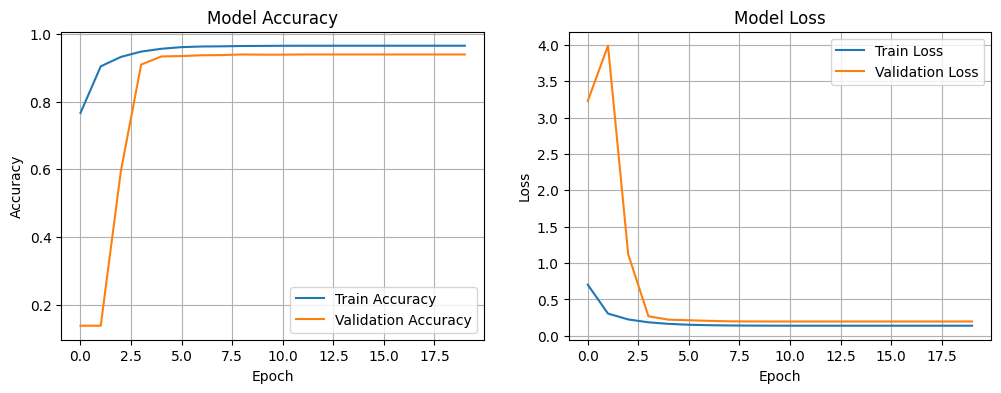

In [ ]:
# Set seeds for reproducibility
np.random.seed(42)

# Train model
trained_model, history = train_sgd(
    model=model,
    train_dataset=train_tf_dataset,
    val_dataset=val_tf_dataset,
    test_dataset=test_tf_dataset,
    epochs=20,
    learning_rate=0.001
)

In [ ]:
# Save the model
model.save('pre-trained/vgg.keras')

## Performance assessment

In [ ]:
# If necessary, load the model
model = load_model('pre-trained/vgg.keras')

In [ ]:
# Get predictions
y_pred = model.predict(test_tf_dataset)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class indices

# Get true labels
y_true = np.concatenate([y for x, y in test_tf_dataset], axis=0)
y_true_classes = y_true.flatten()  # Convert one-hot encoded labels to class indices

# Compute F1 score
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')  # Weighted F1 for multiclass classification
print(f"Test F1 Score: {f1:.4f}")

54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step
Test F1 Score: 0.9336


In [ ]:
# Compute the classification report
print(classification_report(y_true_classes, y_pred_classes))

              precision    recall  f1-score   support

           0       0.94      0.91      0.93       244
           1       0.98      0.99      0.98       624
           2       0.96      0.91      0.93       311
           3       0.83      0.87      0.85       579
           4       0.93      0.93      0.93       243
           5       0.88      0.80      0.84       284
           6       0.96      0.97      0.96       666
           7       1.00      1.00      1.00       470

    accuracy                           0.93      3421
   macro avg       0.93      0.92      0.93      3421
weighted avg       0.93      0.93      0.93      3421



# Autoencoder

The architecture of the autoencoder consists in an encoder and a decoder plugged one to each other. The enconder will encode the features of the images into a ``latent_dim=32``, it consists in:
- Input Layer: Output Shape (64, 64, 3)
- Conv2D + MaxPooling layers: (64, 64, 3) -> (64, 64, 256)
- Flatten: Output Shape (64×64×256,)
- Dense layer: compression into the ``latent_dim``. Output Shape (64,)

Furthermore, the decoder will turn the features encoded into the original image trying to minimize the error caused. The decoder will consist in:
- Input layer: Output Shape (32,)
- Dense layer and Reshape:  (32,)->(4×4×256,)->(4, 4, 256)
- 4 Conv2DTranspose: (4, 4, 256) -> (64, 64, 3)

In [ ]:
# Define input shape
input_shape = (64, 64, 3)

# Create the autoencoder model
encoder, decoder, model = autoencoder(input_shape=input_shape)

# Print the model summary
encoder.summary()
decoder.summary()
model.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_1_conv (Conv2D)              │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_1_bn (BatchNormalization)    │ (None, 64, 64, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_1_activation (Activation)    │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_2_conv (Conv2D)              │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_2_bn (BatchNormalization)    │ (None, 32, 32, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_2_activation (Activation)    │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_3_conv (Conv2D)              │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_3_bn (BatchNormalization)    │ (None, 16, 16, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_3_activation (Activation)    │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_4_conv (Conv2D)              │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_4_bn (BatchNormalization)    │ (None, 8, 8, 256)           │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_4_activation (Activation)    │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ latent_output (Dense)                │ (None, 64)                  │         262,208 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 652,544 (2.49 MB)

 Trainable params: 651,584 (2.49 MB)

 Non-trainable params: 960 (3.75 KB)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)           │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4096)                │         266,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 8, 8, 128)           │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 16, 16, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 32, 32, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_output (Conv2DTranspose)     │ (None, 64, 64, 3)           │             867 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 654,403 (2.50 MB)

 Trainable params: 654,403 (2.50 MB)

 Non-trainable params: 0 (0.00 B)

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder (Functional)                 │ (None, 64)                  │         652,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder (Functional)                 │ (None, 64, 64, 3)           │         654,403 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,306,947 (4.99 MB)

 Trainable params: 1,305,987 (4.98 MB)

 Non-trainable params: 960 (3.75 KB)

Epoch 1/20
186/186 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - loss: 0.0864 - mae: 0.1925 - val_loss: 0.0313 - val_mae: 0.1490 - learning_rate: 0.0010
Epoch 2/20
186/186 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 0.0084 - mae: 0.0669 - val_loss: 0.0156 - val_mae: 0.1026 - learning_rate: 9.0484e-04
Epoch 3/20
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0068 - mae: 0.0594 - val_loss: 0.0070 - val_mae: 0.0628 - learning_rate: 7.4082e-04
Epoch 4/20
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0061 - mae: 0.0557 - val_loss: 0.0059 - val_mae: 0.0553 - learning_rate: 5.4881e-04
Epoch 5/20
186/186 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.0057 - mae: 0.0533 - val_loss: 0.0056 - val_mae: 0.0533 - learning_rate: 3.6788e-04
Epoch 6/20
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0054 - mae: 0.0519 - val_loss: 0.0054 - val_mae: 0.0516 - learning_rate: 2.2313e-04
Epoch 7/20
186/186 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0053 - mae: 0.0511 - val_loss: 0.0053 - val_mae: 0.0511 -

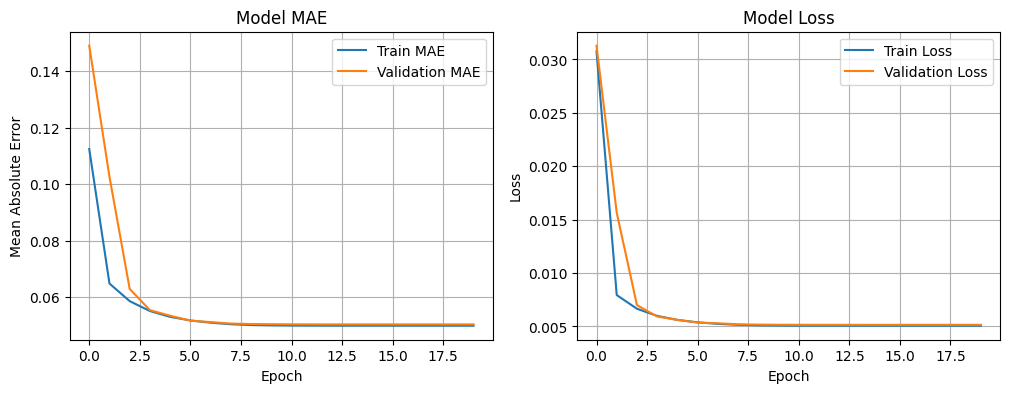

In [ ]:
# Set seeds for reproducibility
np.random.seed(42)

# Train the autoencoder
trained_model, history = train_autoencoder(
    model=model,
    train_dataset=train_autoencoder_dataset,
    val_dataset=val_autoencoder_dataset,
    epochs=20,
    learning_rate=0.001
)

In [ ]:
# Save the encoder and decoder
encoder.save('pre-trained/encoder.keras')
decoder.save('pre-trained/decoder.keras')

In [ ]:
# If necessary, load the encoder and decoder
encoder = load_model('pre-trained/encoder.keras')
decoder = load_model('pre-trained/decoder.keras')

The autoclassifier will consist in the encoder already training in the autoencoder and a CNN plugged to it for classifying purpuses. Its architecture is characterized by:
- Input layer + Encoder already trained + Reshape: (64, 64, 3) -> (32,) -> (4, 4, 2)
- 5 Conv2D (32, 64, 128, 256, 512) + Max Pooling: (4, 4, 2) -> (2, 2, 512)
- Flatten layer: Output Shape (4096,)
- Drop Out to reduce overfitting
- Output layer: Putput Shape (8,)


In [ ]:
# Detach the decoder and add a CNN-like architecture
model = autoclassifier(encoder)

# Print the model summary
model.summary()

Model: "autoclassifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_1_conv (Conv2D)              │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_1_bn (BatchNormalization)    │ (None, 64, 64, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_1_activation (Activation)    │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_2_conv (Conv2D)              │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_2_bn (BatchNormalization)    │ (None, 32, 32, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_2_activation (Activation)    │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_3_conv (Conv2D)              │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_3_bn (BatchNormalization)    │ (None, 16, 16, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_3_activation (Activation)    │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_4_conv (Conv2D)              │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_4_bn (BatchNormalization)    │ (None, 8, 8, 256)           │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_4_activation (Activation)    │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ latent_output (Dense)                │ (None, 64)                  │         262,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 2, 2, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ class_1_conv (Conv2D)                │ (None, 2, 2, 32)            │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 2,245,224 (8.56 MB)

 Trainable params: 1,590,696 (6.07 MB)

 Non-trainable params: 654,528 (2.50 MB)

Epoch 1/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 19s 53ms/step - accuracy: 0.5848 - loss: 1.2500 - val_accuracy: 0.7120 - val_loss: 0.8147 - learning_rate: 0.0010
Epoch 2/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7686 - loss: 0.6469 - val_accuracy: 0.8119 - val_loss: 0.5252 - learning_rate: 9.0484e-04
Epoch 3/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8151 - loss: 0.5263 - val_accuracy: 0.8254 - val_loss: 0.5105 - learning_rate: 7.4082e-04
Epoch 4/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8349 - loss: 0.4577 - val_accuracy: 0.8364 - val_loss: 0.4831 - learning_rate: 5.4881e-04
Epoch 5/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8511 - loss: 0.4052 - val_accuracy: 0.8423 - val_loss: 0.4803 - learning_rate: 3.6788e-04
Epoch 6/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8680 - loss: 0.3593 - val_accuracy: 0.8487 - val_loss: 0.4555 - learning_rate: 2.2313e-04
Epoch 7/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.

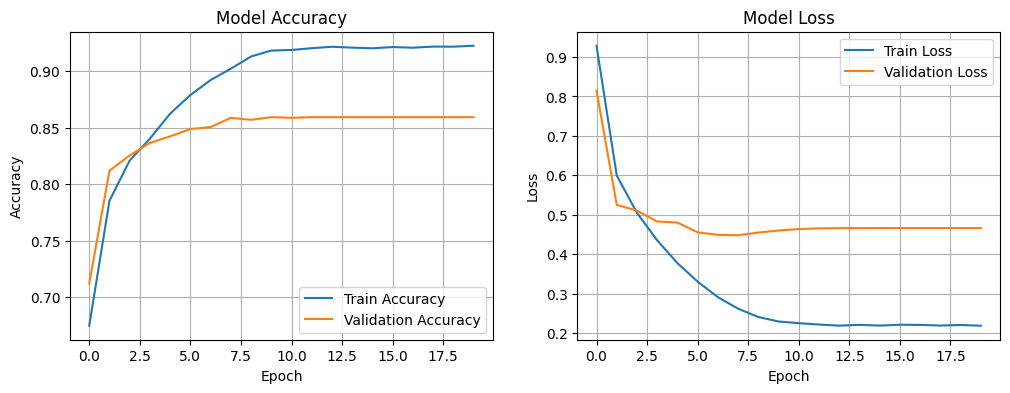

In [ ]:
# Set seeds for reproducibility
np.random.seed(42)

# Train the resulting classifier
trained_model, history = train_adam(
    model=model,
    train_dataset=train_tf_dataset,
    val_dataset=val_tf_dataset,
    test_dataset=test_tf_dataset,
    epochs=20,
    learning_rate=0.001
)

In [ ]:
# Save the model
model.save('pre-trained/autoclassifier.keras')

## Performance assessment

In [ ]:
# If necessary, load the model
model = load_model('pre-trained/autoclassifier.keras')

In [ ]:
# Get predictions
y_pred = model.predict(test_tf_dataset)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class indices

# Get true labels
y_true = np.concatenate([y for x, y in test_tf_dataset], axis=0)
y_true_classes = y_true.flatten()  # Convert one-hot encoded labels to class indices

# Compute F1 score
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')  # Weighted F1 for multiclass classification
print(f"Test F1 Score: {f1:.4f}")

54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step
Test F1 Score: 0.8519


In [ ]:
# Compute the classification report
print(classification_report(y_true_classes, y_pred_classes))

              precision    recall  f1-score   support

           0       0.67      0.66      0.67       244
           1       0.92      0.92      0.92       624
           2       0.84      0.84      0.84       311
           3       0.72      0.78      0.75       579
           4       0.81      0.79      0.80       243
           5       0.80      0.73      0.76       284
           6       0.92      0.90      0.91       666
           7       0.99      0.99      0.99       470

    accuracy                           0.85      3421
   macro avg       0.83      0.83      0.83      3421
weighted avg       0.85      0.85      0.85      3421



# Inception


This is just a less aggressive version of the Inception model proposed in https://arxiv.org/pdf/1409.4842. The reason for this is that the model is thought for images (128,128,) and we are working with images (64,64,), so we cannot afford reducing so much the data. Hence, using the Stem, Inception, and Reduction Blocks described in the paper, the Inception architecture becomes:

- Stem Block: Output Shape (32, 32, 96)
- 2 Inception A Blocks (instead of 4): Output Shape (32, 32, 384)
- Reduction A Block: Output Shape (16, 16, 576)
- 3 Inception B Blocks (instead of 7): Output Shape (16, 16, 1024)
- Reduction B Block: Output Shape (8, 8, 1408)
- 1 Inception C Block (instead of 3)
- Average Pooling: Output Shape (8, 8, 1536)
- Flatten: Output Shape (8×8×1536,)
- Output Layer: Output Shape (8,)

In [ ]:
# Define input shape
input_shape = (64, 64, 3)

# Create the Inception model
model = inception(input_shape=input_shape)

# Print the model summary
model.summary()

Model: "inception"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 64, 64, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_1_conv (Conv2D)      │ (None, 64, 64, 32)     │            896 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_1_bn                 │ (None, 64, 64, 32)     │            128 │ stem_1_conv[0][0]      │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_1_activation         │ (None, 64, 64, 32)     │              0 │ stem_1_bn[0][0]        │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_2_conv (Conv2D)      │ (None, 32, 32, 64)     │         18,496 │ stem_1_activation[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_2_bn                 │ (None, 32, 32, 64)     │            256 │ stem_2_conv[0][0]      │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_2_activation         │ (None, 32, 32, 64)     │              0 │ stem_2_bn[0][0]        │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_3_conv (Conv2D)      │ (None, 32, 32, 96)     │         55,392 │ stem_2_activation[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_3_bn                 │ (None, 32, 32, 96)     │            384 │ stem_3_conv[0][0]      │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_3_activation         │ (None, 32, 32, 96)     │              0 │ stem_3_bn[0][0]        │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ a1ia_branch_4_1_conv      │ (None, 32, 32, 64)     │          6,208 │ stem_3_activation[0][… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ a1ia_branch_4_1_bn        │ (None, 32, 32, 64)     │            256 │ a1ia_branch_4_1_conv[… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ a1ia_branch_4_1_activati… │ (None, 32, 32, 64)     │              0 │ a1ia_branch_4_1_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ a1ia_branch_3_1_conv      │ (None, 32, 32, 64)     │          6,208 │ stem_3_activation[0][… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 15,586,888 (59.46 MB)

 Trainable params: 15,561,608 (59.36 MB)

 Non-trainable params: 25,280 (98.75 KB)

Epoch 1/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 177s 676ms/step - accuracy: 0.5105 - loss: 1.7672 - val_accuracy: 0.1373 - val_loss: 5.2474 - learning_rate: 0.0010
Epoch 2/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 124s 448ms/step - accuracy: 0.8197 - loss: 0.5136 - val_accuracy: 0.1379 - val_loss: 4.6929 - learning_rate: 9.0484e-04
Epoch 3/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 141s 445ms/step - accuracy: 0.8704 - loss: 0.3572 - val_accuracy: 0.6676 - val_loss: 0.9180 - learning_rate: 7.4082e-04
Epoch 4/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 146s 466ms/step - accuracy: 0.8973 - loss: 0.2743 - val_accuracy: 0.8271 - val_loss: 0.4378 - learning_rate: 5.4881e-04
Epoch 5/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 142s 466ms/step - accuracy: 0.9290 - loss: 0.2047 - val_accuracy: 0.9188 - val_loss: 0.2222 - learning_rate: 3.6788e-04
Epoch 6/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 140s 457ms/step - accuracy: 0.9502 - loss: 0.1590 - val_accuracy: 0.9252 - val_loss: 0.2092 - learning_rate: 2.2313e-04
Epoch 7/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 142s

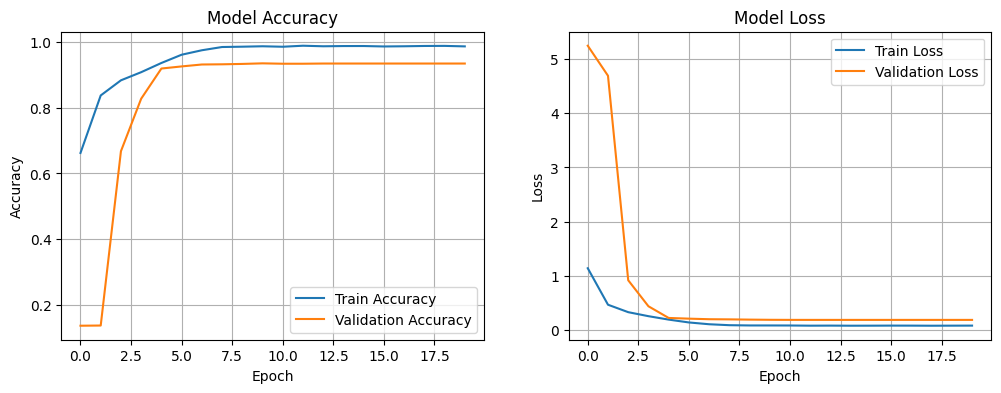

In [ ]:
# Set seeds for reproducibility
np.random.seed(42)

# Train the model using SGD
trained_model, history = train_sgd(
    model=model,
    train_dataset=train_tf_dataset,
    val_dataset=val_tf_dataset,
    test_dataset=test_tf_dataset,
    epochs=20,
    learning_rate=0.001
)

In [ ]:
model.save('pre-trained/inception.keras')

## Performance assestment

In [ ]:
# If necessary, load the model
model = load_model('pre-trained/inception.keras')

In [ ]:
# Get predictions
y_pred = model.predict(test_tf_dataset)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class indices

# Get true labels
y_true = np.concatenate([y for x, y in test_tf_dataset], axis=0)
y_true_classes = y_true.flatten()  # Convert one-hot encoded labels to class indices

# Compute F1 score
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')  # Weighted F1 for multiclass classification
print(f"Test F1 Score: {f1:.4f}")

54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 196ms/step
Test F1 Score: 0.9293


In [ ]:
# Compute the classification report
print(classification_report(y_true_classes, y_pred_classes))

              precision    recall  f1-score   support

           0       0.90      0.84      0.87       244
           1       0.98      0.98      0.98       624
           2       0.96      0.92      0.94       311
           3       0.82      0.86      0.84       579
           4       0.94      0.93      0.93       243
           5       0.87      0.83      0.85       284
           6       0.95      0.97      0.96       666
           7       1.00      1.00      1.00       470

    accuracy                           0.93      3421
   macro avg       0.93      0.92      0.92      3421
weighted avg       0.93      0.93      0.93      3421



# Comparison between models

In [ ]:
# Load all the models we want to compare
model_cnn = load_model('pre-trained/cnn.keras')
model_dilated_cnn = load_model('pre-trained/dilated_cnn.keras')
model_resnet = load_model('pre-trained/resnet.keras')
model_vgg = load_model('pre-trained/vgg.keras')
model_autoclassifier = load_model('pre-trained/autoclassifier.keras')
model_inception = load_model('pre-trained/inception.keras')

In [ ]:
models = [model_cnn, model_dilated_cnn, model_vgg, model_autoclassifier, model_resnet, model_inception]
model_names = ['CNN','Dilated_CNN','VGG','AutoClassifier','ResNet','Inception']
f1_scores = [0.9643,0.9637,0.9336,0.8519,0.8831,0.9293]
training_times = [67,65,23,19,44,177]
memory_occupations = [33.49,33.49,4.61,8.56,81.34,59.46]

data = {
    'model': models,
    'name': model_names,
    'f1-score': f1_scores,
    'time': training_times,
    'memory_occupation': memory_occupations
}


df = pd.DataFrame(data)

df

model            name  f1-score  \
0             <Functional name=cnn, built=True>             CNN    0.9643   
1     <Functional name=dilated_cnn, built=True>     Dilated_CNN    0.9637   
2             <Functional name=vgg, built=True>             VGG    0.9336   
3  <Functional name=autoclassifier, built=True>  AutoClassifier    0.8519   
4        <Functional name=ResNet34, built=True>          ResNet    0.8831   
5       <Functional name=inception, built=True>       Inception    0.9293   

   time  memory_occupation  
0    67              33.49  
1    65              33.49  
2    23               4.61  
3    19               8.56  
4    44              81.34  
5   177              59.46

In [ ]:
# Save the model
df.to_csv('pre-trained/models_metrics.csv', index=False)

## Visual comparison between models

In [ ]:
# Load the models stats if needed
df = pd.read_csv('pre-trained/models_metrics.csv')

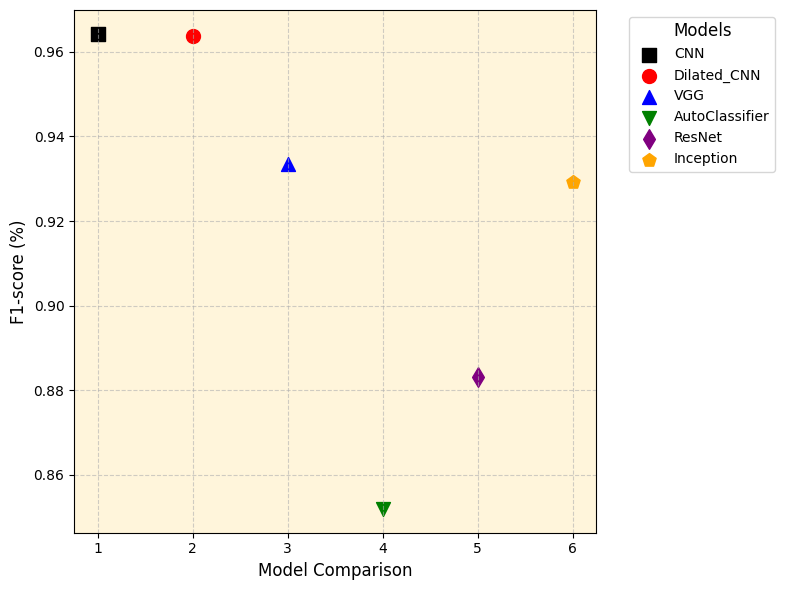

In [ ]:
# x-axis
pbc = [1, 2, 3, 4, 5, 6, 7]

# Markers for each model
markers = ['s', 'o', '^', 'v', 'd', 'p', '>', 'x', '*', 'h']
colors = ['black', 'red', 'blue', 'green', 'purple', 'orange', 'cyan', 'brown', 'gold', 'coral']

# Plot setup
plt.figure(figsize=(8, 6))
plt.gca().set_facecolor("#FFF5DB")

# Scatter plot
for i, row in df.iterrows():
    plt.scatter(pbc[i], row['f1-score'], marker=markers[i], color=colors[i], label=row['name'], s=100)

# Labels and titles
plt.xlabel('Model Comparison', fontsize=12)
plt.ylabel('F1-score (%)', fontsize=12)

# Custom Legend
legend = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Models", fontsize=10)
plt.setp(legend.get_title(), fontsize=12)

# Grid and display
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

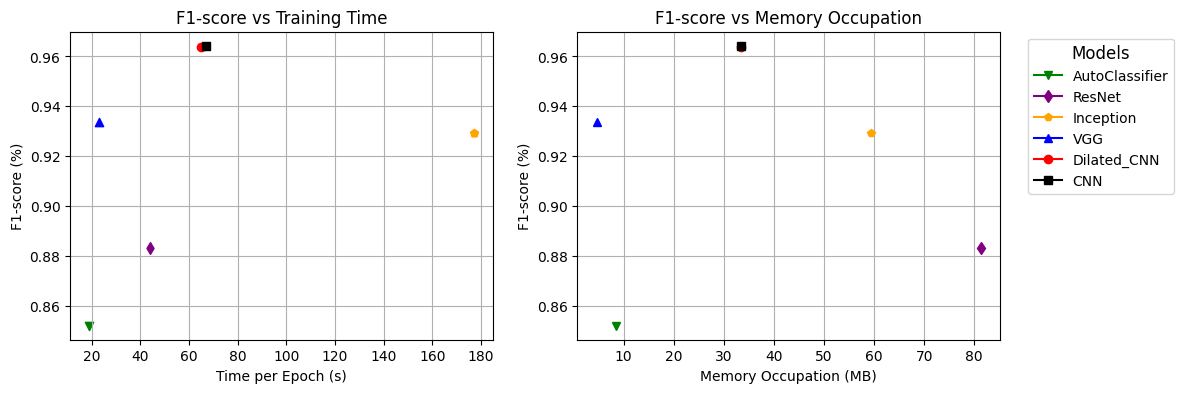

In [ ]:
df = df.sort_values(by=["f1-score", "time", "memory_occupation"], ascending=True)

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
for i, row in df.iterrows():
    plt.scatter(row['time'], row['f1-score'], marker=markers[i], color=colors[i], label=row['name'])
plt.title('F1-score vs Training Time')
plt.xlabel('Time per Epoch (s)')
plt.ylabel('F1-score (%)')
plt.grid(True)

# Plot training & validation loss values
plt.subplot(1, 2, 2)
for i, row in df.iterrows():
    plt.plot(row['memory_occupation'], row['f1-score'], marker=markers[i], color=colors[i], label=row['name'])
plt.title('F1-score vs Memory Occupation')
plt.xlabel('Memory Occupation (MB)')
plt.ylabel('F1-score (%)')
plt.grid(True)
# Custom Legend
legend = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Models", fontsize=10)
plt.setp(legend.get_title(), fontsize=12)

plt.show()

# Feature extraction



In [ ]:
#Load all the models
model_cnn = load_model('pre-trained/cnn.keras')
model_resnet = load_model('pre-trained/resnet.keras')
model_vgg = load_model('pre-trained/vgg.keras')
model_autoclassifier = load_model('pre-trained/autoclassifier.keras')
model_inception = load_model('pre-trained/inception.keras')

In [ ]:
# Take the last convolution layer for each model
last_layer_cnn = "4_activation"
last_layer_resnet = "conv2d_35"
last_layer_vgg = "4_2_conv"
last_layer_autoclassifier = "class_2_conv"
last_layer_inception = "concatenate_7"

# Put everything in lists
models =  [model_cnn, model_resnet, model_vgg, model_autoclassifier,model_inception]
last_layers = [last_layer_cnn, last_layer_resnet, last_layer_vgg, last_layer_autoclassifier,last_layer_inception]

In [ ]:
# Model info dictionary
model_info_dict = {
    model_cnn.name: {'model': model_cnn, 'last_layer': last_layer_cnn, 'name': 'CNN'},
    model_resnet.name: {'model': model_resnet, 'last_layer': last_layer_resnet, 'name': 'ResNet'},
    model_vgg.name: {'model': model_vgg, 'last_layer': last_layer_vgg, 'name': 'VGG'},
    model_autoclassifier.name: {'model': model_autoclassifier, 'last_layer': last_layer_autoclassifier, 'name': 'Autoclassifier'},
    model_inception.name: {'model': model_inception, 'last_layer': last_layer_inception, 'name': 'Inception'}
}

Text(0.5, 1.0, 'Original Image')

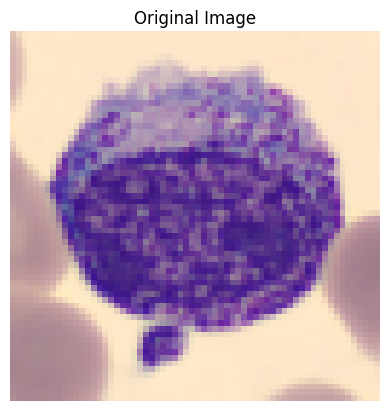

In [ ]:
# Use Grad-CAM on a sample image
sample_img, sample_label = next(iter(test_tf_dataset.take(1)))  # Get a batch
sample_img = sample_img[0:1]  # Select one image

plt.imshow(sample_img[0])  # Display the original image
plt.axis("off")
plt.title('Original Image')

In [ ]:
model_cnn.summary()

Model: "cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 1_conv (Conv2D)                      │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 1_bn (BatchNormalization)            │ (None, 64, 64, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 1_activation (Activation)            │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 2_conv (Conv2D)                      │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 2_bn (BatchNormalization)            │ (None, 64, 64, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 2_activation (Activation)            │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 3_conv (Conv2D)                      │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 3_bn (BatchNormalization)            │ (None, 64, 64, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 3_activation (Activation)            │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 4_conv (Conv2D)                      │ (None, 64, 64, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 4_bn (BatchNormalization)            │ (None, 64, 64, 256)         │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 4_activation (Activation)            │ (None, 64, 64, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 64, 64, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1048576)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 8)                   │       8,388,616 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,334,938 (100.46 MB)

 Trainable params: 8,777,992 (33.49 MB)

 Non-trainable params: 960 (3.75 KB)

 Optimizer params: 17,555,986 (66.97 MB)

CNN
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


/content/drive/MyDrive/BloodCellClassification/utils/metrics.py:63: RuntimeWarning: invalid value encountered in divide
  heatmap /= np.max(heatmap)  # Normalize to [0,1]
/content/drive/MyDrive/BloodCellClassification/utils/metrics.py:64: RuntimeWarning: invalid value encountered in cast
  heatmap = np.uint8(255 * heatmap)  # Scale to [0,255]


ResNet
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


VGG
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Autoclassifier
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Inception
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


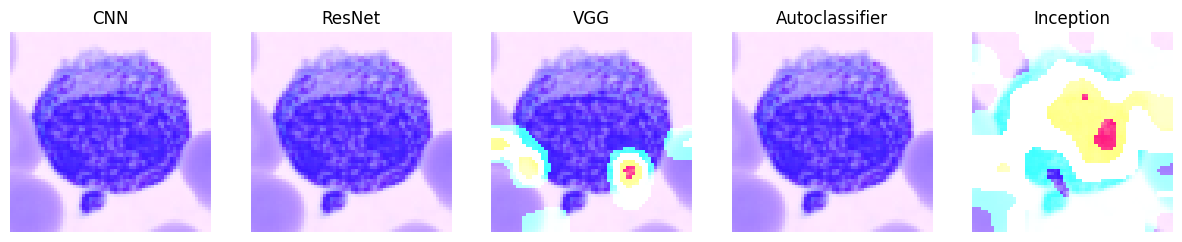

In [ ]:
# Use Grad-CAM on a sample image
sample_img, sample_label = next(iter(test_tf_dataset.take(1)))  # Get a batch
sample_img = sample_img[0:1]  # Select one image

# Plot Grad-CAM results
plt.figure(figsize=(15, 10))

# Loop through models to compute and plot Grad-CAM heatmaps
for i, (model_name, model_info) in enumerate(model_info_dict.items()):
    model = model_info["model"]
    target_layer_name = model_info["last_layer"]
    title = model_info["name"]
    print(title)

    # Get the heatmap
    pred_class = model.predict(sample_img).argmax(axis=-1)
    heatmap = get_gradcam_heatmap(model, sample_img, target_layer_name, pred_class)

    # Display the Grad-CAM heatmap
    plt.subplot(2, int(len(model_info_dict)), i+1)
    plt.imshow(plot_gradcam(sample_img[0].numpy(), heatmap))
    plt.axis("off")
    plt.title(title)

plt.show()

# Conclusion of the first part of the analysis
See the figure __F1-score vs Memory Occupation__. We can notice that the more complex models are underperforming, the reason for this is that the complexity of the data and the size of the dataset is not high enough to make them output more simpler models like CNN and VGG. For this reason, we have decided to take this two architecture and develop them to try to maximize their performance. This will be done by the use of different attention mechanisms.

# VGG-like architecture

## VGG8

This is just a VGG-architecture with 3 convolution + convolution + max pooling blocks.

In [ ]:
# Define input shape
input_shape = (64, 64, 3)

# Create the VGG model
model = vgg8(input_shape=input_shape)

# Print the model summary
model.summary()

Model: "vgg8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 1_1_conv (Conv2D)                    │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 1_1_bn (BatchNormalization)          │ (None, 64, 64, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 1_1_activation (Activation)          │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 1_2_conv (Conv2D)                    │ (None, 64, 64, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 1_2_bn (BatchNormalization)          │ (None, 64, 64, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 1_2_activation (Activation)          │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 2_1_conv (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 2_1_bn (BatchNormalization)          │ (None, 32, 32, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 2_1_activation (Activation)          │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 2_2_conv (Conv2D)                    │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 2_2_bn (BatchNormalization)          │ (None, 32, 32, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 2_2_activation (Activation)          │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 3_1_conv (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 3_1_bn (BatchNormalization)          │ (None, 16, 16, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 3_1_activation (Activation)          │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 3_2_conv (Conv2D)                    │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 3_2_bn (BatchNormalization)          │ (None, 16, 16, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 3_2_activation (Activation)          │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 4,617,000 (17.61 MB)

 Trainable params: 4,616,104 (17.61 MB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 40s 102ms/step - accuracy: 0.4539 - loss: 1.5873 - val_accuracy: 0.1373 - val_loss: 2.1579 - learning_rate: 0.0010
Epoch 2/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.7958 - loss: 0.6083 - val_accuracy: 0.2033 - val_loss: 1.9202 - learning_rate: 9.0484e-04
Epoch 3/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.8389 - loss: 0.4594 - val_accuracy: 0.7570 - val_loss: 0.6738 - learning_rate: 7.4082e-04
Epoch 4/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.8637 - loss: 0.3955 - val_accuracy: 0.9136 - val_loss: 0.2821 - learning_rate: 5.4881e-04
Epoch 5/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.8786 - loss: 0.3548 - val_accuracy: 0.9194 - val_loss: 0.2478 - learning_rate: 3.6788e-04
Epoch 6/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.8839 - loss: 0.3437 - val_accuracy: 0.9223 - val_loss: 0.2421 - learning_rate: 2.2313e-04
Epoch 7/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accu

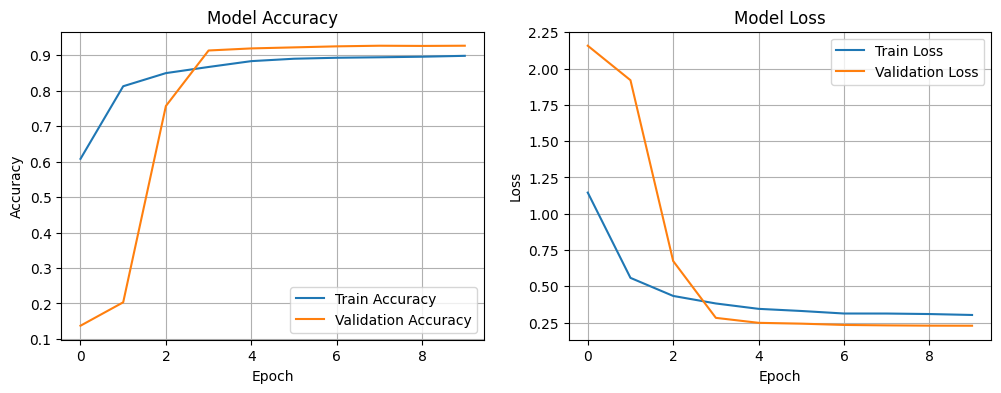

In [ ]:
# Set seeds for reproducibility
np.random.seed(42)

# Train model
trained_model, history = train_sgd(
    model=model,
    train_dataset=train_tf_dataset,
    val_dataset=val_tf_dataset,
    test_dataset=test_tf_dataset,
    epochs=10,
    learning_rate=0.001
)

In [ ]:
model.save('pre-trained/vgg8.keras')

FileNotFoundError: [Errno 2] No such file or directory: 'pre-trainead/vgg8.keras'

### Performance Assestment

In [ ]:
# If necessary, load the model
model = load_model('pre-trained/vgg8.keras')

In [ ]:
# Get predictions
y_pred = model.predict(test_tf_dataset)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class indices

# Get true labels
y_true = np.concatenate([y for x, y in test_tf_dataset], axis=0)  # Assuming test_dataset has labels
y_true_classes = y_true.flatten()  # Convert one-hot encoded labels to class indices

# Compute F1 score
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')  # Weighted F1 for multiclass classification
print(f"Test F1 Score: {f1:.4f}")

## VGG12

This is just a VGG-architecture with 4 convolution + convolution + max pooling blocks.

In [ ]:
# Define input shape
input_shape = (64, 64, 3)

# Create the VGG model
model = vgg12(input_shape=input_shape)

# Print the model summary
model.summary()

Model: "vgg12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 1_1_conv (Conv2D)                    │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 1_1_bn (BatchNormalization)          │ (None, 64, 64, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 1_1_activation (Activation)          │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 1_2_conv (Conv2D)                    │ (None, 64, 64, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 1_2_bn (BatchNormalization)          │ (None, 64, 64, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 1_2_activation (Activation)          │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 2_1_conv (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 2_1_bn (BatchNormalization)          │ (None, 32, 32, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 2_1_activation (Activation)          │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 2_2_conv (Conv2D)                    │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 2_2_bn (BatchNormalization)          │ (None, 32, 32, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 2_2_activation (Activation)          │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 3_1_conv (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 3_1_bn (BatchNormalization)          │ (None, 16, 16, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 3_1_activation (Activation)          │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 3_2_conv (Conv2D)                    │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 3_2_bn (BatchNormalization)          │ (None, 16, 16, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 3_2_activation (Activation)          │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,998,248 (15.25 MB)

 Trainable params: 3,995,816 (15.24 MB)

 Non-trainable params: 2,432 (9.50 KB)

Epoch 1/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 28s 85ms/step - accuracy: 0.4886 - loss: 1.4961 - val_accuracy: 0.1373 - val_loss: 2.4927 - learning_rate: 0.0010
Epoch 2/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 22s 31ms/step - accuracy: 0.8162 - loss: 0.5256 - val_accuracy: 0.1373 - val_loss: 3.5387 - learning_rate: 9.0484e-04
Epoch 3/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.8680 - loss: 0.3852 - val_accuracy: 0.6484 - val_loss: 0.9740 - learning_rate: 7.4082e-04
Epoch 4/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.8970 - loss: 0.3113 - val_accuracy: 0.8931 - val_loss: 0.3043 - learning_rate: 5.4881e-04
Epoch 5/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.9117 - loss: 0.2761 - val_accuracy: 0.9311 - val_loss: 0.2162 - learning_rate: 3.6788e-04
Epoch 6/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.9183 - loss: 0.2541 - val_accuracy: 0.9340 - val_loss: 0.2076 - learning_rate: 2.2313e-04
Epoch 7/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - ac

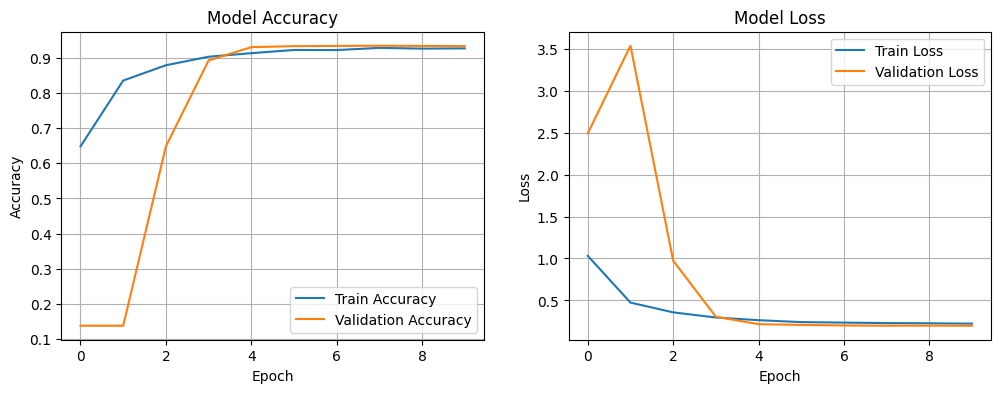

In [ ]:
# Set seeds for reproducibility
np.random.seed(42)

# Train model
trained_model, history = train_sgd(
    model=model,
    train_dataset=train_tf_dataset,
    val_dataset=val_tf_dataset,
    test_dataset=test_tf_dataset,
    epochs=10,
    learning_rate=0.001
)

In [ ]:
model.save('pre-trainead/vgg12.keras')

### Performance Assestment

In [ ]:
# If necessary, load the model
model = load_model('pre-trained/vgg12.keras')

In [ ]:
# Get predictions
y_pred = model.predict(test_tf_dataset)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class indices

# Get true labels
y_true = np.concatenate([y for x, y in test_tf_dataset], axis=0)  # Assuming test_dataset has labels
y_true_classes = y_true.flatten()  # Convert one-hot encoded labels to class indices

# Compute F1 score
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')  # Weighted F1 for multiclass classification
print(f"Test F1 Score: {f1:.4f}")

54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step
Test F1 Score: 0.9310


## VGG15

This is just a VGG-architecture with 5 convolution + convolution + max pooling blocks.

In [ ]:
# Define input shape
input_shape = (64, 64, 3)

# Create the VGG model
model = vgg15(input_shape=input_shape)

# Print the model summary
model.summary()

Model: "vgg15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 1_1_conv (Conv2D)                    │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 1_1_bn (BatchNormalization)          │ (None, 64, 64, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 1_1_activation (Activation)          │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 1_2_conv (Conv2D)                    │ (None, 64, 64, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 1_2_bn (BatchNormalization)          │ (None, 64, 64, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 1_2_activation (Activation)          │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 2_1_conv (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 2_1_bn (BatchNormalization)          │ (None, 32, 32, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 2_1_activation (Activation)          │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 2_2_conv (Conv2D)                    │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 2_2_bn (BatchNormalization)          │ (None, 32, 32, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 2_2_activation (Activation)          │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 3_1_conv (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 3_1_bn (BatchNormalization)          │ (None, 16, 16, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 3_1_activation (Activation)          │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 3_2_conv (Conv2D)                    │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 3_2_bn (BatchNormalization)          │ (None, 16, 16, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 3_2_activation (Activation)          │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 8,855,592 (33.78 MB)

 Trainable params: 8,850,088 (33.76 MB)

 Non-trainable params: 5,504 (21.50 KB)

Epoch 1/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 26s 88ms/step - accuracy: 0.5034 - loss: 1.4332 - val_accuracy: 0.1373 - val_loss: 2.4963 - learning_rate: 0.0010
Epoch 2/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 25s 40ms/step - accuracy: 0.8497 - loss: 0.4427 - val_accuracy: 0.1373 - val_loss: 4.5487 - learning_rate: 9.0484e-04
Epoch 3/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.8938 - loss: 0.3141 - val_accuracy: 0.5660 - val_loss: 1.3042 - learning_rate: 7.4082e-04
Epoch 4/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.9172 - loss: 0.2473 - val_accuracy: 0.9223 - val_loss: 0.2439 - learning_rate: 5.4881e-04
Epoch 5/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.9297 - loss: 0.2114 - val_accuracy: 0.9235 - val_loss: 0.2115 - learning_rate: 3.6788e-04
Epoch 6/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - accuracy: 0.9429 - loss: 0.1871 - val_accuracy: 0.9375 - val_loss: 0.1842 - learning_rate: 2.2313e-04
Epoch 7/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - a

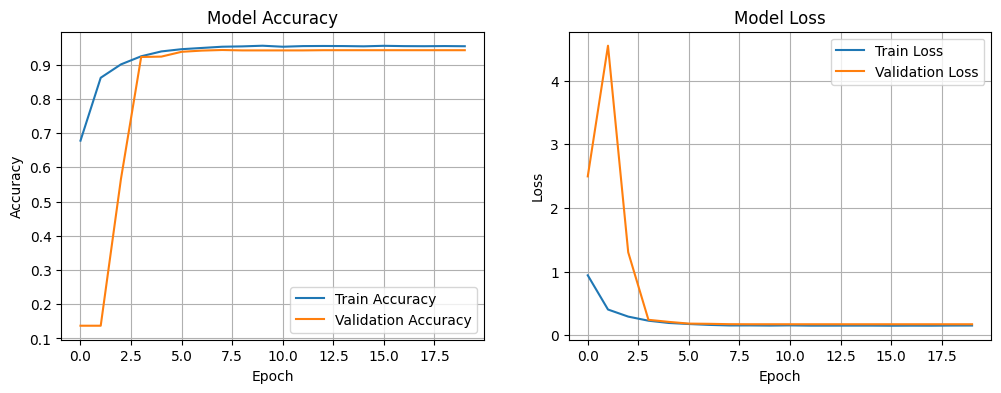

In [ ]:
# Set seeds for reproducibility
np.random.seed(42)

# Train model
trained_model, history = train_sgd(
    model=model,
    train_dataset=train_tf_dataset,
    val_dataset=val_tf_dataset,
    test_dataset=test_tf_dataset,
    epochs=20,
    learning_rate=0.001
)

In [ ]:
model.save('pre-trained/vgg15.keras')

### Performance Assestment

In [ ]:
# If necessary, load the model
model = load_model('pre-trained/vgg15.keras')

In [ ]:
# Get predictions
y_pred = model.predict(test_tf_dataset)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class indices

# Get true labels
y_true = np.concatenate([y for x, y in test_tf_dataset], axis=0)  # Assuming test_dataset has labels
y_true_classes = y_true.flatten()  # Convert one-hot encoded labels to class indices

# Compute F1 score
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')  # Weighted F1 for multiclass classification
print(f"Test F1 Score: {f1:.4f}")

54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step
Test F1 Score: 0.9400


## VGG18

This is just a VGG-architecture with 6 convolution + convolution + max pooling blocks.

In [ ]:
# Define input shape
input_shape = (64, 64, 3)

# Create the VGG model
model = vgg18(input_shape=input_shape)

# Print the model summary
model.summary()

Model: "vgg18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 1_1_conv (Conv2D)                    │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 1_1_bn (BatchNormalization)          │ (None, 64, 64, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 1_1_activation (Activation)          │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 1_2_conv (Conv2D)                    │ (None, 64, 64, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 1_2_bn (BatchNormalization)          │ (None, 64, 64, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 1_2_activation (Activation)          │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 2_1_conv (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 2_1_bn (BatchNormalization)          │ (None, 32, 32, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 2_1_activation (Activation)          │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 2_2_conv (Conv2D)                    │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 2_2_bn (BatchNormalization)          │ (None, 32, 32, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 2_2_activation (Activation)          │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 3_1_conv (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 3_1_bn (BatchNormalization)          │ (None, 16, 16, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 3_1_activation (Activation)          │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 3_2_conv (Conv2D)                    │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 3_2_bn (BatchNormalization)          │ (None, 16, 16, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 3_2_activation (Activation)          │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 15,154,728 (57.81 MB)

 Trainable params: 15,146,152 (57.78 MB)

 Non-trainable params: 8,576 (33.50 KB)

Epoch 1/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 30s 102ms/step - accuracy: 0.4868 - loss: 1.4190 - val_accuracy: 0.1373 - val_loss: 2.4109 - learning_rate: 0.0010
Epoch 2/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 24s 52ms/step - accuracy: 0.8346 - loss: 0.4781 - val_accuracy: 0.1373 - val_loss: 4.9630 - learning_rate: 9.0484e-04
Epoch 3/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - accuracy: 0.8863 - loss: 0.3277 - val_accuracy: 0.5117 - val_loss: 1.4174 - learning_rate: 7.4082e-04
Epoch 4/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - accuracy: 0.9205 - loss: 0.2468 - val_accuracy: 0.8984 - val_loss: 0.2754 - learning_rate: 5.4881e-04
Epoch 5/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - accuracy: 0.9399 - loss: 0.1985 - val_accuracy: 0.9352 - val_loss: 0.1891 - learning_rate: 3.6788e-04
Epoch 6/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - accuracy: 0.9519 - loss: 0.1717 - val_accuracy: 0.9369 - val_loss: 0.1806 - learning_rate: 2.2313e-04
Epoch 7/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - 

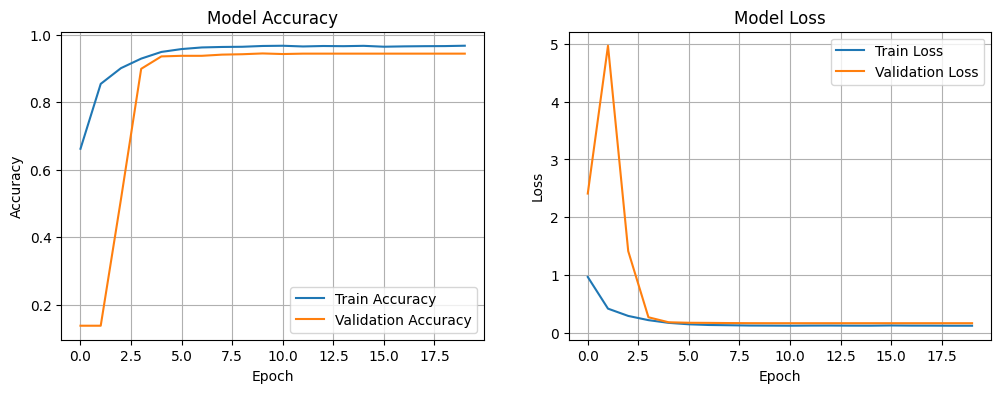

In [ ]:
# Set seeds for reproducibility
np.random.seed(42)

# Train model
trained_model, history = train_sgd(
    model=model,
    train_dataset=train_tf_dataset,
    val_dataset=val_tf_dataset,
    test_dataset=test_tf_dataset,
    epochs=20,
    learning_rate=0.001
)

In [ ]:
model.save('pre-trained/vgg18.keras')

### Performance assestment

In [ ]:
# If necessary, load the model
model = load_model('pre-trained/vgg18.keras')

In [ ]:
# Get predictions
y_pred = model.predict(test_tf_dataset)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class indices

# Get true labels
y_true = np.concatenate([y for x, y in test_tf_dataset], axis=0)  # Assuming test_dataset has labels
y_true_classes = y_true.flatten()  # Convert one-hot encoded labels to class indices

# Compute F1 score
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')  # Weighted F1 for multiclass classification
print(f"Test F1 Score: {f1:.4f}")

54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step
Test F1 Score: 0.9395


# Attention Based Networks

In this section, we well use the best performing VGG and CNN and dive into attention. After a wider analysis, we realized that for our dataset, fully connected layers do not improve the accuracies of the models. In fact, the make them slighty worse with more parameters.

## SE-VGG15

This architecture consists in using VGG15 but adding a channel attention block at the end of every block.

In [ ]:
# Define input shape
input_shape = (64, 64, 3)

# Create the VGG model
model = SE_VGG15(input_shape=input_shape) # Channel-wise

# Print the model summary
model.summary()

Model: "SE_VGG15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 64, 64, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ 1_1_conv (Conv2D)         │ (None, 64, 64, 32)     │            896 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ 1_1_bn                    │ (None, 64, 64, 32)     │            128 │ 1_1_conv[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ 1_1_activation            │ (None, 64, 64, 32)     │              0 │ 1_1_bn[0][0]           │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ 1_2_conv (Conv2D)         │ (None, 64, 64, 32)     │          9,248 │ 1_1_activation[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ 1_2_bn                    │ (None, 64, 64, 32)     │            128 │ 1_2_conv[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ 1_2_activation            │ (None, 64, 64, 32)     │              0 │ 1_2_bn[0][0]           │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 32, 32, 32)     │              0 │ 1_2_activation[0][0]   │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 32)             │              0 │ max_pooling2d[0][0]    │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling2d      │ (None, 32)             │              0 │ max_pooling2d[0][0]    │
│ (GlobalMaxPooling2D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 4)              │            128 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 4)              │            128 │ global_max_pooling2d[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 32)             │            128 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 32)             │            128 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 32)             │              0 │ dense_1[0][0],         │
│                           │                        │                │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activatio

 Total params: 7,273,000 (27.74 MB)

 Trainable params: 7,268,008 (27.73 MB)

 Non-trainable params: 4,992 (19.50 KB)

Epoch 1/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 58s 138ms/step - accuracy: 0.7265 - loss: 0.9202 - val_accuracy: 0.1373 - val_loss: 11.3313 - learning_rate: 0.0010
Epoch 2/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.9229 - loss: 0.2183 - val_accuracy: 0.1373 - val_loss: 13.1933 - learning_rate: 9.0484e-04
Epoch 3/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.9516 - loss: 0.1524 - val_accuracy: 0.5905 - val_loss: 1.8406 - learning_rate: 7.4082e-04
Epoch 4/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9668 - loss: 0.1018 - val_accuracy: 0.9025 - val_loss: 0.3165 - learning_rate: 5.4881e-04
Epoch 5/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - accuracy: 0.9741 - loss: 0.0776 - val_accuracy: 0.9322 - val_loss: 0.2378 - learning_rate: 3.6788e-04
Epoch 6/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - accuracy: 0.9849 - loss: 0.0453 - val_accuracy: 0.9708 - val_loss: 0.0899 - learning_rate: 2.2313e-04
Epoch 7/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - 

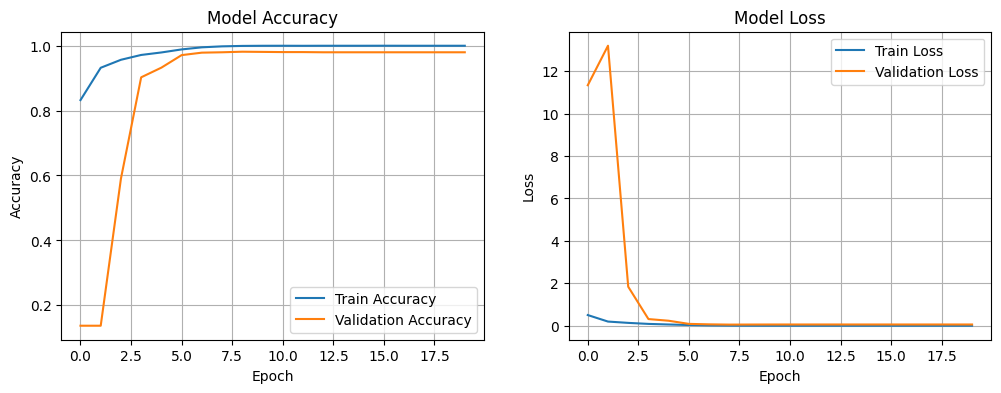

In [ ]:
# Set seeds for reproducibility
np.random.seed(42)

# Train model
trained_model, history = train_adam(
    model=model,
    train_dataset=train_tf_dataset,
    val_dataset=val_tf_dataset,
    test_dataset=test_tf_dataset,
    epochs=20,
    learning_rate=0.001
)

In [ ]:
model.save('pre-trained/SE_VGG15.keras')

### Performance Assessment

In [ ]:
# If necessary, load the model
model = load_model('pre-trained/SE_VGG15.keras')

In [ ]:
# Get predictions
y_pred = model.predict(test_tf_dataset)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class indices

# Get true labels
y_true = np.concatenate([y for x, y in test_tf_dataset], axis=0)
y_true_classes = y_true.flatten()  # Convert one-hot encoded labels to class indices

# Compute F1 score
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')  # Weighted F1 for multiclass classification
print(f"Test F1 Score: {f1:.4f}")

54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step
Test F1 Score: 0.9821


## SA-VGG15

This architecture consists in a VGG15 architecture with an spatial attention mechanism after every block, that will allow the network focus "where" in the feature map resides the most important information. The idea behind this spatial attention mechanism is:
- Input: Take a feature map of shape `(H, W, C)`; where `H` and `W` are the spatial dimensions, and `C` the number of channels.
- Pooling Operations: do a average pooling and max pooling paralelly, both pooling operations result in a feature map of shape `(H, W, 1)`. Then concatenate them, getting `(H, W, 2)`
- Finally, do a `Conv2D` layer with 1x1 kernel to produce a single-channel attention map of shape `(H, W, 1)`.
- Then, sigmoid function to convert the values to a range of `[0,1]` and element-wise multiplication.


In [ ]:
# Define input shape
input_shape = (64, 64, 3)

# Create the model
model = SA_VGG15(input_shape=input_shape) # Spatial-wise

# Print the model summary
model.summary()

Model: "SA_VGG15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 1_1_conv (Conv2D)                    │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 1_1_bn (BatchNormalization)          │ (None, 64, 64, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 1_1_activation (Activation)          │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 1_2_conv (Conv2D)                    │ (None, 64, 64, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 1_2_bn (BatchNormalization)          │ (None, 64, 64, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 1_2_activation (Activation)          │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_attention (SpatialAttention) │ (None, 32, 32, 32)          │              98 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 2_1_conv (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 2_1_bn (BatchNormalization)          │ (None, 32, 32, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 2_1_activation (Activation)          │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 2_2_conv (Conv2D)                    │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 2_2_bn (BatchNormalization)          │ (None, 32, 32, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 2_2_activation (Activation)          │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_attention_1                  │ (None, 16, 16, 64)          │              98 │
│ (SpatialAttention)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 3_1_conv (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 3_1_bn (BatchNormalization)          │ (None, 16, 16, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 3_1_activation (Activation)          │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 3_2_conv (Conv2D)                    │ (None, 16, 16, 128)         │         147,5

 Total params: 7,098,898 (27.08 MB)

 Trainable params: 7,093,906 (27.06 MB)

 Non-trainable params: 4,992 (19.50 KB)

Epoch 1/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 38s 102ms/step - accuracy: 0.4824 - loss: 1.7051 - val_accuracy: 0.0905 - val_loss: 5.0347 - learning_rate: 0.0010
Epoch 2/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - accuracy: 0.8469 - loss: 0.4032 - val_accuracy: 0.1852 - val_loss: 4.8334 - learning_rate: 9.0484e-04
Epoch 3/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.9198 - loss: 0.2261 - val_accuracy: 0.7728 - val_loss: 0.7100 - learning_rate: 7.4082e-04
Epoch 4/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9463 - loss: 0.1574 - val_accuracy: 0.7079 - val_loss: 1.1507 - learning_rate: 5.4881e-04
Epoch 5/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9585 - loss: 0.1129 - val_accuracy: 0.9112 - val_loss: 0.3109 - learning_rate: 3.6788e-04
Epoch 6/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - accuracy: 0.9708 - loss: 0.0755 - val_accuracy: 0.9556 - val_loss: 0.1528 - learning_rate: 2.2313e-04
Epoch 7/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - ac

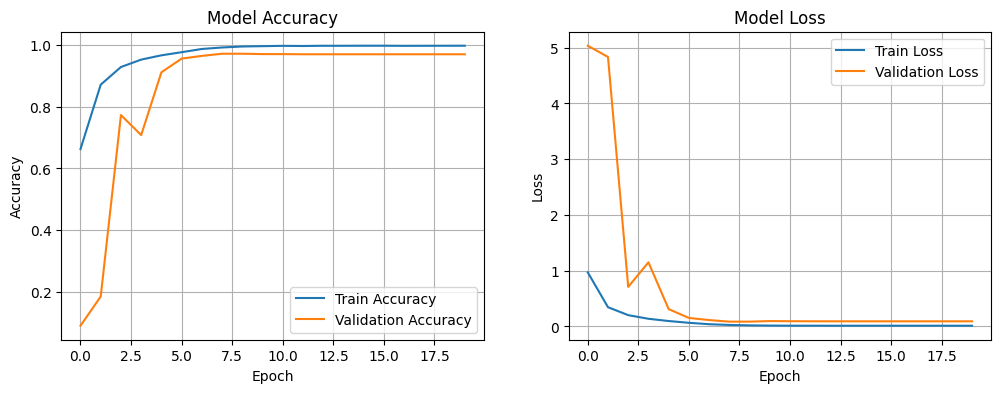

In [ ]:
# Set seeds for reproducibility
np.random.seed(42)

# Train model
trained_model, history = train_adam(
    model=model,
    train_dataset=train_tf_dataset,
    val_dataset=val_tf_dataset,
    test_dataset=test_tf_dataset,
    epochs=20,
    learning_rate=0.001
)

In [ ]:
model.save('pre-trained/SA_VGG15.keras')

### Performance Assessment

In [ ]:
# If necessary, load the model
model = load_model('pre-trained/SA_VGG15.keras')

In [ ]:
# Get predictions
y_pred = model.predict(test_tf_dataset)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class indices

# Get true labels
y_true = np.concatenate([y for x, y in test_tf_dataset], axis=0)
y_true_classes = y_true.flatten()  # Convert one-hot encoded labels to class indices

# Compute F1 score
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')  # Weighted F1 for multiclass classification
print(f"Test F1 Score: {f1:.4f}")

54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step
Test F1 Score: 0.9763


## CBAM-VGG15

This model is a combination of everything we have seen so far. We have seen that:
- Channel Attention Modules focus on "what" to emphasize in the feature map accross channels.
- Spatial Attention Modules focus on "where" to emphasize in the spatial dimentions.

Since this two attention modules focus on different things, it might be interesting to apply both of them. This model does exactly that, after every block, we apply Channel Attention Module and then Spatial Attention Module.
The idea of this model was proposed in the following paper https://arxiv.org/pdf/1807.06521. Additionally, I used this post for the implementation of the model: https://www.digitalocean.com/community/tutorials/attention-mechanisms-in-computer-vision-cbam#what-s-meant-by-spatial-attention.

As a final comment, I would say that this model should be better than anything I have done before, since I am combining to very powerful tool (Channel and Spatial Attention) which already gave good performance. Putting one after another should improve things but it doesn't, so I am assuming this is the highest performance achievable for me.

In [ ]:
# Define input shape
input_shape = (64, 64, 3)

# Create the model
model = CBAM_VGG15(input_shape=input_shape)

# Print the model summary
model.summary()

Model: "CBAM_VGG15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 64, 64, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ 1_1_conv (Conv2D)         │ (None, 64, 64, 32)     │            896 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ 1_1_bn                    │ (None, 64, 64, 32)     │            128 │ 1_1_conv[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ 1_1_activation            │ (None, 64, 64, 32)     │              0 │ 1_1_bn[0][0]           │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ 1_2_conv (Conv2D)         │ (None, 64, 64, 32)     │          9,248 │ 1_1_activation[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ 1_2_bn                    │ (None, 64, 64, 32)     │            128 │ 1_2_conv[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ 1_2_activation            │ (None, 64, 64, 32)     │              0 │ 1_2_bn[0][0]           │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_10          │ (None, 32, 32, 32)     │              0 │ 1_2_activation[0][0]   │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 32)             │              0 │ max_pooling2d_10[0][0] │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling2d_5    │ (None, 32)             │              0 │ max_pooling2d_10[0][0] │
│ (GlobalMaxPooling2D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_22 (Dense)          │ (None, 4)              │            128 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_24 (Dense)          │ (None, 4)              │            128 │ global_max_pooling2d_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_23 (Dense)          │ (None, 32)             │            128 │ dense_22[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_25 (Dense)          │ (None, 32)             │            128 │ dense_24[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_5 (Add)               │ (None, 32)             │              0 │ dense_23[0][0],        │
│                           │                        │                │ dense_25[0][0]         │
├──────────────────────

 Total params: 7,273,490 (27.75 MB)

 Trainable params: 7,268,498 (27.73 MB)

 Non-trainable params: 4,992 (19.50 KB)

Epoch 1/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 45s 116ms/step - accuracy: 0.5736 - loss: 1.1922 - val_accuracy: 0.1373 - val_loss: 8.2022 - learning_rate: 0.0010
Epoch 2/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.8974 - loss: 0.2891 - val_accuracy: 0.1922 - val_loss: 8.3519 - learning_rate: 9.0484e-04
Epoch 3/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9339 - loss: 0.1949 - val_accuracy: 0.4626 - val_loss: 3.5911 - learning_rate: 7.4082e-04
Epoch 4/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9577 - loss: 0.1293 - val_accuracy: 0.9106 - val_loss: 0.2766 - learning_rate: 5.4881e-04
Epoch 5/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9691 - loss: 0.0926 - val_accuracy: 0.9223 - val_loss: 0.2551 - learning_rate: 3.6788e-04
Epoch 6/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9792 - loss: 0.0607 - val_accuracy: 0.9515 - val_loss: 0.1812 - learning_rate: 2.2313e-04
Epoch 7/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accu

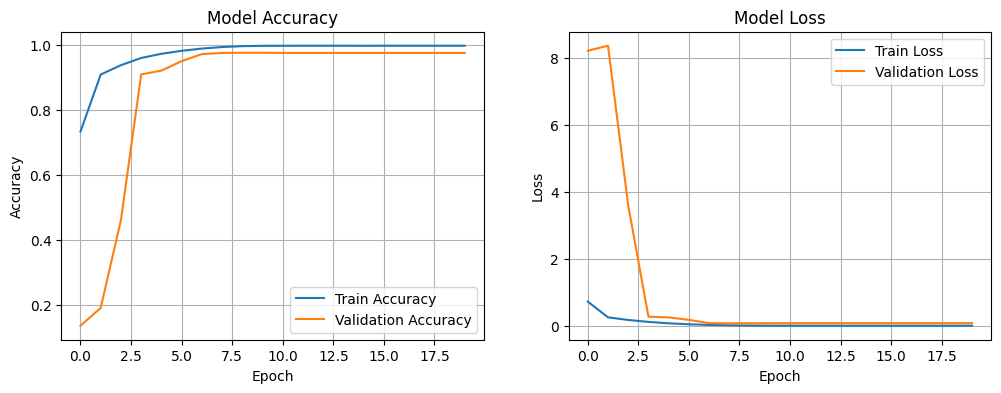

In [ ]:
# Set seeds for reproducibility
np.random.seed(42)

# Train model
trained_model, history = train_adam(
    model=model,
    train_dataset=train_tf_dataset,
    val_dataset=val_tf_dataset,
    test_dataset=test_tf_dataset,
    epochs=20,
    learning_rate=0.001
)

In [ ]:
model.save('pre-trained/CBAM_VGG15.keras')

### Performance Assessment

In [ ]:
# If necessary, load the model
model = load_model('pre-trained/CBAM_VGG15.keras')

In [ ]:
# Get predictions
y_pred = model.predict(test_tf_dataset)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class indices

# Get true labels
y_true = np.concatenate([y for x, y in test_tf_dataset], axis=0)
y_true_classes = y_true.flatten()  # Convert one-hot encoded labels to class indices

# Compute F1 score
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')  # Weighted F1 for multiclass classification
print(f"Test F1 Score: {f1:.4f}")

54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step
Test F1 Score: 0.9824


## SE-CNN

In [ ]:
# Define input shape
input_shape = (64, 64, 3)

# Create the model
model = SE_CNN(input_shape=input_shape)

# Print the model summary
model.summary()

Model: "SE_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 64, 64, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ 1_1_conv (Conv2D)         │ (None, 64, 64, 32)     │            896 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ 1_1_bn                    │ (None, 64, 64, 32)     │            128 │ 1_1_conv[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ 1_1_activation            │ (None, 64, 64, 32)     │              0 │ 1_1_bn[0][0]           │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_15          │ (None, 32, 32, 32)     │              0 │ 1_1_activation[0][0]   │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ 2_1_conv (Conv2D)         │ (None, 32, 32, 64)     │         18,496 │ max_pooling2d_15[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ 2_1_bn                    │ (None, 32, 32, 64)     │            256 │ 2_1_conv[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ 2_1_activation            │ (None, 32, 32, 64)     │              0 │ 2_1_bn[0][0]           │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_16          │ (None, 16, 16, 64)     │              0 │ 2_1_activation[0][0]   │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ 3_1_conv (Conv2D)         │ (None, 16, 16, 128)    │         73,856 │ max_pooling2d_16[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ 3_1_bn                    │ (None, 16, 16, 128)    │            512 │ 3_1_conv[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ 3_1_activation            │ (None, 16, 16, 128)    │              0 │ 3_1_bn[0][0]           │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_17          │ (None, 8, 8, 128)      │              0 │ 3_1_activation[0][0]   │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 128)            │              0 │ max_pooling2d_17[0][0] │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├──────────────────────

 Total params: 505,032 (1.93 MB)

 Trainable params: 504,072 (1.92 MB)

 Non-trainable params: 960 (3.75 KB)

Epoch 1/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.7550 - loss: 0.8286 - val_accuracy: 0.1373 - val_loss: 6.6584 - learning_rate: 0.0010
Epoch 2/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9453 - loss: 0.1552 - val_accuracy: 0.1419 - val_loss: 7.0719 - learning_rate: 9.0484e-04
Epoch 3/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9627 - loss: 0.1078 - val_accuracy: 0.6624 - val_loss: 1.4709 - learning_rate: 7.4082e-04
Epoch 4/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9692 - loss: 0.0802 - val_accuracy: 0.9334 - val_loss: 0.2339 - learning_rate: 5.4881e-04
Epoch 5/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9912 - loss: 0.0273 - val_accuracy: 0.9416 - val_loss: 0.2067 - learning_rate: 3.6788e-04
Epoch 6/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9918 - loss: 0.0212 - val_accuracy: 0.9731 - val_loss: 0.0847 - learning_rate: 2.2313e-04
Epoch 7/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accura

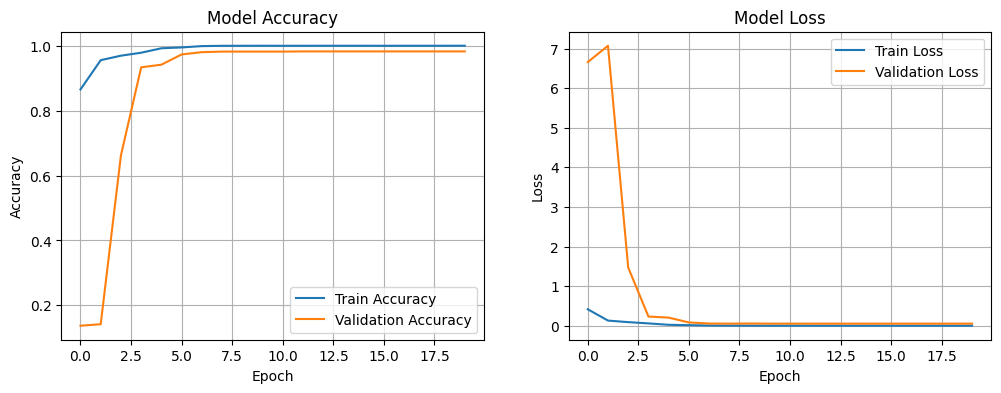

In [ ]:
# Set seeds for reproducibility
np.random.seed(42)

# Train model
trained_model, history = train_adam(
    model=model,
    train_dataset=train_tf_dataset,
    val_dataset=val_tf_dataset,
    test_dataset=test_tf_dataset,
    epochs=20,
    learning_rate=0.001
)

In [ ]:
model.save('pre-trained/SE_CNN.keras')

### Performance Assessment

In [ ]:
# If necessary, load the model
model = load_model('pre-trained/SE_CNN.keras')

In [ ]:
# Get predictions
y_pred = model.predict(test_tf_dataset)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class indices

# Get true labels
y_true = np.concatenate([y for x, y in test_tf_dataset], axis=0)
y_true_classes = y_true.flatten()  # Convert one-hot encoded labels to class indices

# Compute F1 score
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')  # Weighted F1 for multiclass classification
print(f"Test F1 Score: {f1:.4f}")

54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step
Test F1 Score: 0.9819


## SA-CNN

In [ ]:
# Define input shape
input_shape = (64, 64, 3)

# Create the model
model = SA_CNN(input_shape=input_shape)

# Print the model summary
model.summary()

Model: "SA_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 1_1_conv (Conv2D)                    │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 1_1_bn (BatchNormalization)          │ (None, 64, 64, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 1_1_activation (Activation)          │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_attention_10                 │ (None, 32, 32, 32)          │              98 │
│ (SpatialAttention)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 2_1_conv (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 2_1_bn (BatchNormalization)          │ (None, 32, 32, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 2_1_activation (Activation)          │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_attention_11                 │ (None, 16, 16, 64)          │              98 │
│ (SpatialAttention)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 3_1_conv (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 3_1_bn (BatchNormalization)          │ (None, 16, 16, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 3_1_activation (Activation)          │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_attention_12                 │ (None, 8, 8, 128)           │              98 │
│ (SpatialAttention)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 4_1_conv (Conv2D)                    │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 4_1_bn (BatchNormalization)          │ (None, 8, 8, 256)           │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 4_1_activation (Activation)          │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (None, 4, 4, 256)           │              

 Total params: 423,504 (1.62 MB)

 Trainable params: 422,544 (1.61 MB)

 Non-trainable params: 960 (3.75 KB)

Epoch 1/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.7566 - loss: 0.7253 - val_accuracy: 0.1373 - val_loss: 7.0044 - learning_rate: 0.0010
Epoch 2/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.9334 - loss: 0.1813 - val_accuracy: 0.1379 - val_loss: 7.3959 - learning_rate: 9.0484e-04
Epoch 3/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9587 - loss: 0.1201 - val_accuracy: 0.6799 - val_loss: 1.4276 - learning_rate: 7.4082e-04
Epoch 4/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9693 - loss: 0.0843 - val_accuracy: 0.9305 - val_loss: 0.1882 - learning_rate: 5.4881e-04
Epoch 5/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9822 - loss: 0.0531 - val_accuracy: 0.9714 - val_loss: 0.0908 - learning_rate: 3.6788e-04
Epoch 6/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9909 - loss: 0.0281 - val_accuracy: 0.9667 - val_loss: 0.1052 - learning_rate: 2.2313e-04
Epoch 7/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accura

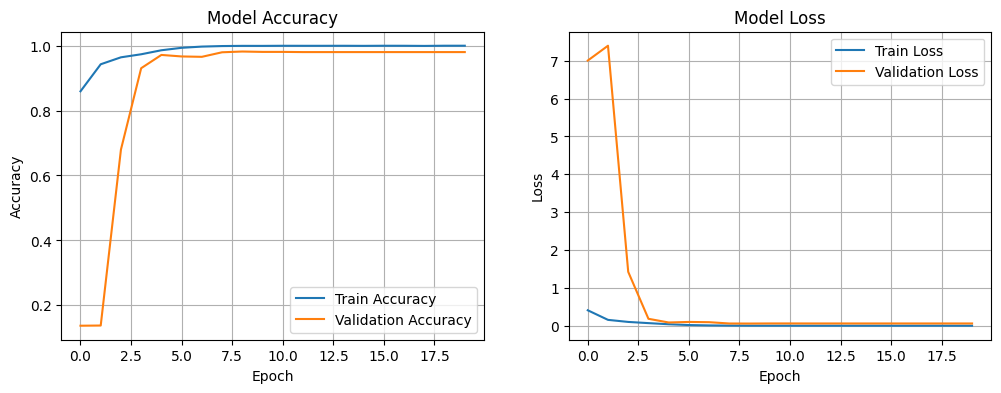

In [ ]:
# Set seeds for reproducibility
np.random.seed(42)

# Train model
trained_model, history = train_adam(
    model=model,
    train_dataset=train_tf_dataset,
    val_dataset=val_tf_dataset,
    test_dataset=test_tf_dataset,
    epochs=20,
    learning_rate=0.001
)

In [ ]:
model.save('pre-trained/SA_CNN.keras')

### Performance Assessment

In [ ]:
# If necessary, load the model
model = load_model('pre-trained/SA_CNN.keras')

In [ ]:
# Get predictions
y_pred = model.predict(test_tf_dataset)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class indices

# Get true labels
y_true = np.concatenate([y for x, y in test_tf_dataset], axis=0)
y_true_classes = y_true.flatten()  # Convert one-hot encoded labels to class indices

# Compute F1 score
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')  # Weighted F1 for multiclass classification
print(f"Test F1 Score: {f1:.4f}")

54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step
Test F1 Score: 0.9775


## CBAM-CNN

I tried to do the same I did in CBAM-VGG15 with the previous CNN but it doesn't improve anything so I will leave it like this.

In [ ]:
# Define input shape
input_shape = (64, 64, 3)

# Create the model
model = CBAM_CNN(input_shape=input_shape)

# Print the model summary
model.summary()

Model: "CBAM_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 64, 64, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ 1_1_conv (Conv2D)         │ (None, 64, 64, 32)     │            896 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ 1_1_bn                    │ (None, 64, 64, 32)     │            128 │ 1_1_conv[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ 1_1_activation            │ (None, 64, 64, 32)     │              0 │ 1_1_bn[0][0]           │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_23          │ (None, 32, 32, 32)     │              0 │ 1_1_activation[0][0]   │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 32)             │              0 │ max_pooling2d_23[0][0] │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling2d_12   │ (None, 32)             │              0 │ max_pooling2d_23[0][0] │
│ (GlobalMaxPooling2D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_53 (Dense)          │ (None, 4)              │            128 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_55 (Dense)          │ (None, 4)              │            128 │ global_max_pooling2d_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_54 (Dense)          │ (None, 32)             │            128 │ dense_53[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_56 (Dense)          │ (None, 32)             │            128 │ dense_55[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_12 (Add)              │ (None, 32)             │              0 │ dense_54[0][0],        │
│                           │                        │                │ dense_56[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_12             │ (None, 32)             │              0 │ add_12[0][0]           │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_12 (Reshape)      │ (None, 1, 1, 32)       │              0 │ activation_12[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_110 (Multiply)   │ (None, 32, 32, 32)     │              0 │ max_pooling2d_23[0][0… │
│                           │                        │                │ reshape_12[0][0]       │
├──────────────────────

 Total params: 467,024 (1.78 MB)

 Trainable params: 466,064 (1.78 MB)

 Non-trainable params: 960 (3.75 KB)

Epoch 1/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 25s 65ms/step - accuracy: 0.7428 - loss: 0.7217 - val_accuracy: 0.1373 - val_loss: 2.5185 - learning_rate: 0.0010
Epoch 2/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.9366 - loss: 0.1750 - val_accuracy: 0.1373 - val_loss: 5.7541 - learning_rate: 9.0484e-04
Epoch 3/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9603 - loss: 0.1130 - val_accuracy: 0.7074 - val_loss: 0.8926 - learning_rate: 7.4082e-04
Epoch 4/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9709 - loss: 0.0877 - val_accuracy: 0.8803 - val_loss: 0.3704 - learning_rate: 5.4881e-04
Epoch 5/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9855 - loss: 0.0424 - val_accuracy: 0.9574 - val_loss: 0.1402 - learning_rate: 3.6788e-04
Epoch 6/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9949 - loss: 0.0191 - val_accuracy: 0.9755 - val_loss: 0.0851 - learning_rate: 2.2313e-04
Epoch 7/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accura

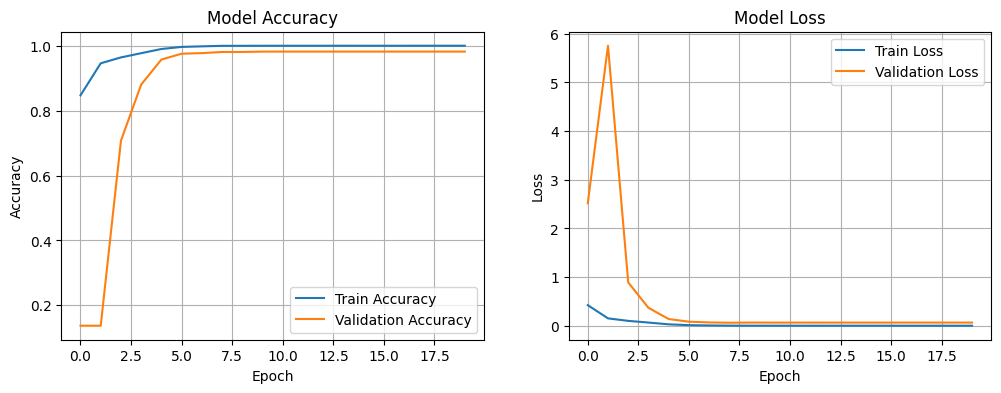

In [ ]:
# Set seeds for reproducibility
np.random.seed(42)

# Train model
trained_model, history = train_adam(
    model=model,
    train_dataset=train_tf_dataset,
    val_dataset=val_tf_dataset,
    test_dataset=test_tf_dataset,
    epochs=20,
    learning_rate=0.001
)

In [ ]:
model.save('pre-trained/CBAM_CNN.keras')

### Performance Assessment

In [ ]:
# If necessary, load the model
model = load_model('pre-trained/CBAM_CNN.keras')

In [ ]:
# Get predictions
y_pred = model.predict(test_tf_dataset)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class indices

# Get true labels
y_true = np.concatenate([y for x, y in test_tf_dataset], axis=0)
y_true_classes = y_true.flatten()  # Convert one-hot encoded labels to class indices

# Compute F1 score
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')  # Weighted F1 for multiclass classification
print(f"Test F1 Score: {f1:.4f}")

54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step
Test F1 Score: 0.9786


# Comparison between attention based networks

In [ ]:
# Load all the models we want to compare
model_1 = load_model('pre-trained/SE_CNN.keras')
model_2 = load_model('pre-trained/SA_CNN.keras')
model_3 = load_model('pre-trained/CBAM_CNN.keras')
model_4 = load_model('pre-trained/SE_VGG15.keras')
model_5 = load_model('pre-trained/SA_VGG15.keras')
model_6 = load_model('pre-trained/CBAM_VGG15.keras')

In [ ]:
models = [model_1,model_2,model_3,model_4,model_5,model_6]
model_names = ['SE_CNN','SA_CNN','CBAM_CNN','SE_VGG15','SA_VGG15','CBAM_VGG15']
f1_scores = [0.9819,0.9775,0.9786,0.9821,0.9783,0.9824]
training_times = [21,18,25,58,38,45]
memory_occupations = [1.93,1.62,1.78,27.74,27.08,27.75]

data = {
    'model': models,
    'name': model_names,
    'f1-score': f1_scores,
    'time': training_times,
    'memory_occupation': memory_occupations
}


df = pd.DataFrame(data)

df

model        name  f1-score  time  \
0      <Functional name=SE_CNN, built=True>      SE_CNN    0.9819    21   
1      <Functional name=SA_CNN, built=True>      SA_CNN    0.9775    18   
2    <Functional name=CBAM_CNN, built=True>    CBAM_CNN    0.9786    25   
3    <Functional name=SE_VGG15, built=True>    SE_VGG15    0.9821    58   
4    <Functional name=SA_VGG15, built=True>    SA_VGG15    0.9783    38   
5  <Functional name=CBAM_VGG15, built=True>  CBAM_VGG15    0.9824    45   

   memory_occupation  
0               1.93  
1               1.62  
2               1.78  
3              27.74  
4              27.08  
5              27.75

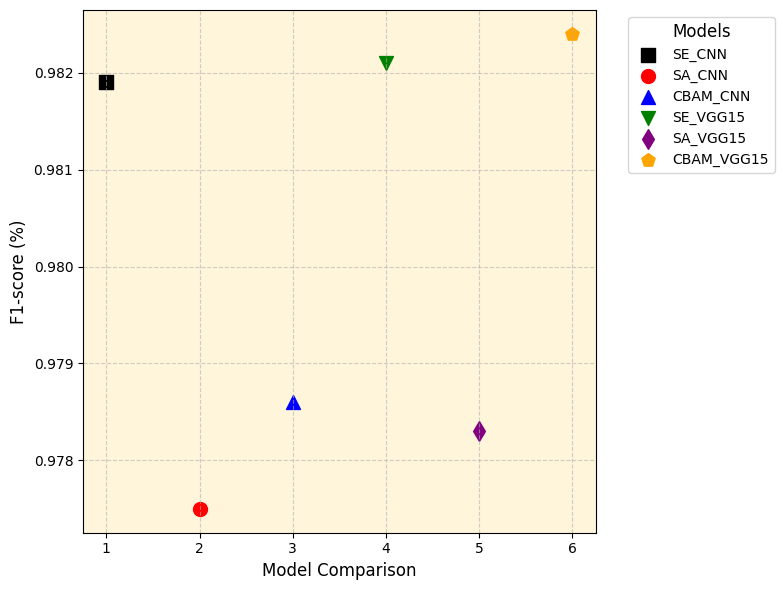

In [ ]:
# x-axis
pbc = [1, 2, 3, 4, 5, 6, 7]

# Markers for each model
markers = ['s', 'o', '^', 'v', 'd', 'p', '>', 'x', '*', 'h']
colors = ['black', 'red', 'blue', 'green', 'purple', 'orange', 'cyan', 'brown', 'gold', 'coral']

# Plot setup
plt.figure(figsize=(8, 6))
plt.gca().set_facecolor("#FFF5DB")

# Scatter plot
for i, row in df.iterrows():
    plt.scatter(pbc[i], row['f1-score'], marker=markers[i], color=colors[i], label=row['name'], s=100)

# Labels and titles
plt.xlabel('Model Comparison', fontsize=12)
plt.ylabel('F1-score (%)', fontsize=12)

# Custom Legend
legend = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Models", fontsize=10)
plt.setp(legend.get_title(), fontsize=12)

# Grid and display
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

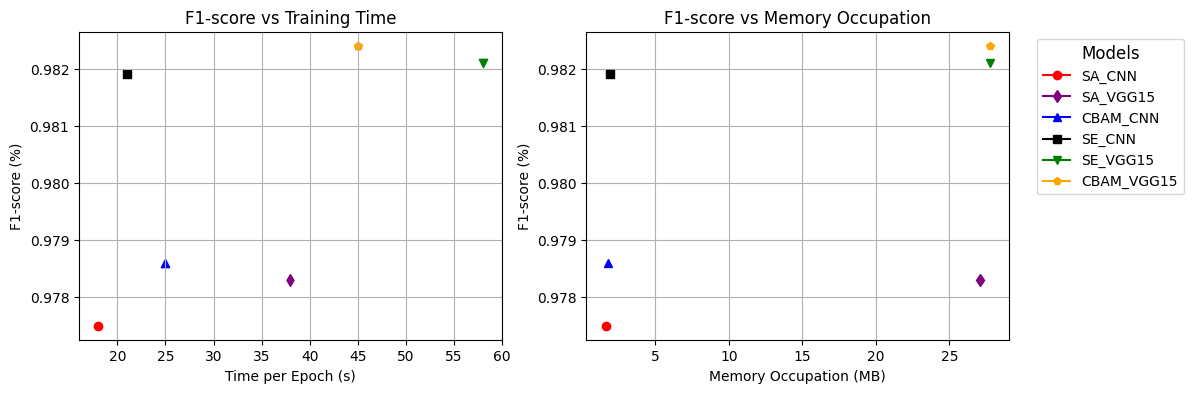

In [ ]:
df = df.sort_values(by=["f1-score", "time", "memory_occupation"], ascending=True)

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
for i, row in df.iterrows():
    plt.scatter(row['time'], row['f1-score'], marker=markers[i], color=colors[i], label=row['name'])
plt.title('F1-score vs Training Time')
plt.xlabel('Time per Epoch (s)')
plt.ylabel('F1-score (%)')
plt.grid(True)

# Plot training & validation loss values
plt.subplot(1, 2, 2)
for i, row in df.iterrows():
    plt.plot(row['memory_occupation'], row['f1-score'], marker=markers[i], color=colors[i], label=row['name'])
plt.title('F1-score vs Memory Occupation')
plt.xlabel('Memory Occupation (MB)')
plt.ylabel('F1-score (%)')
plt.grid(True)
# Custom Legend
legend = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Models", fontsize=10)
plt.setp(legend.get_title(), fontsize=12)

plt.show()

### GRAD-CAM

In [ ]:
# Take the last convolution layer for each model
last_layer_1 = "4_1_conv"
last_layer_2 = "4_1_conv"
last_layer_3 = "4_1_conv"
last_layer_4 = "5_3_conv"
last_layer_5 = "5_3_conv"
last_layer_6 = "5_3_conv"

# Put everything in lists
last_layers = [last_layer_1, last_layer_2, last_layer_3, last_layer_4,last_layer_5,last_layer_6]

In [ ]:
# Model info dictionary
model_info_dict = {
    model_1.name: {'model': model_1, 'last_layer': last_layer_1, 'name': 'SE_CNN'},
    model_2.name: {'model': model_2, 'last_layer': last_layer_2, 'name': 'SA_CNN'},
    model_3.name: {'model': model_3, 'last_layer': last_layer_3, 'name': 'CBAM_CNN'},
    model_4.name: {'model': model_4, 'last_layer': last_layer_4, 'name': 'SE_VGG15'},
    model_5.name: {'model': model_5, 'last_layer': last_layer_5, 'name': 'SA_VGG15'},
    model_6.name: {'model': model_6, 'last_layer': last_layer_6, 'name': 'CBAM_VGG15'}
}


SE_CNN
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


SA_CNN
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


CBAM_CNN
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


SE_VGG15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


SA_VGG15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


CBAM_VGG15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


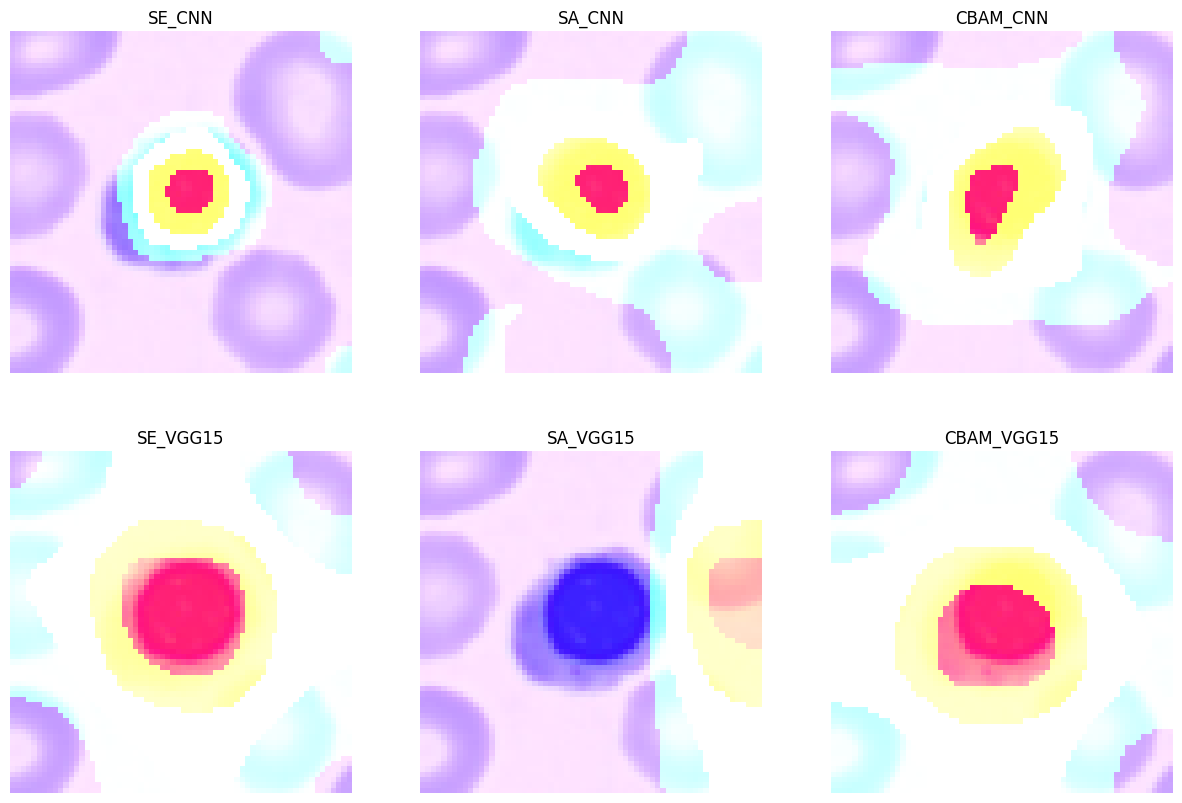

In [ ]:
import random

# Set seeds for reproducibility
# np.random.seed(4)

# Select a random image from the test dataset
def get_random_image(dataset):
    dataset_list = list(dataset.as_numpy_iterator())  # Convert the dataset to a list
    random_batch = random.choice(dataset_list)  # Select a random batch
    random_index = random.randint(0, random_batch[0].shape[0] - 1)  # Select a random index within the batch
    sample_img = random_batch[0][random_index:random_index + 1]  # Get one image
    sample_label = random_batch[1][random_index]  # Get the corresponding label
    return sample_img, sample_label

# Get a random sample image
sample_img, sample_label = get_random_image(test_tf_dataset)

# Plot Grad-CAM results
plt.figure(figsize=(15, 10))

# Loop through models to compute and plot Grad-CAM heatmaps
for i, (model_name, model_info) in enumerate(model_info_dict.items()):
    model = model_info["model"]
    target_layer_name = model_info["last_layer"]
    title = model_info["name"]
    print(title)

    # Get the heatmap
    pred_class = model.predict(sample_img).argmax(axis=-1)
    heatmap = get_gradcam_heatmap(model, sample_img, target_layer_name, pred_class)

    # Display the Grad-CAM heatmap
    plt.subplot(2, int(len(model_info_dict)/2), i+1)  # Use len(model_info_dict) for dynamic sizing
    plt.imshow(plot_gradcam(sample_img[0], heatmap))
    plt.axis("off")
    plt.title(title)

plt.show()

# Final Conclusion
In this second part of the analysis, we studied the perfomance of CNN and VGG architectures with attention mechanisms. After the comparison of these 6 models we remark CBAM-VGG15 as the best among the ones studied and SE-CNN as the most efficient one.
